# Environment setup

In [5]:
!pip install --upgrade torch torchvision transformers bitsandbytes peft accelerate pillow lightning sentencepiece -q
import torch
print(f"GPU: {torch.cuda.get_device_name(0)}, VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.0f}GB")

GPU: NVIDIA H100 PCIe, VRAM: 79GB


In [6]:
!pip install nltk pandas tqdm rouge-score
!pip install tf-keras
!pip install nltk -q
!pip install rouge_score -q
!pip install --upgrade setuptools -q
import nltk
import pkg_resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  
try:
    rouge_version = pkg_resources.get_distribution("rouge_score").version
    print("rouge_score version:", rouge_version)
    setuptools_version = pkg_resources.get_distribution("setuptools").version
    print("setuptools version:", setuptools_version)
except Exception as e:
    print(f"Version check failed: {e}")
    print("Proceeding with usage.")



Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


/usr/lib/python3/dist-packages/sklearn/utils/fixes.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore


rouge_score version: 0.1.2
setuptools version: 80.9.0


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ubuntu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [10]:
import torch
import gc

# Clear GPU memory completely
torch.cuda.empty_cache()
gc.collect()


0

In [8]:
!pip install --no-cache-dir --upgrade sentencepiece -q

In [9]:
import sentencepiece ; print("SentencePiece version:", sentencepiece.__version__)

SentencePiece version: 0.2.0


Directory check

In [11]:
import json, os
train_json = "fsdam/few_shot/train_llava.json"
val_json   = "fsdam/few_shot/val_llava.json"
train_dir  = "fsdam/few_shot/train"
val_dir    = "fsdam/few_shot/val"



print("Train records:", len(json.load(open(train_json))))
print("Val   records:", len(json.load(open(val_json))))
print("Train images:", len(os.listdir(train_dir)))
print("Val   images:", len(os.listdir(val_dir)))


Train records: 80
Val   records: 20
Train images: 80
Val   images: 20


MODEL Loading

In [12]:
# import torch
# import os
# import json
# from PIL import Image
# from torch.utils.data import Dataset, DataLoader
# from transformers import AutoProcessor, BitsAndBytesConfig, LlavaNextForConditionalGeneration
# from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
# import lightning.pytorch as L
# from torchmetrics.text import ROUGEScore
# from lightning.pytorch.callbacks import EarlyStopping

# # Set mixed precision
# torch.set_float32_matmul_precision('medium')

# # Define paths and constants
# MODEL_ID = "llava-hf/llava-v1.6-vicuna-7b-hf"
# DATASET_DIR = "fsdam"
# FEW_SHOT_DIR = os.path.join(DATASET_DIR, "few_shot")
# ONE_SHOT_DIR = os.path.join(DATASET_DIR, "one_shot")
# TEST_DIR = os.path.join(DATASET_DIR, "test_set")
# TRAIN_JSON_FEW = os.path.join(FEW_SHOT_DIR, "train_llava.json")
# TRAIN_JSON_ONE = os.path.join(ONE_SHOT_DIR, "train_llava.json")
# VAL_JSON = os.path.join(FEW_SHOT_DIR, "val_llava.json")
# TEST_JSON = os.path.join(TEST_DIR, "test_llava.json")
# CHECKPOINT_DIR = "fsdam-s3/logs"
# MAX_LENGTH = 1200

# # Create checkpoint directory
# os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# # Verify paths
# print("Few-shot train JSON exists:", os.path.exists(TRAIN_JSON_FEW))
# print("One-shot train JSON exists:", os.path.exists(TRAIN_JSON_ONE))
# print("Val JSON exists:", os.path.exists(VAL_JSON))
# print("Test JSON exists:", os.path.exists(TEST_JSON))

# # Load processor and model
# try:
#     processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
#     processor.tokenizer.padding_side = "right"
#     if processor.tokenizer.pad_token is None or processor.tokenizer.pad_token == "<unk>":
#         processor.tokenizer.pad_token = processor.tokenizer.eos_token
#         processor.tokenizer.pad_token_id = processor.tokenizer.eos_token_id
#     print("Pad token:", processor.tokenizer.pad_token)

#     bnb_cfg = BitsAndBytesConfig(
#         load_in_4bit=True,
#         bnb_4bit_quant_type="nf4",
#         bnb_4bit_compute_dtype=torch.float16
#     )
#     model = LlavaNextForConditionalGeneration.from_pretrained(
#         MODEL_ID, torch_dtype=torch.float16, quantization_config=bnb_cfg, trust_remote_code=True
#     )
# except Exception as e:
#     print(f"Error loading model or processor: {e}")
#     raise e

# # Configure LoRA
# model.gradient_checkpointing_enable()
# model = prepare_model_for_kbit_training(model)
# lora_config = LoraConfig(
#     r=16,
#     lora_alpha=16,
#     lora_dropout=0.2,
#     target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "multi_modal_projector.linear_1", "multi_modal_projector.linear_2"],
#     init_lora_weights="gaussian"
# )
# model = get_peft_model(model, lora_config)
# model.enable_input_require_grads()

# # Move to GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# print("Model device:", next(model.parameters()).device)
# print("Model and processor loaded successfully.")

Dataset visual in Llava format

In [14]:
# class LlavaDataset(Dataset):
#     def __init__(self, json_path, image_dir):
#         try:
#             with open(json_path, 'r') as f:
#                 self.data = json.load(f)
#         except Exception as e:
#             print(f"Error loading JSON {json_path}: {e}")
#             raise e
#         self.image_dir = image_dir
#         # Debug JSON structure
#         print(f"Sample JSON entry from {json_path}:", json.dumps(self.data[0], indent=2)[:500] + "...")

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         try:
#             item = self.data[idx]
#             image_path = os.path.join(self.image_dir, os.path.basename(item['image']))
#             if 'conversations' in item:
#                 for conv in item['conversations']:
#                     if conv.get('from') == 'gpt':
#                         return image_path, conv['value']
#             if 'response' in item:
#                 return image_path, item['response']
#             if 'answer' in item:
#                 return image_path, item['answer']
#             raise ValueError(f"No valid response found for item {idx}: {json.dumps(item, indent=2)}")
#         except Exception as e:
#             print(f"Error accessing item {idx}: {e}")
#             raise e

# # Load datasets
# try:
#     train_dataset_few_shot = LlavaDataset(TRAIN_JSON_FEW, FEW_SHOT_DIR + "/train")
#     train_dataset_one_shot = LlavaDataset(TRAIN_JSON_ONE, ONE_SHOT_DIR + "/train")
#     val_dataset = LlavaDataset(VAL_JSON, FEW_SHOT_DIR + "/val")
#     test_dataset = LlavaDataset(TEST_JSON, TEST_DIR + "/test")
# except Exception as e:
#     print(f"Dataset loading error: {e}")
#     raise e

# # Debug dataset sizes
# print("Few-shot train size:", len(train_dataset_few_shot))
# print("One-shot train size:", len(train_dataset_one_shot))
# print("Val size:", len(val_dataset))
# print("Test size:", len(test_dataset))

# # Collate function with few-shot support
# def collate_fn(batch, processor=processor, prompt_template=None, use_few_shot_examples=False, device="cuda"):
#     imgs, seqs = zip(*batch)
#     processed_imgs = []
#     for img_path in imgs:
#         try:
#             img = Image.open(img_path).convert("RGB").resize((224, 224))
#             processed_imgs.append(img)
#         except Exception as e:
#             print(f"Error processing image {img_path}: {e}")
#             raise e
#     prompt = prompt_template or "[INST] <image>\nDescribe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] {seq}"
#     if use_few_shot_examples:
#         few_shot_prompt = ""
#         for i in range(min(2, len(train_dataset_few_shot))):
#             img_path, example_seq = train_dataset_few_shot[i]
#             few_shot_prompt += f"[INST] <image>\nDescribe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] {example_seq}\n"
#         conversation_texts = [few_shot_prompt + prompt.format(seq=seq) for seq in seqs]
#     else:
#         conversation_texts = [prompt.format(seq=seq) for seq in seqs]
#     inputs = processor(
#         text=conversation_texts,
#         images=processed_imgs,
#         return_tensors="pt",
#         padding=True,
#         truncation=True,
#         max_length=MAX_LENGTH
#     )
#     labels = inputs["input_ids"].clone()
#     labels[labels == processor.tokenizer.pad_token_id] = -100
#     inputs["labels"] = labels
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     return inputs

# print("Datasets and collate function defined.")

# Few shot 

In [56]:
import torch
import os
import json
import gc
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, BitsAndBytesConfig, LlavaNextForConditionalGeneration
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
import lightning.pytorch as L
from torchmetrics.text import ROUGEScore
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
import logging

# Set environment variables
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
file_handler = logging.FileHandler("fsdam-s3/logs/training.log")
file_handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Set mixed precision
torch.set_float32_matmul_precision('medium')

# Clear GPU memory
torch.cuda.empty_cache()
gc.collect()

# Define paths and constants
MODEL_ID = "llava-hf/llava-v1.6-vicuna-7b-hf"
DATASET_DIR = "fsdam"
FEW_SHOT_DIR = os.path.join(DATASET_DIR, "few_shot")
TEST_DIR = os.path.join(DATASET_DIR, "test_set")
TRAIN_JSON_FEW = os.path.join(FEW_SHOT_DIR, "train_llava.json")
VAL_JSON = os.path.join(FEW_SHOT_DIR, "val_llava.json")
TEST_JSON = os.path.join(TEST_DIR, "test_llava.json")
CHECKPOINT_DIR = "fsdam-s3/logs"
LORA_CHECKPOINT_DIR = os.path.join(CHECKPOINT_DIR, "lora_weights_few_shot")
MAX_LENGTH = 2048

# Create checkpoint directories
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(LORA_CHECKPOINT_DIR, exist_ok=True)

# Verify paths
logger.info("Few-shot train JSON exists: %s", os.path.exists(TRAIN_JSON_FEW))
logger.info("Val JSON exists: %s", os.path.exists(VAL_JSON))
logger.info("Test JSON exists: %s", os.path.exists(TEST_JSON))

# Load processor and model
try:
    processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
    processor.tokenizer.padding_side = "left"  # For decoder-only architecture
    if processor.tokenizer.pad_token is None or processor.tokenizer.pad_token == "<unk>":
        processor.tokenizer.pad_token = processor.tokenizer.eos_token
        processor.tokenizer.pad_token_id = processor.tokenizer.eos_token_id
    logger.info("Pad token: %s", processor.tokenizer.pad_token)
    bnb_cfg = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16
    )
    model = LlavaNextForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        quantization_config=bnb_cfg,
        trust_remote_code=True
    )
except Exception as e:
    logger.error("Error loading model or processor: %s", e)
    raise e

# Configure LoRA
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)
lora_config = LoraConfig(
    r=64,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "multi_modal_projector.linear_1", "multi_modal_projector.linear_2"],
    init_lora_weights="gaussian"
)
model = get_peft_model(model, lora_config)
model.enable_input_require_grads()

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
logger.info("Model device: %s", next(model.parameters()).device)
logger.info("Model and processor loaded successfully.")

# Define dataset class
class LlavaDataset(Dataset):
    def __init__(self, json_path, image_dir):
        try:
            with open(json_path, 'r') as f:
                self.data = json.load(f)
        except Exception as e:
            logger.error("Error loading JSON %s: %s", json_path, e)
            raise e
        self.image_dir = image_dir
        logger.info("Sample JSON entry from %s: %s", json_path, json.dumps(self.data[0], indent=2)[:500] + "...")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            item = self.data[idx]
            image_path = os.path.join(self.image_dir, os.path.basename(item['image']))
            if 'conversations' in item:
                for conv in item['conversations']:
                    if conv.get('from') == 'gpt':
                        return image_path, conv['value']
            if 'response' in item:
                return image_path, item['response']
            if 'answer' in item:
                return image_path, item['answer']
            raise ValueError(f"No valid response found for item {idx}: {json.dumps(item, indent=2)}")
        except Exception as e:
            logger.error("Error accessing item %d: %s", idx, e)
            raise e

# Load datasets
try:
    train_dataset_few_shot = LlavaDataset(TRAIN_JSON_FEW, FEW_SHOT_DIR + "/train")
    val_dataset = LlavaDataset(VAL_JSON, FEW_SHOT_DIR + "/val")
    test_dataset = LlavaDataset(TEST_JSON, TEST_DIR + "/test")
except Exception as e:
    logger.error("Dataset loading error: %s", e)
    raise e

# Debug dataset sizes
logger.info("Few-shot train size: %d", len(train_dataset_few_shot))
logger.info("Val size: %d", len(val_dataset))
logger.info("Test size: %d", len(test_dataset))

# Collate function
def collate_fn(batch, processor=processor, prompt_template=None, use_few_shot_examples=False, device="cuda"):
    logger.info("Processing batch with %d samples", len(batch))
    imgs, seqs = zip(*batch)
    processed_imgs = []
    for img_path in imgs:
        logger.info("Loading image: %s", img_path)
        try:
            img = Image.open(img_path).convert("RGB").resize((336, 336))  # Updated to 336x336
            processed_imgs.append(img)
        except Exception as e:
            logger.error("Error processing image %s: %s", img_path, e)
            raise e

    prompt = prompt_template or "[INST] <image>\nDescribe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] {seq}"
    if use_few_shot_examples:
        few_shot_prompt = ""
        for i in range(min(2, len(train_dataset_few_shot))):
            img_path, example_seq = train_dataset_few_shot[i]
            few_shot_prompt += f"[INST] <image>\nDescribe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] {example_seq}\n"
        conversation_texts = [few_shot_prompt + prompt.format(seq=seq) for seq in seqs]
    else:
        conversation_texts = [prompt.format(seq=seq) for seq in seqs]

    logger.info("Processing %d texts", len(conversation_texts))
    try:
        inputs = processor(
            text=conversation_texts,
            images=processed_imgs,
            return_tensors="pt",
            padding=True,
            truncation=False,
            max_length=MAX_LENGTH
        )
        logger.info("Input shapes: input_ids=%s, pixel_values=%s", inputs['input_ids'].shape, inputs['pixel_values'].shape)
    except Exception as e:
        logger.error("Processor error: %s", e)
        raise e

    labels = inputs["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    inputs["labels"] = labels
    inputs = {k: v.to(device) for k, v in inputs.items()}
    return inputs

# Lightning module
class LlavaModelPLModule(L.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model
        self.batch_size = config["batch_size"]
        self.rouge = ROUGEScore()

    def training_step(self, batch, batch_idx):
        logger.info("Training batch %d, size: %d", batch_idx, len(batch['input_ids']))
        outputs = self.model(**batch)
        loss = outputs.loss
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        if batch_idx == 0:
            predictions = self.processor.batch_decode(outputs.logits.argmax(-1), skip_special_tokens=True)
            logger.info("Sample Training Prediction: %s...", predictions[0][:100])
        return loss

    def validation_step(self, batch, batch_idx):
        logger.info("Validation batch %d, size: %d", batch_idx, len(batch['input_ids']))
        
        # Calculate validation loss first
        outputs = self.model(**batch)
        val_loss = outputs.loss
        self.log("val_loss", val_loss, prog_bar=True, on_step=True, on_epoch=True)
        
        # Then generate predictions for ROUGE score
        generation_kwargs = {k: v for k, v in batch.items() if k != "labels"}
        generated_outputs = self.model.generate(
            **generation_kwargs,
            max_new_tokens=512,
            do_sample=False,
            pad_token_id=self.processor.tokenizer.pad_token_id,
            eos_token_id=self.processor.tokenizer.eos_token_id
        )
        predictions = self.processor.batch_decode(generated_outputs, skip_special_tokens=True)
        valid_labels = batch["labels"].clone()
        valid_labels[valid_labels == -100] = self.processor.tokenizer.pad_token_id
        targets = self.processor.tokenizer.batch_decode(valid_labels, skip_special_tokens=True)
        targets = [t.replace(self.processor.tokenizer.pad_token, "").strip() for t in targets]
        predictions = [p.split("[/INST]")[-1].strip() if "[/INST]" in p else p for p in predictions]
        rouge_score = self.rouge(predictions, targets)["rougeL_fmeasure"]
        self.log("val_rouge", rouge_score, prog_bar=True, on_step=True, on_epoch=True)
        
        if batch_idx == 0:
            logger.info("Sample Validation Prediction: %s...", predictions[0][:100])
            logger.info("Sample Validation Target: %s...", targets[0][:100])
            # Save sample predictions
            sample_output = [{"prediction": p, "target": t} for p, t in zip(predictions, targets)]
            with open(os.path.join(CHECKPOINT_DIR, f"val_samples_epoch_{self.current_epoch}.json"), 'a') as f:
                json.dump(sample_output, f, indent=2)
                f.write('\n')
        
        return {"val_loss": val_loss, "val_rouge": rouge_score}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config["lr"])
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.config["max_epochs"])
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def train_dataloader(self):
        logger.info("Training dataset size: %d", len(train_dataset_few_shot))
        return DataLoader(
            train_dataset_few_shot,
            collate_fn=lambda x: collate_fn(x, processor, use_few_shot_examples=False),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )

    def val_dataloader(self):
        logger.info("Validation dataset size: %d", len(val_dataset))
        return DataLoader(
            val_dataset,
            collate_fn=lambda x: collate_fn(x, processor, use_few_shot_examples=False),
            batch_size=self.batch_size,
            num_workers=0
        )

    def on_train_epoch_start(self):
        logger.info("Starting epoch %d", self.current_epoch)

    def on_train_end(self):
        save_path = os.path.join(CHECKPOINT_DIR, "final_model_few_shot.ckpt")
        self.trainer.save_checkpoint(save_path)
        logger.info("Lightning checkpoint saved to %s", save_path)
        self.model.save_pretrained(LORA_CHECKPOINT_DIR)
        logger.info("LoRA weights saved to %s", LORA_CHECKPOINT_DIR)

# Training configuration
config = {"max_epochs": 50, "lr": 5e-4, "batch_size": 4, "use_contrastive": False, "contrastive_weight": 0.05}

# Train with early stopping, checkpointing, and CSV logging
trainer = L.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=config["max_epochs"],
    precision="16-mixed",
    val_check_interval=0.5,
    enable_checkpointing=True,
    enable_progress_bar=True,
    log_every_n_steps=5,
    default_root_dir=CHECKPOINT_DIR,
    logger=CSVLogger(save_dir=CHECKPOINT_DIR, name="metrics", version="few_shot"),
    callbacks=[
        EarlyStopping(monitor="val_rouge", mode="max", patience=3),
        ModelCheckpoint(
            dirpath=CHECKPOINT_DIR,
            filename="best_model_{epoch}_{val_rouge:.3f}",
            monitor="val_rouge", #val_los
            mode="max",
            save_top_k=1
        )
    ],
    gradient_clip_val=1.0
)

# Initialize and train model
llava_module = LlavaModelPLModule(config, processor, model)
trainer.fit(llava_module)
logger.info("Training completed.")

# Clean up memory
torch.cuda.empty_cache()
gc.collect()

INFO:__main__:Few-shot train JSON exists: True
INFO:__main__:Val JSON exists: True
INFO:__main__:Test JSON exists: True
INFO:__main__:Pad token: </s>
Loading checkpoint shards: 100%|██████████| 3/3 [00:07<00:00,  2.57s/it]
INFO:__main__:Model device: cuda:0
INFO:__main__:Model and processor loaded successfully.
INFO:__main__:Sample JSON entry from fsdam/few_shot/train_llava.json: {
  "id": "1000_00007",
  "image": "fsdam/few_shot/train/1000_00007.png",
  "conversations": [
    {
      "from": "human",
      "value": "<image> Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why."
    },
    {
      "from": "gpt",
      "value": "The scene shows a city street with parked cars and buildings. The current gaze focuses on the intersection ahead. The future gaze will likely remain the same because the driver needs to monitor cross tr...
INFO:__main__:Sample JSON entry from fsdam/few_shot/val_llava.json: {
  "id": "1737_00085",
  "image": "fsdam/few

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Validation dataset size: 20
/home/ubuntu/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=25` in the `DataLoader` to improve performance.
INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1737_00085.png
INFO:__main__:Loading image: fsdam/few_shot/val/1737_00287.png
INFO:__main__:Loading image: fsdam/few_shot/val/1744_00119.png
INFO:__main__:Loading image: fsdam/few_shot/val/1744_00219.png
INFO:__main__:Processing 4 texts
/home/ubuntu/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2695: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1293]),

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 4
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. Th...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next an...


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:04<00:04,  0.22it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1746_00008.png
INFO:__main__:Loading image: fsdam/few_shot/val/1747_00012.png
INFO:__main__:Loading image: fsdam/few_shot/val/1748_00018.png
INFO:__main__:Loading image: fsdam/few_shot/val/1748_00243.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1282]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 4


INFO:__main__:Training dataset size: 80
/home/ubuntu/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=25` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/20 [00:00<?, ?it/s] 

INFO:__main__:Starting epoch 0
INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/111_00123.png
INFO:__main__:Loading image: fsdam/few_shot/train/1080_00285.png
INFO:__main__:Loading image: fsdam/few_shot/train/1067_00008.png
INFO:__main__:Loading image: fsdam/few_shot/train/1102_00007.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1301]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 4
INFO:__main__:Sample Training Prediction: sierp…ALL
1th [ [by,. buildingmentamentsingsessest, of.ishersings buildings and buildings buildings ...


Epoch 0:   5%|▌         | 1/20 [00:01<00:28,  0.68it/s, v_num=shot, train_loss_step=14.90]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1124_00042.png
INFO:__main__:Loading image: fsdam/few_shot/train/1009_00160.png
INFO:__main__:Loading image: fsdam/few_shot/train/1006_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/1092_00119.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1281]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 1, size: 4


Epoch 0:  10%|█         | 2/20 [00:02<00:26,  0.69it/s, v_num=shot, train_loss_step=10.90]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1136_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/1027_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1091_00103.png
INFO:__main__:Loading image: fsdam/few_shot/train/1000_00007.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1272]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 2, size: 4


Epoch 0:  15%|█▌        | 3/20 [00:04<00:24,  0.69it/s, v_num=shot, train_loss_step=10.60]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1036_00017.png
INFO:__main__:Loading image: fsdam/few_shot/train/1096_00208.png
INFO:__main__:Loading image: fsdam/few_shot/train/1095_00016.png
INFO:__main__:Loading image: fsdam/few_shot/train/10_00048.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1285]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 3, size: 4


Epoch 0:  20%|██        | 4/20 [00:05<00:23,  0.68it/s, v_num=shot, train_loss_step=7.470]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1129_00181.png
INFO:__main__:Loading image: fsdam/few_shot/train/1082_00070.png
INFO:__main__:Loading image: fsdam/few_shot/train/1024_00008.png
INFO:__main__:Loading image: fsdam/few_shot/train/1046_00005.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1288]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 4, size: 4


Epoch 0:  25%|██▌       | 5/20 [00:07<00:21,  0.68it/s, v_num=shot, train_loss_step=5.390]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1100_00111.png
INFO:__main__:Loading image: fsdam/few_shot/train/1145_00038.png
INFO:__main__:Loading image: fsdam/few_shot/train/1135_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1064_00116.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1302]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 5, size: 4


Epoch 0:  30%|███       | 6/20 [00:08<00:20,  0.68it/s, v_num=shot, train_loss_step=4.940]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1066_00005.png
INFO:__main__:Loading image: fsdam/few_shot/train/1058_00033.png
INFO:__main__:Loading image: fsdam/few_shot/train/1016_00053.png
INFO:__main__:Loading image: fsdam/few_shot/train/1076_00009.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1277]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 6, size: 4


Epoch 0:  35%|███▌      | 7/20 [00:10<00:19,  0.68it/s, v_num=shot, train_loss_step=4.320]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/105_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1021_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1106_00061.png
INFO:__main__:Loading image: fsdam/few_shot/train/1077_00265.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1290]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 7, size: 4


Epoch 0:  40%|████      | 8/20 [00:11<00:17,  0.68it/s, v_num=shot, train_loss_step=4.290]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1040_00131.png
INFO:__main__:Loading image: fsdam/few_shot/train/1069_00127.png
INFO:__main__:Loading image: fsdam/few_shot/train/1130_00145.png
INFO:__main__:Loading image: fsdam/few_shot/train/1142_00123.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1299]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 8, size: 4


Epoch 0:  45%|████▌     | 9/20 [00:13<00:16,  0.68it/s, v_num=shot, train_loss_step=4.220]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1029_00109.png
INFO:__main__:Loading image: fsdam/few_shot/train/1056_00008.png
INFO:__main__:Loading image: fsdam/few_shot/train/1065_00130.png
INFO:__main__:Loading image: fsdam/few_shot/train/1020_00018.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1271]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 9, size: 4


Epoch 0:  50%|█████     | 10/20 [00:14<00:14,  0.69it/s, v_num=shot, train_loss_step=4.160]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1737_00085.png
INFO:__main__:Loading image: fsdam/few_shot/val/1737_00287.png
INFO:__main__:Loading image: fsdam/few_shot/val/1744_00119.png
INFO:__main__:Loading image: fsdam/few_shot/val/1744_00219.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1293]), pixel_values=torch.Size([4, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 4
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. Th...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next an...



Validation DataLoader 0:  20%|██        | 1/5 [00:03<00:13,  0.30it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1746_00008.png
INFO:__main__:Loading image: fsdam/few_shot/val/1747_00012.png
INFO:__main__:Loading image: fsdam/few_shot/val/1748_00018.png
INFO:__main__:Loading image: fsdam/few_shot/val/1748_00243.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1282]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 4



Validation DataLoader 0:  40%|████      | 2/5 [00:04<00:06,  0.44it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1753_00160.png
INFO:__main__:Loading image: fsdam/few_shot/val/1754_00079.png
INFO:__main__:Loading image: fsdam/few_shot/val/1755_00078.png
INFO:__main__:Loading image: fsdam/few_shot/val/1756_00013.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1292]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 4



Validation DataLoader 0:  60%|██████    | 3/5 [00:08<00:05,  0.35it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1760_00071.png
INFO:__main__:Loading image: fsdam/few_shot/val/1761_00005.png
INFO:__main__:Loading image: fsdam/few_shot/val/1764_00032.png
INFO:__main__:Loading image: fsdam/few_shot/val/1767_00017.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1285]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 4



Validation DataLoader 0:  80%|████████  | 4/5 [00:14<00:03,  0.29it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1768_00239.png
INFO:__main__:Loading image: fsdam/few_shot/val/1771_00259.png
INFO:__main__:Loading image: fsdam/few_shot/val/1772_00192.png
INFO:__main__:Loading image: fsdam/few_shot/val/1773_00089.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1304]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 4



Epoch 0:  50%|█████     | 10/20 [00:32<00:32,  0.31it/s, v_num=shot, train_loss_step=4.160, val_loss_step=4.100, val_rouge_step=0.845, val_loss_epoch=4.100, val_rouge_epoch=0.803]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1050_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/1044_00041.png
INFO:__main__:Loading image: fsdam/few_shot/train/1111_00361.png
INFO:__main__:Loading image: fsdam/few_shot/train/1099_00087.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1289]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 10, size: 4


Epoch 0:  55%|█████▌    | 11/20 [00:44<00:36,  0.25it/s, v_num=shot, train_loss_step=4.100, val_loss_step=4.100, val_rouge_step=0.845, val_loss_epoch=4.100, val_rouge_epoch=0.803]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1068_00017.png
INFO:__main__:Loading image: fsdam/few_shot/train/1134_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/1039_00071.png
INFO:__main__:Loading image: fsdam/few_shot/train/107_00084.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1282]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 11, size: 4


Epoch 0:  60%|██████    | 12/20 [00:45<00:30,  0.26it/s, v_num=shot, train_loss_step=4.090, val_loss_step=4.100, val_rouge_step=0.845, val_loss_epoch=4.100, val_rouge_epoch=0.803]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1071_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/1022_00154.png
INFO:__main__:Loading image: fsdam/few_shot/train/1128_00030.png
INFO:__main__:Loading image: fsdam/few_shot/train/1052_00287.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1283]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 12, size: 4


Epoch 0:  65%|██████▌   | 13/20 [00:47<00:25,  0.28it/s, v_num=shot, train_loss_step=4.060, val_loss_step=4.100, val_rouge_step=0.845, val_loss_epoch=4.100, val_rouge_epoch=0.803]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1023_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1084_00106.png
INFO:__main__:Loading image: fsdam/few_shot/train/1119_00195.png
INFO:__main__:Loading image: fsdam/few_shot/train/1005_00018.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1283]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 13, size: 4


Epoch 0:  70%|███████   | 14/20 [00:48<00:20,  0.29it/s, v_num=shot, train_loss_step=4.050, val_loss_step=4.100, val_rouge_step=0.845, val_loss_epoch=4.100, val_rouge_epoch=0.803]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1093_00009.png
INFO:__main__:Loading image: fsdam/few_shot/train/1131_00010.png
INFO:__main__:Loading image: fsdam/few_shot/train/1090_00165.png
INFO:__main__:Loading image: fsdam/few_shot/train/1018_00083.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1281]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 14, size: 4


Epoch 0:  75%|███████▌  | 15/20 [00:49<00:16,  0.30it/s, v_num=shot, train_loss_step=4.040, val_loss_step=4.100, val_rouge_step=0.845, val_loss_epoch=4.100, val_rouge_epoch=0.803]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1094_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1075_00022.png
INFO:__main__:Loading image: fsdam/few_shot/train/1117_00009.png
INFO:__main__:Loading image: fsdam/few_shot/train/102_00274.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1292]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 15, size: 4


Epoch 0:  80%|████████  | 16/20 [00:51<00:12,  0.31it/s, v_num=shot, train_loss_step=3.990, val_loss_step=4.100, val_rouge_step=0.845, val_loss_epoch=4.100, val_rouge_epoch=0.803]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1126_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/106_00169.png
INFO:__main__:Loading image: fsdam/few_shot/train/1081_00005.png
INFO:__main__:Loading image: fsdam/few_shot/train/1059_00038.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1289]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 16, size: 4


Epoch 0:  85%|████████▌ | 17/20 [00:52<00:09,  0.32it/s, v_num=shot, train_loss_step=3.960, val_loss_step=4.100, val_rouge_step=0.845, val_loss_epoch=4.100, val_rouge_epoch=0.803]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1105_00120.png
INFO:__main__:Loading image: fsdam/few_shot/train/1032_00158.png
INFO:__main__:Loading image: fsdam/few_shot/train/109_00214.png
INFO:__main__:Loading image: fsdam/few_shot/train/1104_00101.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1290]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 17, size: 4


Epoch 0:  90%|█████████ | 18/20 [00:54<00:06,  0.33it/s, v_num=shot, train_loss_step=3.960, val_loss_step=4.100, val_rouge_step=0.845, val_loss_epoch=4.100, val_rouge_epoch=0.803]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1028_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1115_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/1121_00009.png
INFO:__main__:Loading image: fsdam/few_shot/train/1127_00323.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1308]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 18, size: 4


Epoch 0:  95%|█████████▌| 19/20 [00:55<00:02,  0.34it/s, v_num=shot, train_loss_step=3.940, val_loss_step=4.100, val_rouge_step=0.845, val_loss_epoch=4.100, val_rouge_epoch=0.803]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1108_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1079_00082.png
INFO:__main__:Loading image: fsdam/few_shot/train/1116_00009.png
INFO:__main__:Loading image: fsdam/few_shot/train/1004_00271.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1282]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 19, size: 4


Epoch 0: 100%|██████████| 20/20 [00:57<00:00,  0.35it/s, v_num=shot, train_loss_step=3.940, val_loss_step=4.100, val_rouge_step=0.845, val_loss_epoch=4.100, val_rouge_epoch=0.803]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1737_00085.png
INFO:__main__:Loading image: fsdam/few_shot/val/1737_00287.png
INFO:__main__:Loading image: fsdam/few_shot/val/1744_00119.png
INFO:__main__:Loading image: fsdam/few_shot/val/1744_00219.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1293]), pixel_values=torch.Size([4, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 4
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. Th...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next an...



Validation DataLoader 0:  20%|██        | 1/5 [00:02<00:08,  0.45it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1746_00008.png
INFO:__main__:Loading image: fsdam/few_shot/val/1747_00012.png
INFO:__main__:Loading image: fsdam/few_shot/val/1748_00018.png
INFO:__main__:Loading image: fsdam/few_shot/val/1748_00243.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1282]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 4



Validation DataLoader 0:  40%|████      | 2/5 [00:03<00:05,  0.57it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1753_00160.png
INFO:__main__:Loading image: fsdam/few_shot/val/1754_00079.png
INFO:__main__:Loading image: fsdam/few_shot/val/1755_00078.png
INFO:__main__:Loading image: fsdam/few_shot/val/1756_00013.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1292]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 4



Validation DataLoader 0:  60%|██████    | 3/5 [00:06<00:04,  0.43it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1760_00071.png
INFO:__main__:Loading image: fsdam/few_shot/val/1761_00005.png
INFO:__main__:Loading image: fsdam/few_shot/val/1764_00032.png
INFO:__main__:Loading image: fsdam/few_shot/val/1767_00017.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1285]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 4



Validation DataLoader 0:  80%|████████  | 4/5 [00:08<00:02,  0.49it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1768_00239.png
INFO:__main__:Loading image: fsdam/few_shot/val/1771_00259.png
INFO:__main__:Loading image: fsdam/few_shot/val/1772_00192.png
INFO:__main__:Loading image: fsdam/few_shot/val/1773_00089.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1304]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 4



Epoch 1:   0%|          | 0/20 [00:00<?, ?it/s, v_num=shot, train_loss_step=3.940, val_loss_step=3.900, val_rouge_step=0.867, val_loss_epoch=3.910, val_rouge_epoch=0.845, train_loss_epoch=5.560]         

INFO:__main__:Starting epoch 1
INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1119_00195.png
INFO:__main__:Loading image: fsdam/few_shot/train/1093_00009.png
INFO:__main__:Loading image: fsdam/few_shot/train/105_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1105_00120.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1290]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 4
INFO:__main__:Sample Training Prediction: kwiet]. sierpcribe the scene and the driver's current gaze, and where that gaze will likely shift ne...


Epoch 1:   5%|▌         | 1/20 [00:01<00:26,  0.72it/s, v_num=shot, train_loss_step=3.920, val_loss_step=3.900, val_rouge_step=0.867, val_loss_epoch=3.910, val_rouge_epoch=0.845, train_loss_epoch=5.560]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1142_00123.png
INFO:__main__:Loading image: fsdam/few_shot/train/1134_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/1104_00101.png
INFO:__main__:Loading image: fsdam/few_shot/train/1080_00285.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1285]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 1, size: 4


Epoch 1:  10%|█         | 2/20 [00:02<00:25,  0.70it/s, v_num=shot, train_loss_step=3.900, val_loss_step=3.900, val_rouge_step=0.867, val_loss_epoch=3.910, val_rouge_epoch=0.845, train_loss_epoch=5.560]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/106_00169.png
INFO:__main__:Loading image: fsdam/few_shot/train/1039_00071.png
INFO:__main__:Loading image: fsdam/few_shot/train/1102_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1095_00016.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1282]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 2, size: 4


Epoch 1:  15%|█▌        | 3/20 [00:04<00:24,  0.69it/s, v_num=shot, train_loss_step=3.880, val_loss_step=3.900, val_rouge_step=0.867, val_loss_epoch=3.910, val_rouge_epoch=0.845, train_loss_epoch=5.560]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1020_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/1128_00030.png
INFO:__main__:Loading image: fsdam/few_shot/train/1091_00103.png
INFO:__main__:Loading image: fsdam/few_shot/train/1066_00005.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1277]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 3, size: 4


Epoch 1:  20%|██        | 4/20 [00:05<00:22,  0.70it/s, v_num=shot, train_loss_step=3.860, val_loss_step=3.900, val_rouge_step=0.867, val_loss_epoch=3.910, val_rouge_epoch=0.845, train_loss_epoch=5.560]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1009_00160.png
INFO:__main__:Loading image: fsdam/few_shot/train/1000_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1044_00041.png
INFO:__main__:Loading image: fsdam/few_shot/train/1116_00009.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1285]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 4, size: 4


Epoch 1:  25%|██▌       | 5/20 [00:07<00:21,  0.70it/s, v_num=shot, train_loss_step=3.860, val_loss_step=3.900, val_rouge_step=0.867, val_loss_epoch=3.910, val_rouge_epoch=0.845, train_loss_epoch=5.560]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1016_00053.png
INFO:__main__:Loading image: fsdam/few_shot/train/111_00123.png
INFO:__main__:Loading image: fsdam/few_shot/train/1071_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/1058_00033.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1301]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 5, size: 4


Epoch 1:  30%|███       | 6/20 [00:08<00:19,  0.70it/s, v_num=shot, train_loss_step=3.820, val_loss_step=3.900, val_rouge_step=0.867, val_loss_epoch=3.910, val_rouge_epoch=0.845, train_loss_epoch=5.560]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1127_00323.png
INFO:__main__:Loading image: fsdam/few_shot/train/1067_00008.png
INFO:__main__:Loading image: fsdam/few_shot/train/1005_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/1036_00017.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1280]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 6, size: 4


Epoch 1:  35%|███▌      | 7/20 [00:09<00:18,  0.70it/s, v_num=shot, train_loss_step=3.820, val_loss_step=3.900, val_rouge_step=0.867, val_loss_epoch=3.910, val_rouge_epoch=0.845, train_loss_epoch=5.560]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1092_00119.png
INFO:__main__:Loading image: fsdam/few_shot/train/1076_00009.png
INFO:__main__:Loading image: fsdam/few_shot/train/1065_00130.png
INFO:__main__:Loading image: fsdam/few_shot/train/1126_00007.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1284]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 7, size: 4


Epoch 1:  40%|████      | 8/20 [00:11<00:17,  0.70it/s, v_num=shot, train_loss_step=3.800, val_loss_step=3.900, val_rouge_step=0.867, val_loss_epoch=3.910, val_rouge_epoch=0.845, train_loss_epoch=5.560]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1046_00005.png
INFO:__main__:Loading image: fsdam/few_shot/train/1111_00361.png
INFO:__main__:Loading image: fsdam/few_shot/train/1024_00008.png
INFO:__main__:Loading image: fsdam/few_shot/train/1106_00061.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1289]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 8, size: 4


Epoch 1:  45%|████▌     | 9/20 [00:12<00:15,  0.70it/s, v_num=shot, train_loss_step=3.770, val_loss_step=3.900, val_rouge_step=0.867, val_loss_epoch=3.910, val_rouge_epoch=0.845, train_loss_epoch=5.560]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1117_00009.png
INFO:__main__:Loading image: fsdam/few_shot/train/102_00274.png
INFO:__main__:Loading image: fsdam/few_shot/train/1081_00005.png
INFO:__main__:Loading image: fsdam/few_shot/train/1131_00010.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1292]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 9, size: 4


Epoch 1:  50%|█████     | 10/20 [00:14<00:14,  0.70it/s, v_num=shot, train_loss_step=3.750, val_loss_step=3.900, val_rouge_step=0.867, val_loss_epoch=3.910, val_rouge_epoch=0.845, train_loss_epoch=5.560]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1737_00085.png
INFO:__main__:Loading image: fsdam/few_shot/val/1737_00287.png
INFO:__main__:Loading image: fsdam/few_shot/val/1744_00119.png
INFO:__main__:Loading image: fsdam/few_shot/val/1744_00219.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1293]), pixel_values=torch.Size([4, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 4
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. Th...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next an...



Validation DataLoader 0:  20%|██        | 1/5 [00:03<00:13,  0.29it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1746_00008.png
INFO:__main__:Loading image: fsdam/few_shot/val/1747_00012.png
INFO:__main__:Loading image: fsdam/few_shot/val/1748_00018.png
INFO:__main__:Loading image: fsdam/few_shot/val/1748_00243.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1282]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 4



Validation DataLoader 0:  40%|████      | 2/5 [00:04<00:07,  0.42it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1753_00160.png
INFO:__main__:Loading image: fsdam/few_shot/val/1754_00079.png
INFO:__main__:Loading image: fsdam/few_shot/val/1755_00078.png
INFO:__main__:Loading image: fsdam/few_shot/val/1756_00013.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1292]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 4



Validation DataLoader 0:  60%|██████    | 3/5 [00:07<00:05,  0.39it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1760_00071.png
INFO:__main__:Loading image: fsdam/few_shot/val/1761_00005.png
INFO:__main__:Loading image: fsdam/few_shot/val/1764_00032.png
INFO:__main__:Loading image: fsdam/few_shot/val/1767_00017.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1285]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 4



Validation DataLoader 0:  80%|████████  | 4/5 [00:08<00:02,  0.44it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1768_00239.png
INFO:__main__:Loading image: fsdam/few_shot/val/1771_00259.png
INFO:__main__:Loading image: fsdam/few_shot/val/1772_00192.png
INFO:__main__:Loading image: fsdam/few_shot/val/1773_00089.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1304]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 4



Epoch 1:  50%|█████     | 10/20 [00:24<00:24,  0.40it/s, v_num=shot, train_loss_step=3.750, val_loss_step=3.730, val_rouge_step=0.867, val_loss_epoch=3.740, val_rouge_epoch=0.843, train_loss_epoch=5.560]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1084_00106.png
INFO:__main__:Loading image: fsdam/few_shot/train/1108_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1068_00017.png
INFO:__main__:Loading image: fsdam/few_shot/train/1135_00007.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1289]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 10, size: 4


Epoch 1:  55%|█████▌    | 11/20 [00:26<00:21,  0.42it/s, v_num=shot, train_loss_step=3.730, val_loss_step=3.730, val_rouge_step=0.867, val_loss_epoch=3.740, val_rouge_epoch=0.843, train_loss_epoch=5.560]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1069_00127.png
INFO:__main__:Loading image: fsdam/few_shot/train/1090_00165.png
INFO:__main__:Loading image: fsdam/few_shot/train/1130_00145.png
INFO:__main__:Loading image: fsdam/few_shot/train/10_00048.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1296]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 11, size: 4


Epoch 1:  60%|██████    | 12/20 [00:27<00:18,  0.43it/s, v_num=shot, train_loss_step=3.720, val_loss_step=3.730, val_rouge_step=0.867, val_loss_epoch=3.740, val_rouge_epoch=0.843, train_loss_epoch=5.560]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1096_00208.png
INFO:__main__:Loading image: fsdam/few_shot/train/1136_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/107_00084.png
INFO:__main__:Loading image: fsdam/few_shot/train/1050_00018.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1289]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 12, size: 4


Epoch 1:  65%|██████▌   | 13/20 [00:29<00:15,  0.44it/s, v_num=shot, train_loss_step=3.730, val_loss_step=3.730, val_rouge_step=0.867, val_loss_epoch=3.740, val_rouge_epoch=0.843, train_loss_epoch=5.560]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1032_00158.png
INFO:__main__:Loading image: fsdam/few_shot/train/1029_00109.png
INFO:__main__:Loading image: fsdam/few_shot/train/1023_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1079_00082.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1275]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 13, size: 4


Epoch 1:  70%|███████   | 14/20 [00:30<00:13,  0.46it/s, v_num=shot, train_loss_step=3.710, val_loss_step=3.730, val_rouge_step=0.867, val_loss_epoch=3.740, val_rouge_epoch=0.843, train_loss_epoch=5.560]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1021_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1094_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1115_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/1099_00087.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1283]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 14, size: 4


Epoch 1:  75%|███████▌  | 15/20 [00:32<00:10,  0.47it/s, v_num=shot, train_loss_step=3.700, val_loss_step=3.730, val_rouge_step=0.867, val_loss_epoch=3.740, val_rouge_epoch=0.843, train_loss_epoch=5.560]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/109_00214.png
INFO:__main__:Loading image: fsdam/few_shot/train/1145_00038.png
INFO:__main__:Loading image: fsdam/few_shot/train/1082_00070.png
INFO:__main__:Loading image: fsdam/few_shot/train/1027_00007.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1302]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 15, size: 4


Epoch 1:  80%|████████  | 16/20 [00:33<00:08,  0.48it/s, v_num=shot, train_loss_step=3.680, val_loss_step=3.730, val_rouge_step=0.867, val_loss_epoch=3.740, val_rouge_epoch=0.843, train_loss_epoch=5.560]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1059_00038.png
INFO:__main__:Loading image: fsdam/few_shot/train/1004_00271.png
INFO:__main__:Loading image: fsdam/few_shot/train/1022_00154.png
INFO:__main__:Loading image: fsdam/few_shot/train/1040_00131.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1299]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 16, size: 4


Epoch 1:  85%|████████▌ | 17/20 [00:35<00:06,  0.49it/s, v_num=shot, train_loss_step=3.670, val_loss_step=3.730, val_rouge_step=0.867, val_loss_epoch=3.740, val_rouge_epoch=0.843, train_loss_epoch=5.560]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1056_00008.png
INFO:__main__:Loading image: fsdam/few_shot/train/1006_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/1075_00022.png
INFO:__main__:Loading image: fsdam/few_shot/train/1121_00009.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1308]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 17, size: 4


Epoch 1:  90%|█████████ | 18/20 [00:36<00:04,  0.49it/s, v_num=shot, train_loss_step=3.660, val_loss_step=3.730, val_rouge_step=0.867, val_loss_epoch=3.740, val_rouge_epoch=0.843, train_loss_epoch=5.560]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1028_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1052_00287.png
INFO:__main__:Loading image: fsdam/few_shot/train/1129_00181.png
INFO:__main__:Loading image: fsdam/few_shot/train/1018_00083.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1281]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 18, size: 4


Epoch 1:  95%|█████████▌| 19/20 [00:37<00:01,  0.50it/s, v_num=shot, train_loss_step=3.680, val_loss_step=3.730, val_rouge_step=0.867, val_loss_epoch=3.740, val_rouge_epoch=0.843, train_loss_epoch=5.560]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1064_00116.png
INFO:__main__:Loading image: fsdam/few_shot/train/1124_00042.png
INFO:__main__:Loading image: fsdam/few_shot/train/1077_00265.png
INFO:__main__:Loading image: fsdam/few_shot/train/1100_00111.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1296]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 19, size: 4


Epoch 1: 100%|██████████| 20/20 [00:39<00:00,  0.51it/s, v_num=shot, train_loss_step=3.650, val_loss_step=3.730, val_rouge_step=0.867, val_loss_epoch=3.740, val_rouge_epoch=0.843, train_loss_epoch=5.560]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1737_00085.png
INFO:__main__:Loading image: fsdam/few_shot/val/1737_00287.png
INFO:__main__:Loading image: fsdam/few_shot/val/1744_00119.png
INFO:__main__:Loading image: fsdam/few_shot/val/1744_00219.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1293]), pixel_values=torch.Size([4, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 4
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. Th...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next an...



Validation DataLoader 0:  20%|██        | 1/5 [00:01<00:04,  0.93it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1746_00008.png
INFO:__main__:Loading image: fsdam/few_shot/val/1747_00012.png
INFO:__main__:Loading image: fsdam/few_shot/val/1748_00018.png
INFO:__main__:Loading image: fsdam/few_shot/val/1748_00243.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1282]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 4



Validation DataLoader 0:  40%|████      | 2/5 [00:02<00:03,  0.87it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1753_00160.png
INFO:__main__:Loading image: fsdam/few_shot/val/1754_00079.png
INFO:__main__:Loading image: fsdam/few_shot/val/1755_00078.png
INFO:__main__:Loading image: fsdam/few_shot/val/1756_00013.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1292]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 4



Validation DataLoader 0:  60%|██████    | 3/5 [00:06<00:04,  0.48it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1760_00071.png
INFO:__main__:Loading image: fsdam/few_shot/val/1761_00005.png
INFO:__main__:Loading image: fsdam/few_shot/val/1764_00032.png
INFO:__main__:Loading image: fsdam/few_shot/val/1767_00017.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1285]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 4



Validation DataLoader 0:  80%|████████  | 4/5 [00:07<00:01,  0.53it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1768_00239.png
INFO:__main__:Loading image: fsdam/few_shot/val/1771_00259.png
INFO:__main__:Loading image: fsdam/few_shot/val/1772_00192.png
INFO:__main__:Loading image: fsdam/few_shot/val/1773_00089.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1304]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 4



Epoch 2:   0%|          | 0/20 [00:00<?, ?it/s, v_num=shot, train_loss_step=3.650, val_loss_step=3.640, val_rouge_step=0.866, val_loss_epoch=3.640, val_rouge_epoch=0.846, train_loss_epoch=3.770]         

INFO:__main__:Starting epoch 2
INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1084_00106.png
INFO:__main__:Loading image: fsdam/few_shot/train/1127_00323.png
INFO:__main__:Loading image: fsdam/few_shot/train/1131_00010.png
INFO:__main__:Loading image: fsdam/few_shot/train/1018_00083.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1283]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 4
INFO:__main__:Sample Training Prediction: INST] 





cribe the scene, the driver's current gaze, and where that gaze will likely shift next a...


Epoch 2:   5%|▌         | 1/20 [00:01<00:26,  0.72it/s, v_num=shot, train_loss_step=3.650, val_loss_step=3.640, val_rouge_step=0.866, val_loss_epoch=3.640, val_rouge_epoch=0.846, train_loss_epoch=3.770]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1068_00017.png
INFO:__main__:Loading image: fsdam/few_shot/train/1124_00042.png
INFO:__main__:Loading image: fsdam/few_shot/train/1096_00208.png
INFO:__main__:Loading image: fsdam/few_shot/train/1039_00071.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1282]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 1, size: 4


Epoch 2:  10%|█         | 2/20 [00:02<00:25,  0.70it/s, v_num=shot, train_loss_step=3.640, val_loss_step=3.640, val_rouge_step=0.866, val_loss_epoch=3.640, val_rouge_epoch=0.846, train_loss_epoch=3.770]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1080_00285.png
INFO:__main__:Loading image: fsdam/few_shot/train/1050_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/1119_00195.png
INFO:__main__:Loading image: fsdam/few_shot/train/1066_00005.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1289]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 2, size: 4


Epoch 2:  15%|█▌        | 3/20 [00:04<00:24,  0.70it/s, v_num=shot, train_loss_step=3.630, val_loss_step=3.640, val_rouge_step=0.866, val_loss_epoch=3.640, val_rouge_epoch=0.846, train_loss_epoch=3.770]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1135_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1129_00181.png
INFO:__main__:Loading image: fsdam/few_shot/train/109_00214.png
INFO:__main__:Loading image: fsdam/few_shot/train/1105_00120.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1290]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 3, size: 4


Epoch 2:  20%|██        | 4/20 [00:05<00:22,  0.70it/s, v_num=shot, train_loss_step=3.630, val_loss_step=3.640, val_rouge_step=0.866, val_loss_epoch=3.640, val_rouge_epoch=0.846, train_loss_epoch=3.770]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1117_00009.png
INFO:__main__:Loading image: fsdam/few_shot/train/1065_00130.png
INFO:__main__:Loading image: fsdam/few_shot/train/111_00123.png
INFO:__main__:Loading image: fsdam/few_shot/train/1058_00033.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1301]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 4, size: 4


Epoch 2:  25%|██▌       | 5/20 [00:07<00:21,  0.70it/s, v_num=shot, train_loss_step=3.620, val_loss_step=3.640, val_rouge_step=0.866, val_loss_epoch=3.640, val_rouge_epoch=0.846, train_loss_epoch=3.770]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/106_00169.png
INFO:__main__:Loading image: fsdam/few_shot/train/1016_00053.png
INFO:__main__:Loading image: fsdam/few_shot/train/1099_00087.png
INFO:__main__:Loading image: fsdam/few_shot/train/1128_00030.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1282]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 5, size: 4


Epoch 2:  30%|███       | 6/20 [00:08<00:19,  0.70it/s, v_num=shot, train_loss_step=3.630, val_loss_step=3.640, val_rouge_step=0.866, val_loss_epoch=3.640, val_rouge_epoch=0.846, train_loss_epoch=3.770]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1079_00082.png
INFO:__main__:Loading image: fsdam/few_shot/train/1094_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1134_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/1046_00005.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1288]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 6, size: 4


Epoch 2:  35%|███▌      | 7/20 [00:09<00:18,  0.70it/s, v_num=shot, train_loss_step=3.630, val_loss_step=3.640, val_rouge_step=0.866, val_loss_epoch=3.640, val_rouge_epoch=0.846, train_loss_epoch=3.770]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1027_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1067_00008.png
INFO:__main__:Loading image: fsdam/few_shot/train/1024_00008.png
INFO:__main__:Loading image: fsdam/few_shot/train/1022_00154.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1280]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 7, size: 4


Epoch 2:  40%|████      | 8/20 [00:11<00:17,  0.70it/s, v_num=shot, train_loss_step=3.630, val_loss_step=3.640, val_rouge_step=0.866, val_loss_epoch=3.640, val_rouge_epoch=0.846, train_loss_epoch=3.770]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/102_00274.png
INFO:__main__:Loading image: fsdam/few_shot/train/1136_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/1142_00123.png
INFO:__main__:Loading image: fsdam/few_shot/train/1130_00145.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1296]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 8, size: 4


Epoch 2:  45%|████▌     | 9/20 [00:12<00:15,  0.70it/s, v_num=shot, train_loss_step=3.610, val_loss_step=3.640, val_rouge_step=0.866, val_loss_epoch=3.640, val_rouge_epoch=0.846, train_loss_epoch=3.770]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1100_00111.png
INFO:__main__:Loading image: fsdam/few_shot/train/1104_00101.png
INFO:__main__:Loading image: fsdam/few_shot/train/1040_00131.png
INFO:__main__:Loading image: fsdam/few_shot/train/1029_00109.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1299]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 9, size: 4


Epoch 2:  50%|█████     | 10/20 [00:14<00:14,  0.70it/s, v_num=shot, train_loss_step=3.600, val_loss_step=3.640, val_rouge_step=0.866, val_loss_epoch=3.640, val_rouge_epoch=0.846, train_loss_epoch=3.770]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1737_00085.png
INFO:__main__:Loading image: fsdam/few_shot/val/1737_00287.png
INFO:__main__:Loading image: fsdam/few_shot/val/1744_00119.png
INFO:__main__:Loading image: fsdam/few_shot/val/1744_00219.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1293]), pixel_values=torch.Size([4, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 4
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. Th...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next an...



Validation DataLoader 0:  20%|██        | 1/5 [00:04<00:16,  0.24it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1746_00008.png
INFO:__main__:Loading image: fsdam/few_shot/val/1747_00012.png
INFO:__main__:Loading image: fsdam/few_shot/val/1748_00018.png
INFO:__main__:Loading image: fsdam/few_shot/val/1748_00243.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1282]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 4



Validation DataLoader 0:  40%|████      | 2/5 [00:05<00:07,  0.38it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1753_00160.png
INFO:__main__:Loading image: fsdam/few_shot/val/1754_00079.png
INFO:__main__:Loading image: fsdam/few_shot/val/1755_00078.png
INFO:__main__:Loading image: fsdam/few_shot/val/1756_00013.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1292]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 4



Validation DataLoader 0:  60%|██████    | 3/5 [00:07<00:05,  0.38it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1760_00071.png
INFO:__main__:Loading image: fsdam/few_shot/val/1761_00005.png
INFO:__main__:Loading image: fsdam/few_shot/val/1764_00032.png
INFO:__main__:Loading image: fsdam/few_shot/val/1767_00017.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1285]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 4



Validation DataLoader 0:  80%|████████  | 4/5 [00:10<00:02,  0.37it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1768_00239.png
INFO:__main__:Loading image: fsdam/few_shot/val/1771_00259.png
INFO:__main__:Loading image: fsdam/few_shot/val/1772_00192.png
INFO:__main__:Loading image: fsdam/few_shot/val/1773_00089.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1304]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 4



Epoch 2:  50%|█████     | 10/20 [00:28<00:28,  0.35it/s, v_num=shot, train_loss_step=3.600, val_loss_step=3.620, val_rouge_step=0.845, val_loss_epoch=3.620, val_rouge_epoch=0.834, train_loss_epoch=3.770]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1044_00041.png
INFO:__main__:Loading image: fsdam/few_shot/train/1102_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/10_00048.png
INFO:__main__:Loading image: fsdam/few_shot/train/1028_00007.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1285]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 10, size: 4


Epoch 2:  55%|█████▌    | 11/20 [00:30<00:24,  0.36it/s, v_num=shot, train_loss_step=3.620, val_loss_step=3.620, val_rouge_step=0.845, val_loss_epoch=3.620, val_rouge_epoch=0.834, train_loss_epoch=3.770]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1082_00070.png
INFO:__main__:Loading image: fsdam/few_shot/train/1093_00009.png
INFO:__main__:Loading image: fsdam/few_shot/train/1126_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1115_00018.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1284]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 11, size: 4


Epoch 2:  60%|██████    | 12/20 [00:31<00:21,  0.38it/s, v_num=shot, train_loss_step=3.610, val_loss_step=3.620, val_rouge_step=0.845, val_loss_epoch=3.620, val_rouge_epoch=0.834, train_loss_epoch=3.770]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1106_00061.png
INFO:__main__:Loading image: fsdam/few_shot/train/1108_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1004_00271.png
INFO:__main__:Loading image: fsdam/few_shot/train/1069_00127.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1287]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 12, size: 4


Epoch 2:  65%|██████▌   | 13/20 [00:33<00:17,  0.39it/s, v_num=shot, train_loss_step=3.610, val_loss_step=3.620, val_rouge_step=0.845, val_loss_epoch=3.620, val_rouge_epoch=0.834, train_loss_epoch=3.770]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1091_00103.png
INFO:__main__:Loading image: fsdam/few_shot/train/1020_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/1005_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/105_00007.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1290]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 13, size: 4


Epoch 2:  70%|███████   | 14/20 [00:34<00:14,  0.40it/s, v_num=shot, train_loss_step=3.620, val_loss_step=3.620, val_rouge_step=0.845, val_loss_epoch=3.620, val_rouge_epoch=0.834, train_loss_epoch=3.770]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1090_00165.png
INFO:__main__:Loading image: fsdam/few_shot/train/1116_00009.png
INFO:__main__:Loading image: fsdam/few_shot/train/1071_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/1092_00119.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1283]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 14, size: 4


Epoch 2:  75%|███████▌  | 15/20 [00:35<00:11,  0.42it/s, v_num=shot, train_loss_step=3.610, val_loss_step=3.620, val_rouge_step=0.845, val_loss_epoch=3.620, val_rouge_epoch=0.834, train_loss_epoch=3.770]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1081_00005.png
INFO:__main__:Loading image: fsdam/few_shot/train/1075_00022.png
INFO:__main__:Loading image: fsdam/few_shot/train/1064_00116.png
INFO:__main__:Loading image: fsdam/few_shot/train/1032_00158.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1279]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 15, size: 4


Epoch 2:  80%|████████  | 16/20 [00:37<00:09,  0.43it/s, v_num=shot, train_loss_step=3.610, val_loss_step=3.620, val_rouge_step=0.845, val_loss_epoch=3.620, val_rouge_epoch=0.834, train_loss_epoch=3.770]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1056_00008.png
INFO:__main__:Loading image: fsdam/few_shot/train/1006_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/107_00084.png
INFO:__main__:Loading image: fsdam/few_shot/train/1036_00017.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1271]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 16, size: 4


Epoch 2:  85%|████████▌ | 17/20 [00:38<00:06,  0.44it/s, v_num=shot, train_loss_step=3.620, val_loss_step=3.620, val_rouge_step=0.845, val_loss_epoch=3.620, val_rouge_epoch=0.834, train_loss_epoch=3.770]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1021_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1000_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1009_00160.png
INFO:__main__:Loading image: fsdam/few_shot/train/1121_00009.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1308]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 17, size: 4


Epoch 2:  90%|█████████ | 18/20 [00:40<00:04,  0.45it/s, v_num=shot, train_loss_step=3.620, val_loss_step=3.620, val_rouge_step=0.845, val_loss_epoch=3.620, val_rouge_epoch=0.834, train_loss_epoch=3.770]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1023_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1095_00016.png
INFO:__main__:Loading image: fsdam/few_shot/train/1111_00361.png
INFO:__main__:Loading image: fsdam/few_shot/train/1059_00038.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1289]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 18, size: 4


Epoch 2:  95%|█████████▌| 19/20 [00:41<00:02,  0.46it/s, v_num=shot, train_loss_step=3.600, val_loss_step=3.620, val_rouge_step=0.845, val_loss_epoch=3.620, val_rouge_epoch=0.834, train_loss_epoch=3.770]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1145_00038.png
INFO:__main__:Loading image: fsdam/few_shot/train/1052_00287.png
INFO:__main__:Loading image: fsdam/few_shot/train/1077_00265.png
INFO:__main__:Loading image: fsdam/few_shot/train/1076_00009.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1302]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 19, size: 4


Epoch 2: 100%|██████████| 20/20 [00:43<00:00,  0.46it/s, v_num=shot, train_loss_step=3.610, val_loss_step=3.620, val_rouge_step=0.845, val_loss_epoch=3.620, val_rouge_epoch=0.834, train_loss_epoch=3.770]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1737_00085.png
INFO:__main__:Loading image: fsdam/few_shot/val/1737_00287.png
INFO:__main__:Loading image: fsdam/few_shot/val/1744_00119.png
INFO:__main__:Loading image: fsdam/few_shot/val/1744_00219.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1293]), pixel_values=torch.Size([4, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 4
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. Th...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next an...



Validation DataLoader 0:  20%|██        | 1/5 [00:03<00:15,  0.25it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1746_00008.png
INFO:__main__:Loading image: fsdam/few_shot/val/1747_00012.png
INFO:__main__:Loading image: fsdam/few_shot/val/1748_00018.png
INFO:__main__:Loading image: fsdam/few_shot/val/1748_00243.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1282]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 4



Validation DataLoader 0:  40%|████      | 2/5 [00:08<00:12,  0.25it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1753_00160.png
INFO:__main__:Loading image: fsdam/few_shot/val/1754_00079.png
INFO:__main__:Loading image: fsdam/few_shot/val/1755_00078.png
INFO:__main__:Loading image: fsdam/few_shot/val/1756_00013.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1292]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 4



Validation DataLoader 0:  60%|██████    | 3/5 [00:11<00:07,  0.26it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1760_00071.png
INFO:__main__:Loading image: fsdam/few_shot/val/1761_00005.png
INFO:__main__:Loading image: fsdam/few_shot/val/1764_00032.png
INFO:__main__:Loading image: fsdam/few_shot/val/1767_00017.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1285]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 4



Validation DataLoader 0:  80%|████████  | 4/5 [00:14<00:03,  0.27it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1768_00239.png
INFO:__main__:Loading image: fsdam/few_shot/val/1771_00259.png
INFO:__main__:Loading image: fsdam/few_shot/val/1772_00192.png
INFO:__main__:Loading image: fsdam/few_shot/val/1773_00089.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1304]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 4



Epoch 3:   0%|          | 0/20 [00:00<?, ?it/s, v_num=shot, train_loss_step=3.610, val_loss_step=3.610, val_rouge_step=0.866, val_loss_epoch=3.610, val_rouge_epoch=0.822, train_loss_epoch=3.620]         

INFO:__main__:Starting epoch 3
INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1067_00008.png
INFO:__main__:Loading image: fsdam/few_shot/train/1023_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1127_00323.png
INFO:__main__:Loading image: fsdam/few_shot/train/1059_00038.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1289]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 4
INFO:__main__:Sample Training Prediction: [INST] 









Describe the scene, the driver's current gaze, and where that gaze will likely shif...


Epoch 3:   5%|▌         | 1/20 [00:01<00:26,  0.73it/s, v_num=shot, train_loss_step=3.590, val_loss_step=3.610, val_rouge_step=0.866, val_loss_epoch=3.610, val_rouge_epoch=0.822, train_loss_epoch=3.620]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1131_00010.png
INFO:__main__:Loading image: fsdam/few_shot/train/1066_00005.png
INFO:__main__:Loading image: fsdam/few_shot/train/1004_00271.png
INFO:__main__:Loading image: fsdam/few_shot/train/102_00274.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1281]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 1, size: 4


Epoch 3:  10%|█         | 2/20 [00:02<00:25,  0.72it/s, v_num=shot, train_loss_step=3.610, val_loss_step=3.610, val_rouge_step=0.866, val_loss_epoch=3.610, val_rouge_epoch=0.822, train_loss_epoch=3.620]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1095_00016.png
INFO:__main__:Loading image: fsdam/few_shot/train/1121_00009.png
INFO:__main__:Loading image: fsdam/few_shot/train/1077_00265.png
INFO:__main__:Loading image: fsdam/few_shot/train/1052_00287.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1308]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 2, size: 4


Epoch 3:  15%|█▌        | 3/20 [00:04<00:24,  0.70it/s, v_num=shot, train_loss_step=3.590, val_loss_step=3.610, val_rouge_step=0.866, val_loss_epoch=3.610, val_rouge_epoch=0.822, train_loss_epoch=3.620]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/105_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1046_00005.png
INFO:__main__:Loading image: fsdam/few_shot/train/1134_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/1021_00007.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1290]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 3, size: 4


Epoch 3:  20%|██        | 4/20 [00:05<00:22,  0.70it/s, v_num=shot, train_loss_step=3.600, val_loss_step=3.610, val_rouge_step=0.866, val_loss_epoch=3.610, val_rouge_epoch=0.822, train_loss_epoch=3.620]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1044_00041.png
INFO:__main__:Loading image: fsdam/few_shot/train/1136_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/1029_00109.png
INFO:__main__:Loading image: fsdam/few_shot/train/1094_00007.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1285]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 4, size: 4


Epoch 3:  25%|██▌       | 5/20 [00:07<00:21,  0.70it/s, v_num=shot, train_loss_step=3.600, val_loss_step=3.610, val_rouge_step=0.866, val_loss_epoch=3.610, val_rouge_epoch=0.822, train_loss_epoch=3.620]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1106_00061.png
INFO:__main__:Loading image: fsdam/few_shot/train/1093_00009.png
INFO:__main__:Loading image: fsdam/few_shot/train/1009_00160.png
INFO:__main__:Loading image: fsdam/few_shot/train/1084_00106.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1287]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 5, size: 4


Epoch 3:  30%|███       | 6/20 [00:08<00:19,  0.70it/s, v_num=shot, train_loss_step=3.610, val_loss_step=3.610, val_rouge_step=0.866, val_loss_epoch=3.610, val_rouge_epoch=0.822, train_loss_epoch=3.620]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1081_00005.png
INFO:__main__:Loading image: fsdam/few_shot/train/1105_00120.png
INFO:__main__:Loading image: fsdam/few_shot/train/1075_00022.png
INFO:__main__:Loading image: fsdam/few_shot/train/1128_00030.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1290]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 6, size: 4


Epoch 3:  35%|███▌      | 7/20 [00:09<00:18,  0.70it/s, v_num=shot, train_loss_step=3.590, val_loss_step=3.610, val_rouge_step=0.866, val_loss_epoch=3.610, val_rouge_epoch=0.822, train_loss_epoch=3.620]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1090_00165.png
INFO:__main__:Loading image: fsdam/few_shot/train/1126_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1040_00131.png
INFO:__main__:Loading image: fsdam/few_shot/train/1065_00130.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1299]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 7, size: 4


Epoch 3:  40%|████      | 8/20 [00:11<00:17,  0.70it/s, v_num=shot, train_loss_step=3.590, val_loss_step=3.610, val_rouge_step=0.866, val_loss_epoch=3.610, val_rouge_epoch=0.822, train_loss_epoch=3.620]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1027_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1018_00083.png
INFO:__main__:Loading image: fsdam/few_shot/train/106_00169.png
INFO:__main__:Loading image: fsdam/few_shot/train/1108_00007.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1275]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 8, size: 4


Epoch 3:  45%|████▌     | 9/20 [00:12<00:15,  0.71it/s, v_num=shot, train_loss_step=3.610, val_loss_step=3.610, val_rouge_step=0.866, val_loss_epoch=3.610, val_rouge_epoch=0.822, train_loss_epoch=3.620]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/train/1079_00082.png
INFO:__main__:Loading image: fsdam/few_shot/train/1000_00007.png
INFO:__main__:Loading image: fsdam/few_shot/train/1006_00018.png
INFO:__main__:Loading image: fsdam/few_shot/train/1082_00070.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1278]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Training batch 9, size: 4


Epoch 3:  50%|█████     | 10/20 [00:14<00:14,  0.70it/s, v_num=shot, train_loss_step=3.610, val_loss_step=3.610, val_rouge_step=0.866, val_loss_epoch=3.610, val_rouge_epoch=0.822, train_loss_epoch=3.620]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1737_00085.png
INFO:__main__:Loading image: fsdam/few_shot/val/1737_00287.png
INFO:__main__:Loading image: fsdam/few_shot/val/1744_00119.png
INFO:__main__:Loading image: fsdam/few_shot/val/1744_00219.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1293]), pixel_values=torch.Size([4, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 4
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. Th...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next an...



Validation DataLoader 0:  20%|██        | 1/5 [00:04<00:17,  0.22it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1746_00008.png
INFO:__main__:Loading image: fsdam/few_shot/val/1747_00012.png
INFO:__main__:Loading image: fsdam/few_shot/val/1748_00018.png
INFO:__main__:Loading image: fsdam/few_shot/val/1748_00243.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1282]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 4



Validation DataLoader 0:  40%|████      | 2/5 [00:07<00:11,  0.26it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1753_00160.png
INFO:__main__:Loading image: fsdam/few_shot/val/1754_00079.png
INFO:__main__:Loading image: fsdam/few_shot/val/1755_00078.png
INFO:__main__:Loading image: fsdam/few_shot/val/1756_00013.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1292]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 4



Validation DataLoader 0:  60%|██████    | 3/5 [00:11<00:07,  0.27it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1760_00071.png
INFO:__main__:Loading image: fsdam/few_shot/val/1761_00005.png
INFO:__main__:Loading image: fsdam/few_shot/val/1764_00032.png
INFO:__main__:Loading image: fsdam/few_shot/val/1767_00017.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1285]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 4



Validation DataLoader 0:  80%|████████  | 4/5 [00:14<00:03,  0.28it/s]

INFO:__main__:Processing batch with 4 samples
INFO:__main__:Loading image: fsdam/few_shot/val/1768_00239.png
INFO:__main__:Loading image: fsdam/few_shot/val/1771_00259.png
INFO:__main__:Loading image: fsdam/few_shot/val/1772_00192.png
INFO:__main__:Loading image: fsdam/few_shot/val/1773_00089.png
INFO:__main__:Processing 4 texts
INFO:__main__:Input shapes: input_ids=torch.Size([4, 1304]), pixel_values=torch.Size([4, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 4



Epoch 3:  50%|█████     | 10/20 [00:32<00:32,  0.31it/s, v_num=shot, train_loss_step=3.610, val_loss_step=3.610, val_rouge_step=0.843, val_loss_epoch=3.610, val_rouge_epoch=0.824, train_loss_epoch=3.600]


INFO:__main__:Lightning checkpoint saved to fsdam-s3/logs/final_model_few_shot.ckpt
INFO:__main__:LoRA weights saved to fsdam-s3/logs/lora_weights_few_shot
INFO:__main__:Training completed.


57329

   epoch  train_loss  val_loss
0    0.0    5.562003  4.103061
1    0.0    5.562003  3.908311
2    1.0    3.765382  3.737016
3    1.0    3.765382  3.642731
4    2.0    3.619897  3.617633
5    2.0    3.619897  3.610172
6    3.0    3.599836  3.605660


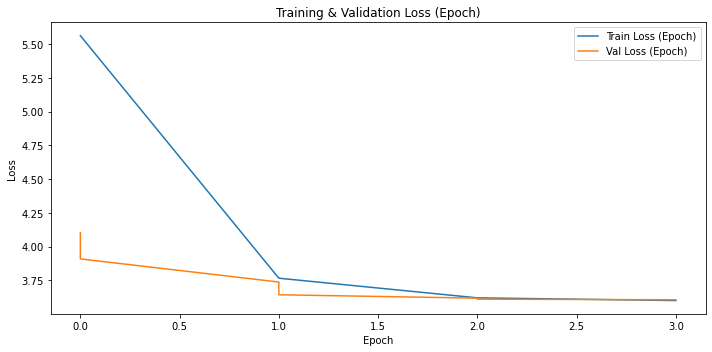

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('fsdam-s3/logs/metrics/few_shot/metrics.csv')


train = df[['epoch', 'train_loss_epoch']].dropna().rename(columns={'train_loss_epoch': 'train_loss'})
val = df[['epoch', 'val_loss_epoch']].dropna().rename(columns={'val_loss_epoch': 'val_loss'})

# Merge on epoch
merged = pd.merge(train, val, on='epoch', how='outer').sort_values('epoch')
print(merged.head(10))

plt.figure(figsize=(10,5))
plt.plot(merged['epoch'], merged['train_loss'], label='Train Loss (Epoch)')
plt.plot(merged['epoch'], merged['val_loss'], label='Val Loss (Epoch)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss (Epoch)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import torch
import os
import json
from PIL import Image
from transformers import AutoProcessor, BitsAndBytesConfig, LlavaNextForConditionalGeneration
from peft import PeftModel
from torchmetrics.text import ROUGEScore
import logging
import gc

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Define paths and constants
MODEL_ID = "llava-hf/llava-v1.6-vicuna-7b-hf"
CHECKPOINT_DIR = "fsdam-s3/logs"
LORA_CHECKPOINT_DIR = os.path.join(CHECKPOINT_DIR, "lora_weights_few_shot")
TEST_JSON = "fsdam/test_set/test_llava.json"
TEST_IMAGE_DIR = "fsdam/test_set/test"
OUTPUT_JSON = "fsdam-s3/logs/predictions_few_shot.json"
MAX_NEW_TOKENS = 512

# Load processor
try:
    processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
    processor.tokenizer.padding_side = "left"
    if processor.tokenizer.pad_token is None or processor.tokenizer.pad_token == "<unk>":
        processor.tokenizer.pad_token = processor.tokenizer.eos_token
        processor.tokenizer.pad_token_id = processor.tokenizer.eos_token_id
    logger.info("Pad token: %s", processor.tokenizer.pad_token)
except Exception as e:
    logger.error("Error loading processor: %s", e)
    raise e

# Load fine-tuned model
try:
    if not os.path.exists(LORA_CHECKPOINT_DIR):
        raise FileNotFoundError(f"LoRA checkpoint directory not found at {LORA_CHECKPOINT_DIR}")
    bnb_cfg = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16
    )
    base_model = LlavaNextForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        quantization_config=bnb_cfg,
        trust_remote_code=True
    )
    model = PeftModel.from_pretrained(
        base_model,
        LORA_CHECKPOINT_DIR,
        is_trainable=False,
        torch_dtype=torch.float16
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    logger.info("Model loaded from %s and moved to %s", LORA_CHECKPOINT_DIR, device)
except Exception as e:
    logger.error("Error loading model: %s", e)
    raise e

# Batch inference function
def predict_batch(image_paths, prompt=None, batch_size=2):
    logger.info("Processing batch of %d images", len(image_paths))
    try:
        prompt = prompt or "[INST] <image>\nDescribe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST]"
        predictions = []
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            batch_images = [Image.open(path).convert("RGB").resize((336, 336)) for path in batch_paths]
            batch_prompts = [prompt] * len(batch_paths)
            inputs = processor(
                text=batch_prompts,
                images=batch_images,
                return_tensors="pt",
                padding=True,
                truncation=False
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}
            logger.info("Batch input shapes: input_ids=%s, pixel_values=%s", 
                        inputs['input_ids'].shape, inputs['pixel_values'].shape)
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=MAX_NEW_TOKENS,
                    do_sample=False,
                    pad_token_id=processor.tokenizer.pad_token_id,
                    eos_token_id=processor.tokenizer.eos_token_id,
                    min_length=10
                )
            batch_predictions = processor.batch_decode(outputs, skip_special_tokens=True)
            batch_predictions = [p.split("[/INST]")[-1].strip() if "[/INST]" in p else p for p in batch_predictions]
            predictions.extend(batch_predictions)
            logger.info("Batch predictions: %s...", batch_predictions[0][:100])
            torch.cuda.empty_cache()  # Clear memory after each batch
        return predictions
    except Exception as e:
        logger.error("Error in batch inference: %s", e)
        return [None] * len(image_paths)

# Batch inference on test dataset
def run_batch_inference(json_path, image_dir):
    try:
        with open(json_path, 'r') as f:
            test_data = json.load(f)
        logger.info("Loaded test JSON with %d entries", len(test_data))
    except Exception as e:
        logger.error("Error loading test JSON %s: %s", json_path, e)
        raise e

    image_paths = [os.path.join(image_dir, os.path.basename(item['image'])) for item in test_data]
    predictions = predict_batch(image_paths, batch_size=2)
    results = []
    rouge = ROUGEScore()
    rouge_scores = []

    for item, prediction in zip(test_data, predictions):
        ground_truth = None
        if 'conversations' in item:
            for conv in item['conversations']:
                if conv.get('from') == 'gpt':
                    ground_truth = conv['value']
                    break
        elif 'response' in item:
            ground_truth = item['response']
        elif 'answer' in item:
            ground_truth = item['answer']
        if ground_truth is None:
            logger.warning("No ground truth found for item %s", item['id'])
        if prediction is not None:
            results.append({
                "id": item['id'],
                "image": item['image'],
                "ground_truth": ground_truth,
                "prediction": prediction
            })
            if ground_truth:
                score = rouge([prediction], [ground_truth])['rougeL_fmeasure']
                rouge_scores.append(score)
        else:
            logger.warning("Skipping item %s due to inference error", item['id'])

    # Save predictions
    os.makedirs(os.path.dirname(OUTPUT_JSON), exist_ok=True)
    with open(OUTPUT_JSON, 'w') as f:
        json.dump(results, f, indent=2)
    logger.info("Predictions saved to %s", OUTPUT_JSON)

    # Log ROUGE scores
    if rouge_scores:
        avg_rouge = sum(rouge_scores) / len(rouge_scores)
        logger.info("Average ROUGE-L: %f", avg_rouge)
    else:
        logger.info("No ROUGE scores computed (no ground truth available)")

    # Clean up memory
    torch.cuda.empty_cache()
    gc.collect()
    return results

# Run inference
if __name__ == "__main__":
    predictions = run_batch_inference(TEST_JSON, TEST_IMAGE_DIR)
    logger.info("Inference completed. %d predictions generated.", len(predictions))

INFO:__main__:Pad token: </s>
Loading checkpoint shards: 100%|██████████| 3/3 [00:08<00:00,  2.97s/it]
INFO:__main__:Model loaded from fsdam-s3/logs/lora_weights_few_shot and moved to cuda
INFO:__main__:Loaded test JSON with 81 entries
INFO:__main__:Processing batch of 81 images
INFO:__main__:Batch input shapes: input_ids=torch.Size([2, 1210]), pixel_values=torch.Size([2, 3, 3, 336, 336])
INFO:__main__:Batch predictions: The scene shows a city street with cars and buildings. The current gaze focuses on the blue car in t...
INFO:__main__:Batch input shapes: input_ids=torch.Size([2, 1210]), pixel_values=torch.Size([2, 3, 3, 336, 336])
INFO:__main__:Batch predictions: The scene shows a city street with cars, buildings, and a traffic light. The current gaze focuses on...
INFO:__main__:Batch input shapes: input_ids=torch.Size([2, 1210]), pixel_values=torch.Size([2, 3, 3, 336, 336])


In [ ]:
import json
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
from tqdm import tqdm
import nltk


nltk.download('punkt')

# Json path
PRED_PATH = 'fsdam-s3/logs/predictions_few_shot.json'

with open(PRED_PATH, 'r') as f:
    data = json.load(f)

results = []


rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
smoothie = SmoothingFunction().method4

for entry in tqdm(data, desc="Scoring predictions"):
    gt = entry['ground_truth'].strip()
    pr = entry['prediction'].strip()

    # ROUGE-L
    rougeL = rouge.score(gt, pr)['rougeL'].fmeasure

    # BLEU-4
    bleu4 = sentence_bleu([word_tokenize(gt)], word_tokenize(pr), smoothing_function=smoothie)
    
    # METEOR
    meteor = meteor_score([word_tokenize(gt)], word_tokenize(pr))
    
    # Exact Match
    exact = int(gt == pr)

    results.append({
        "id": entry['id'],
        "image": entry['image'],
        "ground_truth": gt,
        "prediction": pr,
        "ROUGE-L": rougeL,
        "BLEU-4": bleu4,
        "METEOR": meteor,
        "Exact Match": exact
    })

# Convert to DataFrame
df = pd.DataFrame(results)

# Print mean scores
print("\n==== FSDAM Test Metrics ====\n")
print(df[["ROUGE-L", "BLEU-4", "METEOR", "Exact Match"]].mean())
print("\n==== Per-sample Results (first 5) ====\n")
print(df.head())

# Save detailed results as CSV if needed
df.to_csv('fsdam-s3/logs/test_metrics_few_shot.csv', index=False)

In [81]:
import torch
import gc

torch.cuda.empty_cache()
gc.collect()



0

# ONE SHOT

In [28]:
import torch
import os
import json
import gc
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, BitsAndBytesConfig, LlavaNextForConditionalGeneration
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
import lightning.pytorch as L
from torchmetrics.text import ROUGEScore
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
import logging

# Set environment variables
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
file_handler = logging.FileHandler("fsdam-s3/logs/one_shot_training.log")
file_handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Set mixed precision
torch.set_float32_matmul_precision('medium')

# Clear GPU memory
torch.cuda.empty_cache()
gc.collect()

# Define paths and constants
MODEL_ID = "llava-hf/llava-v1.6-vicuna-7b-hf"
DATASET_DIR = "fsdam"
ONE_SHOT_DIR = os.path.join(DATASET_DIR, "one_shot")
TEST_DIR = os.path.join(DATASET_DIR, "test_set")
TRAIN_JSON_ONE = os.path.join(ONE_SHOT_DIR, "train_llava.json")
VAL_JSON = os.path.join(ONE_SHOT_DIR, "val_llava.json")
TEST_JSON = os.path.join(TEST_DIR, "test_llava.json")
CHECKPOINT_DIR = "fsdam-s3/logs"
LORA_CHECKPOINT_DIR = os.path.join(CHECKPOINT_DIR, "lora_weights_one_shot")
MAX_LENGTH = 2048

# Create checkpoint directories
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(LORA_CHECKPOINT_DIR, exist_ok=True)

# Verify paths
logger.info("One-shot train JSON exists: %s", os.path.exists(TRAIN_JSON_ONE))
logger.info("Val JSON exists: %s", os.path.exists(VAL_JSON))
logger.info("Test JSON exists: %s", os.path.exists(TEST_JSON))

# Load processor and model
try:
    processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
    processor.tokenizer.padding_side = "left"
    if processor.tokenizer.pad_token is None or processor.tokenizer.pad_token == "<unk>":
        processor.tokenizer.pad_token = processor.tokenizer.eos_token
        processor.tokenizer.pad_token_id = processor.tokenizer.eos_token_id
    logger.info("Pad token: %s", processor.tokenizer.pad_token)

    bnb_cfg = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16
    )
    model = LlavaNextForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        quantization_config=bnb_cfg,
        trust_remote_code=True
    )
except Exception as e:
    logger.error("Error loading model or processor: %s", e)
    raise e

# Configure LoRA with higher learning capacity for one-shot
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)
lora_config = LoraConfig(
    r=8,  #8
    lora_alpha=4,  #4
    lora_dropout=0.02,  # Reduced dropout #0.05
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "multi_modal_projector.linear_1", "multi_modal_projector.linear_2"],
    init_lora_weights="gaussian"
)
model = get_peft_model(model, lora_config)
model.enable_input_require_grads()

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
logger.info("Model device: %s", next(model.parameters()).device)
logger.info("Model and processor loaded successfully.")

# Define dataset class
class LlavaDataset(Dataset):
    def __init__(self, json_path, image_dir, limit_samples=None):
        try:
            with open(json_path, 'r') as f:
                self.data = json.load(f)
                # For one-shot, limit samples but don't restrict to just 1
                if limit_samples:
                    self.data = self.data[:limit_samples]
        except Exception as e:
            logger.error("Error loading JSON %s: %s", json_path, e)
            raise e
        self.image_dir = image_dir
        logger.info("Dataset from %s: %d samples", json_path, len(self.data))
        if len(self.data) > 0:
            logger.info("Sample JSON entry: %s", json.dumps(self.data[0], indent=2)[:500] + "...")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            item = self.data[idx]
            image_path = os.path.join(self.image_dir, os.path.basename(item['image']))
            
            # Debug: Check if image file exists
            if not os.path.exists(image_path):
                logger.warning("Image not found: %s", image_path)
                # Try alternative path
                image_path = os.path.join(self.image_dir, item['image'])
                if not os.path.exists(image_path):
                    raise FileNotFoundError(f"Image not found: {image_path}")
            
            if 'conversations' in item:
                for conv in item['conversations']:
                    if conv.get('from') == 'gpt':
                        return image_path, conv['value']
            if 'response' in item:
                return image_path, item['response']
            if 'answer' in item:
                return image_path, item['answer']
            raise ValueError(f"No valid response found for item {idx}: {json.dumps(item, indent=2)}")
        except Exception as e:
            logger.error("Error accessing item %d: %s", idx, e)
            raise e

# Load datasets
try:
    # For one-shot, use a small number of training examples (1-5)
    train_dataset_one_shot = LlavaDataset(TRAIN_JSON_ONE, ONE_SHOT_DIR + "/train", limit_samples=1)
    val_dataset = LlavaDataset(VAL_JSON, ONE_SHOT_DIR + "/val")
    test_dataset = LlavaDataset(TEST_JSON, TEST_DIR + "/test")
except Exception as e:
    logger.error("Dataset loading error: %s", e)
    raise e

# Debug dataset sizes
logger.info("One-shot train size: %d", len(train_dataset_one_shot))
logger.info("Val size: %d", len(val_dataset))
logger.info("Test size: %d", len(test_dataset))

# Collate function
def collate_fn(batch, processor=processor, prompt_template=None, device="cuda"):
    logger.info("Processing batch with %d samples", len(batch))
    imgs, seqs = zip(*batch)
    processed_imgs = []
    
    for img_path in imgs:
        logger.info("Loading image: %s", img_path)
        try:
            img = Image.open(img_path).convert("RGB").resize((336, 336))
            processed_imgs.append(img)
        except Exception as e:
            logger.error("Error processing image %s: %s", img_path, e)
            raise e

    prompt = prompt_template or "[INST] <image>\nDescribe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] {seq}"
    conversation_texts = [prompt.format(seq=seq) for seq in seqs]

    try:
        inputs = processor(
            text=conversation_texts,
            images=processed_imgs,
            return_tensors="pt",
            padding=True,
            truncation=True,  # Enable truncation
            max_length=MAX_LENGTH
        )
        logger.info("Input shapes: input_ids=%s, pixel_values=%s", inputs['input_ids'].shape, inputs['pixel_values'].shape)
    except Exception as e:
        logger.error("Processor error: %s", e)
        raise e

    labels = inputs["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    inputs["labels"] = labels
    inputs = {k: v.to(device) for k, v in inputs.items()}
    return inputs

# Lightning module
class LlavaModelPLModule(L.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model
        self.batch_size = config["batch_size"]
        self.rouge = ROUGEScore()

    def training_step(self, batch, batch_idx):
        logger.info("Training batch %d, size: %d", batch_idx, len(batch['input_ids']))
        outputs = self.model(**batch)
        loss = outputs.loss
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        
        # Log more details for one-shot learning
        if batch_idx == 0:
            predictions = self.processor.batch_decode(outputs.logits.argmax(-1), skip_special_tokens=True)
            logger.info("Sample Training Prediction: %s...", predictions[0][:200])
            logger.info("Training loss: %f", loss.item())
            
        return loss

    def validation_step(self, batch, batch_idx):
        logger.info("Validation batch %d, size: %d", batch_idx, len(batch['input_ids']))
        
        # Calculate validation loss first
        with torch.no_grad():
            loss_outputs = self.model(**batch)
            val_loss = loss_outputs.loss
            self.log("val_loss", val_loss, prog_bar=True, on_step=True, on_epoch=True)
        
        # Then do generation for ROUGE score
        generation_kwargs = {k: v for k, v in batch.items() if k != "labels"}
        
        with torch.no_grad():
            outputs = self.model.generate(
                **generation_kwargs,
                max_new_tokens=512,
                do_sample=False,
                pad_token_id=self.processor.tokenizer.pad_token_id,
                eos_token_id=self.processor.tokenizer.eos_token_id,
                repetition_penalty=1.1,
                no_repeat_ngram_size=3
            )
        
        predictions = self.processor.batch_decode(outputs, skip_special_tokens=True)
        valid_labels = batch["labels"].clone()
        valid_labels[valid_labels == -100] = self.processor.tokenizer.pad_token_id
        targets = self.processor.tokenizer.batch_decode(valid_labels, skip_special_tokens=True)
        targets = [t.replace(self.processor.tokenizer.pad_token, "").strip() for t in targets]
        predictions = [p.split("[/INST]")[-1].strip() if "[/INST]" in p else p for p in predictions]
        
        # Check if predictions are empty
        for i, pred in enumerate(predictions):
            if not pred.strip():
                logger.warning("Empty prediction at index %d", i)
                logger.info("Full output before processing: %s", self.processor.batch_decode([outputs[i]], skip_special_tokens=True)[0])
        
        rouge_score = self.rouge(predictions, targets)["rougeL_fmeasure"]
        self.log("val_rouge", rouge_score, prog_bar=True, on_step=True, on_epoch=True)
        
        if batch_idx == 0:
            logger.info("Sample Validation Prediction: %s...", predictions[0][:200])
            logger.info("Sample Validation Target: %s...", targets[0][:200])
            logger.info("Validation Loss: %f", val_loss.item())
            
        # Save sample predictions
        sample_output = [{"prediction": p, "target": t, "val_loss": val_loss.item()} for p, t in zip(predictions, targets)]
        with open(os.path.join(CHECKPOINT_DIR, f"val_samples_epoch_{self.current_epoch}.json"), 'a') as f:
            json.dump(sample_output, f, indent=2)
            f.write('\n')
        return {"val_rouge": rouge_score, "val_loss": val_loss}

    def configure_optimizers(self):
        # Higher learning rate for one-shot learning
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config["lr"], weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.config["max_epochs"])
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def train_dataloader(self):
        logger.info("Training dataset size: %d", len(train_dataset_one_shot))
        return DataLoader(
            train_dataset_one_shot,
            collate_fn=lambda x: collate_fn(x, processor),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )

    def val_dataloader(self):
        logger.info("Validation dataset size: %d", len(val_dataset))
        return DataLoader(
            val_dataset,
            collate_fn=lambda x: collate_fn(x, processor),
            batch_size=self.batch_size,
            num_workers=0
        )

    def on_train_epoch_start(self):
        logger.info("Starting epoch %d", self.current_epoch)

    def on_train_end(self):
        save_path = os.path.join(CHECKPOINT_DIR, "final_model_one_shot.ckpt")
        self.trainer.save_checkpoint(save_path)
        logger.info("Lightning checkpoint saved to %s", save_path)
        self.model.save_pretrained(LORA_CHECKPOINT_DIR)
        logger.info("LoRA weights saved to %s", LORA_CHECKPOINT_DIR)

# Training configuration optimized for one-shot learning
config = {
    "max_epochs": 20,  
    "lr": 1e-3,  
    "batch_size": 1, 
    "use_contrastive": False, 
    "contrastive_weight": 0.05
}

# Train with early stopping, checkpointing, and CSV logging
trainer = L.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=config["max_epochs"],
    precision="16-mixed",
    val_check_interval=0.5,
    enable_checkpointing=True,
    enable_progress_bar=True,
    log_every_n_steps=1,
    default_root_dir=CHECKPOINT_DIR,
    logger=CSVLogger(save_dir=CHECKPOINT_DIR, name="metrics", version="one_shot"),
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min", patience=5),
        ModelCheckpoint(
            dirpath=CHECKPOINT_DIR,
            filename="best_model_one_shot_{epoch}_{val_loss:.3f}_{val_rouge:.3f}",
            monitor="val_loss",  
            mode="min",
            save_top_k=3  
        )
    ],
    gradient_clip_val=1.0
)

# Initialize and train model
llava_module = LlavaModelPLModule(config, processor, model)
trainer.fit(llava_module)
logger.info("One-shot training completed.")

# Clean up memory
torch.cuda.empty_cache()
gc.collect()

INFO:__main__:One-shot train JSON exists: True
INFO:__main__:Val JSON exists: True
INFO:__main__:Test JSON exists: True
INFO:__main__:Pad token: </s>
Loading checkpoint shards: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]
INFO:__main__:Model device: cuda:0
INFO:__main__:Model and processor loaded successfully.
INFO:__main__:Dataset from fsdam/one_shot/train_llava.json: 1 samples
INFO:__main__:Sample JSON entry: {
  "id": "1006_00018",
  "image": "fsdam/one_shot/train/1006_00018.png",
  "conversations": [
    {
      "from": "human",
      "value": "<image> Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why."
    },
    {
      "from": "gpt",
      "value": "A street lined with palm trees and houses is visible, with a green traffic light. The current gaze focuses on the green light and the road ahead. The gaze will likely shift to the approaching intersecti...
INFO:__main__:Dataset from fsdam/one_shot/val_llava.json: 20 samples
INFO:__main

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Validation dataset size: 20
/home/ubuntu/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=25` in the `DataLoader` to improve performance.
INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00085.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 1
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. The current gaze focuses on the car in front. The future gaze will likely shift to the traffic light. ...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] The scene shows a busy urban intersection with cars, buildings, and a yellow traffic l...
INFO:__main__:Validation Loss: 14.732455


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00287.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1293]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 1


INFO:__main__:Training dataset size: 1
/home/ubuntu/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=25` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

INFO:__main__:Starting epoch 0
INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/train/1006_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1271]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 1
INFO:__main__:Sample Training Prediction: sierp…ALL
1
, m.m
mm trees trees trees... day2 of trees. The, day pal treesmt palmm and sky sky day trees trees,, The0 from trees pal palm trees,ing,,.. Miami A. ofmmt trees. oft of..0 y Palday light....
INFO:__main__:Training loss: 15.448358


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s, v_num=shot, train_loss_step=15.40]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00085.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 1
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. The current gaze focuses on the car in front. The future gaze will likely shift to the traffic light. ...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] The scene shows a busy urban intersection with cars, buildings, and a yellow traffic l...
INFO:__main__:Validation Loss: 14.732455



Validation DataLoader 0:   5%|▌         | 1/20 [00:00<00:07,  2.38it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00287.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1293]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 1



Validation DataLoader 0:  10%|█         | 2/20 [00:02<00:18,  0.96it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00119.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 1



Validation DataLoader 0:  15%|█▌        | 3/20 [00:02<00:14,  1.18it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00219.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1262]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 1



Validation DataLoader 0:  20%|██        | 4/20 [00:02<00:11,  1.34it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1746_00008.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 1



Validation DataLoader 0:  25%|██▌       | 5/20 [00:04<00:13,  1.14it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1747_00012.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 5, size: 1



Validation DataLoader 0:  30%|███       | 6/20 [00:04<00:11,  1.24it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 6, size: 1



Validation DataLoader 0:  35%|███▌      | 7/20 [00:05<00:09,  1.32it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00243.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1277]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 7, size: 1



Validation DataLoader 0:  40%|████      | 8/20 [00:05<00:08,  1.39it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1753_00160.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1283]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 8, size: 1



Validation DataLoader 0:  45%|████▌     | 9/20 [00:07<00:09,  1.17it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1754_00079.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1292]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 9, size: 1



Validation DataLoader 0:  50%|█████     | 10/20 [00:08<00:08,  1.22it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1755_00078.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 10, size: 1



Validation DataLoader 0:  55%|█████▌    | 11/20 [00:09<00:07,  1.14it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1756_00013.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1287]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 11, size: 1



Validation DataLoader 0:  60%|██████    | 12/20 [00:10<00:06,  1.19it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1760_00071.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1280]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 12, size: 1



Validation DataLoader 0:  65%|██████▌   | 13/20 [00:10<00:05,  1.23it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1761_00005.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1285]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 13, size: 1



Validation DataLoader 0:  70%|███████   | 14/20 [00:11<00:04,  1.27it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1764_00032.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1274]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 14, size: 1



Validation DataLoader 0:  75%|███████▌  | 15/20 [00:12<00:04,  1.18it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1767_00017.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1281]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 15, size: 1



Validation DataLoader 0:  80%|████████  | 16/20 [00:13<00:03,  1.22it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1768_00239.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1304]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 16, size: 1



Validation DataLoader 0:  85%|████████▌ | 17/20 [00:13<00:02,  1.25it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1771_00259.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1295]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 17, size: 1



Validation DataLoader 0:  90%|█████████ | 18/20 [00:14<00:01,  1.26it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1772_00192.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1299]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 18, size: 1



Validation DataLoader 0:  95%|█████████▌| 19/20 [00:14<00:00,  1.29it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1773_00089.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1275]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 19, size: 1



Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=shot, train_loss_step=15.40, val_loss_step=15.20, val_rouge_step=0.836, val_loss_epoch=15.00, val_rouge_epoch=0.822, train_loss_epoch=15.40]        

INFO:__main__:Starting epoch 1
INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/train/1006_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1271]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 1
INFO:__main__:Sample Training Prediction: sierp…ALL
1
, m.m
mm trees trees trees... day2 of trees. The, day pal treesmt palmm and sky sky day trees trees,, The0 from trees pal palm trees,ing,,.. Miami A. ofmmt trees. oft of..0 y Palday light....
INFO:__main__:Training loss: 15.448358


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, v_num=shot, train_loss_step=15.40, val_loss_step=15.20, val_rouge_step=0.836, val_loss_epoch=15.00, val_rouge_epoch=0.822, train_loss_epoch=15.40]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00085.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 1
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. The current gaze focuses on the car in front. The future gaze will likely shift to the traffic light. ...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] The scene shows a busy urban intersection with cars, buildings, and a yellow traffic l...
INFO:__main__:Validation Loss: 14.732455



Validation DataLoader 0:   5%|▌         | 1/20 [00:00<00:08,  2.31it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00287.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1293]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 1



Validation DataLoader 0:  10%|█         | 2/20 [00:02<00:18,  0.95it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00119.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 1



Validation DataLoader 0:  15%|█▌        | 3/20 [00:02<00:14,  1.18it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00219.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1262]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 1



Validation DataLoader 0:  20%|██        | 4/20 [00:02<00:11,  1.34it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1746_00008.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 1



Validation DataLoader 0:  25%|██▌       | 5/20 [00:04<00:14,  1.07it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1747_00012.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 5, size: 1



Validation DataLoader 0:  30%|███       | 6/20 [00:05<00:12,  1.16it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 6, size: 1



Validation DataLoader 0:  35%|███▌      | 7/20 [00:05<00:10,  1.23it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00243.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1277]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 7, size: 1



Validation DataLoader 0:  40%|████      | 8/20 [00:06<00:09,  1.29it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1753_00160.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1283]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 8, size: 1



Validation DataLoader 0:  45%|████▌     | 9/20 [00:08<00:10,  1.06it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1754_00079.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1292]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 9, size: 1



Validation DataLoader 0:  50%|█████     | 10/20 [00:08<00:08,  1.12it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1755_00078.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 10, size: 1



Validation DataLoader 0:  55%|█████▌    | 11/20 [00:10<00:08,  1.06it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1756_00013.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1287]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 11, size: 1



Validation DataLoader 0:  60%|██████    | 12/20 [00:10<00:07,  1.11it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1760_00071.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1280]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 12, size: 1



Validation DataLoader 0:  65%|██████▌   | 13/20 [00:11<00:06,  1.16it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1761_00005.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1285]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 13, size: 1



Validation DataLoader 0:  70%|███████   | 14/20 [00:11<00:05,  1.20it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1764_00032.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1274]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 14, size: 1



Validation DataLoader 0:  75%|███████▌  | 15/20 [00:13<00:04,  1.13it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1767_00017.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1281]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 15, size: 1



Validation DataLoader 0:  80%|████████  | 16/20 [00:13<00:03,  1.16it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1768_00239.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1304]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 16, size: 1



Validation DataLoader 0:  85%|████████▌ | 17/20 [00:14<00:02,  1.19it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1771_00259.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1295]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 17, size: 1



Validation DataLoader 0:  90%|█████████ | 18/20 [00:14<00:01,  1.21it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1772_00192.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1299]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 18, size: 1



Validation DataLoader 0:  95%|█████████▌| 19/20 [00:15<00:00,  1.24it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1773_00089.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1275]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 19, size: 1



Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=shot, train_loss_step=15.40, val_loss_step=15.20, val_rouge_step=0.836, val_loss_epoch=15.00, val_rouge_epoch=0.822, train_loss_epoch=15.40]        

INFO:__main__:Starting epoch 2
INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/train/1006_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1271]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 1
INFO:__main__:Sample Training Prediction: sierp…ALL
1
, m.m
mm trees trees trees... day2 of trees. The, day pal treesmt palmm and sky sky day trees trees,, The0 from trees pal palm trees,ing,,.. Miami A. ofmmt trees. oft of..0 y Palday light....
INFO:__main__:Training loss: 15.448358


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s, v_num=shot, train_loss_step=15.40, val_loss_step=15.20, val_rouge_step=0.836, val_loss_epoch=15.00, val_rouge_epoch=0.822, train_loss_epoch=15.40]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00085.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 1
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. The current gaze focuses on the car in front. The future gaze will likely shift to the traffic light. ...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] The scene shows a busy urban intersection with cars, buildings, and a yellow traffic l...
INFO:__main__:Validation Loss: 14.732455



Validation DataLoader 0:   5%|▌         | 1/20 [00:00<00:08,  2.29it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00287.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1293]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 1



Validation DataLoader 0:  10%|█         | 2/20 [00:02<00:18,  0.98it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00119.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 1



Validation DataLoader 0:  15%|█▌        | 3/20 [00:02<00:14,  1.20it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00219.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1262]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 1



Validation DataLoader 0:  20%|██        | 4/20 [00:02<00:11,  1.36it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1746_00008.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 1



Validation DataLoader 0:  25%|██▌       | 5/20 [00:04<00:12,  1.16it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1747_00012.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 5, size: 1



Validation DataLoader 0:  30%|███       | 6/20 [00:04<00:11,  1.26it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 6, size: 1



Validation DataLoader 0:  35%|███▌      | 7/20 [00:05<00:09,  1.34it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00243.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1277]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 7, size: 1



Validation DataLoader 0:  40%|████      | 8/20 [00:05<00:08,  1.41it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1753_00160.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1283]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 8, size: 1



Validation DataLoader 0:  45%|████▌     | 9/20 [00:07<00:09,  1.19it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1754_00079.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1292]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 9, size: 1



Validation DataLoader 0:  50%|█████     | 10/20 [00:08<00:08,  1.24it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1755_00078.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 10, size: 1



Validation DataLoader 0:  55%|█████▌    | 11/20 [00:09<00:07,  1.16it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1756_00013.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1287]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 11, size: 1



Validation DataLoader 0:  60%|██████    | 12/20 [00:09<00:06,  1.21it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1760_00071.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1280]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 12, size: 1



Validation DataLoader 0:  65%|██████▌   | 13/20 [00:10<00:05,  1.25it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1761_00005.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1285]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 13, size: 1



Validation DataLoader 0:  70%|███████   | 14/20 [00:10<00:04,  1.29it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1764_00032.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1274]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 14, size: 1



Validation DataLoader 0:  75%|███████▌  | 15/20 [00:12<00:04,  1.20it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1767_00017.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1281]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 15, size: 1



Validation DataLoader 0:  80%|████████  | 16/20 [00:12<00:03,  1.24it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1768_00239.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1304]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 16, size: 1



Validation DataLoader 0:  85%|████████▌ | 17/20 [00:13<00:02,  1.27it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1771_00259.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1295]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 17, size: 1



Validation DataLoader 0:  90%|█████████ | 18/20 [00:14<00:01,  1.28it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1772_00192.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1299]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 18, size: 1



Validation DataLoader 0:  95%|█████████▌| 19/20 [00:14<00:00,  1.31it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1773_00089.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1275]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 19, size: 1



Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=shot, train_loss_step=15.40, val_loss_step=15.20, val_rouge_step=0.836, val_loss_epoch=15.00, val_rouge_epoch=0.822, train_loss_epoch=15.40]        

INFO:__main__:Starting epoch 3
INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/train/1006_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1271]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 1
INFO:__main__:Sample Training Prediction: sierp…ALL
1
, m.m
mm trees trees trees... day2 of trees. The, day pal treesmt palmm and sky sky day trees trees,, The0 from trees pal palm trees,ing,,.. Miami A. ofmmt trees. oft of..0 y Palday light....
INFO:__main__:Training loss: 15.448358


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s, v_num=shot, train_loss_step=15.40, val_loss_step=15.20, val_rouge_step=0.836, val_loss_epoch=15.00, val_rouge_epoch=0.822, train_loss_epoch=15.40]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00085.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 1
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. The current gaze focuses on the car in front. The future gaze will likely shift to the traffic light. ...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] The scene shows a busy urban intersection with cars, buildings, and a yellow traffic l...
INFO:__main__:Validation Loss: 14.732455



Validation DataLoader 0:   5%|▌         | 1/20 [00:00<00:08,  2.34it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00287.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1293]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 1



Validation DataLoader 0:  10%|█         | 2/20 [00:02<00:18,  0.98it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00119.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 1



Validation DataLoader 0:  15%|█▌        | 3/20 [00:02<00:14,  1.21it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00219.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1262]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 1



Validation DataLoader 0:  20%|██        | 4/20 [00:02<00:11,  1.36it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1746_00008.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 1



Validation DataLoader 0:  25%|██▌       | 5/20 [00:04<00:12,  1.16it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1747_00012.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 5, size: 1



Validation DataLoader 0:  30%|███       | 6/20 [00:04<00:11,  1.26it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 6, size: 1



Validation DataLoader 0:  35%|███▌      | 7/20 [00:05<00:09,  1.34it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00243.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1277]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 7, size: 1



Validation DataLoader 0:  40%|████      | 8/20 [00:05<00:08,  1.41it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1753_00160.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1283]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 8, size: 1



Validation DataLoader 0:  45%|████▌     | 9/20 [00:07<00:09,  1.19it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1754_00079.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1292]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 9, size: 1



Validation DataLoader 0:  50%|█████     | 10/20 [00:08<00:08,  1.24it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1755_00078.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 10, size: 1



Validation DataLoader 0:  55%|█████▌    | 11/20 [00:09<00:07,  1.16it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1756_00013.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1287]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 11, size: 1



Validation DataLoader 0:  60%|██████    | 12/20 [00:09<00:06,  1.21it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1760_00071.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1280]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 12, size: 1



Validation DataLoader 0:  65%|██████▌   | 13/20 [00:10<00:05,  1.25it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1761_00005.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1285]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 13, size: 1



Validation DataLoader 0:  70%|███████   | 14/20 [00:10<00:04,  1.29it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1764_00032.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1274]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 14, size: 1



Validation DataLoader 0:  75%|███████▌  | 15/20 [00:12<00:04,  1.20it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1767_00017.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1281]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 15, size: 1



Validation DataLoader 0:  80%|████████  | 16/20 [00:12<00:03,  1.23it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1768_00239.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1304]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 16, size: 1



Validation DataLoader 0:  85%|████████▌ | 17/20 [00:13<00:02,  1.27it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1771_00259.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1295]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 17, size: 1



Validation DataLoader 0:  90%|█████████ | 18/20 [00:14<00:01,  1.28it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1772_00192.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1299]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 18, size: 1



Validation DataLoader 0:  95%|█████████▌| 19/20 [00:14<00:00,  1.30it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1773_00089.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1275]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 19, size: 1



Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=shot, train_loss_step=15.40, val_loss_step=15.20, val_rouge_step=0.836, val_loss_epoch=15.00, val_rouge_epoch=0.822, train_loss_epoch=15.40]        

INFO:__main__:Starting epoch 4
INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/train/1006_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1271]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 1
INFO:__main__:Sample Training Prediction: sierp…ALL
1
, m.m
mm trees trees trees... day2 of trees. The, day pal treesmt palmm and sky sky day trees trees,, The0 from trees pal palm trees,ing,,.. Miami A. ofmmt trees. oft of..0 y Palday light....
INFO:__main__:Training loss: 15.448358


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, v_num=shot, train_loss_step=15.40, val_loss_step=15.20, val_rouge_step=0.836, val_loss_epoch=15.00, val_rouge_epoch=0.822, train_loss_epoch=15.40]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00085.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 1
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. The current gaze focuses on the car in front. The future gaze will likely shift to the traffic light. ...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] The scene shows a busy urban intersection with cars, buildings, and a yellow traffic l...
INFO:__main__:Validation Loss: 9.022706



Validation DataLoader 0:   5%|▌         | 1/20 [00:00<00:08,  2.34it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00287.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1293]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 1



Validation DataLoader 0:  10%|█         | 2/20 [00:02<00:18,  0.96it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00119.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 1



Validation DataLoader 0:  15%|█▌        | 3/20 [00:02<00:14,  1.18it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00219.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1262]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 1



Validation DataLoader 0:  20%|██        | 4/20 [00:02<00:11,  1.34it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1746_00008.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 1



Validation DataLoader 0:  25%|██▌       | 5/20 [00:03<00:10,  1.45it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1747_00012.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 5, size: 1



Validation DataLoader 0:  30%|███       | 6/20 [00:03<00:09,  1.54it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 6, size: 1



Validation DataLoader 0:  35%|███▌      | 7/20 [00:04<00:08,  1.61it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00243.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1277]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 7, size: 1



Validation DataLoader 0:  40%|████      | 8/20 [00:04<00:07,  1.66it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1753_00160.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1283]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 8, size: 1



Validation DataLoader 0:  45%|████▌     | 9/20 [00:05<00:06,  1.71it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1754_00079.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1292]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 9, size: 1



Validation DataLoader 0:  50%|█████     | 10/20 [00:05<00:05,  1.74it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1755_00078.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 10, size: 1



Validation DataLoader 0:  55%|█████▌    | 11/20 [00:07<00:05,  1.53it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1756_00013.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1287]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 11, size: 1



Validation DataLoader 0:  60%|██████    | 12/20 [00:07<00:05,  1.57it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1760_00071.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1280]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 12, size: 1



Validation DataLoader 0:  65%|██████▌   | 13/20 [00:08<00:04,  1.61it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1761_00005.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1285]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 13, size: 1



Validation DataLoader 0:  70%|███████   | 14/20 [00:08<00:03,  1.64it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1764_00032.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1274]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 14, size: 1



Validation DataLoader 0:  75%|███████▌  | 15/20 [00:10<00:03,  1.48it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1767_00017.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1281]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 15, size: 1



Validation DataLoader 0:  80%|████████  | 16/20 [00:10<00:02,  1.51it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1768_00239.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1304]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 16, size: 1



Validation DataLoader 0:  85%|████████▌ | 17/20 [00:11<00:01,  1.53it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1771_00259.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1295]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 17, size: 1



Validation DataLoader 0:  90%|█████████ | 18/20 [00:11<00:01,  1.51it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1772_00192.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1299]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 18, size: 1



Validation DataLoader 0:  95%|█████████▌| 19/20 [00:12<00:00,  1.53it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1773_00089.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1275]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 19, size: 1



Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=shot, train_loss_step=15.40, val_loss_step=9.260, val_rouge_step=0.836, val_loss_epoch=9.180, val_rouge_epoch=0.833, train_loss_epoch=15.40]        

INFO:__main__:Starting epoch 5
INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/train/1006_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1271]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 1
INFO:__main__:Sample Training Prediction: sierp…IT
1
ideymtm2mmero r.0202.   t  0dayetmm01mia,9 8002es220ankalkort2ing2:091a0202mmt trees0tsow0. trees200es2dayens.ammyyymino1.ing10 W 2s.as.angingmestymitoosestyest)inging1121.asagesetsas light...
INFO:__main__:Training loss: 9.073468


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s, v_num=shot, train_loss_step=9.070, val_loss_step=9.260, val_rouge_step=0.836, val_loss_epoch=9.180, val_rouge_epoch=0.833, train_loss_epoch=15.40]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00085.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 1
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. The current gaze focuses on the car in front. The future gaze will likely shift to the traffic light. ...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] The scene shows a busy urban intersection with cars, buildings, and a yellow traffic l...
INFO:__main__:Validation Loss: 6.514228



Validation DataLoader 0:   5%|▌         | 1/20 [00:00<00:08,  2.13it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00287.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1293]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 1



Validation DataLoader 0:  10%|█         | 2/20 [00:02<00:23,  0.76it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00119.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 1



Validation DataLoader 0:  15%|█▌        | 3/20 [00:03<00:17,  0.95it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00219.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1262]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 1



Validation DataLoader 0:  20%|██        | 4/20 [00:03<00:14,  1.09it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1746_00008.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 1



Validation DataLoader 0:  25%|██▌       | 5/20 [00:04<00:12,  1.20it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1747_00012.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 5, size: 1



Validation DataLoader 0:  30%|███       | 6/20 [00:04<00:10,  1.29it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 6, size: 1



Validation DataLoader 0:  35%|███▌      | 7/20 [00:05<00:09,  1.37it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00243.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1277]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 7, size: 1



Validation DataLoader 0:  40%|████      | 8/20 [00:05<00:08,  1.44it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1753_00160.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1283]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 8, size: 1



Validation DataLoader 0:  45%|████▌     | 9/20 [00:06<00:07,  1.49it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1754_00079.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1292]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 9, size: 1



Validation DataLoader 0:  50%|█████     | 10/20 [00:06<00:06,  1.54it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1755_00078.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 10, size: 1



Validation DataLoader 0:  55%|█████▌    | 11/20 [00:07<00:06,  1.40it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1756_00013.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1287]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 11, size: 1



Validation DataLoader 0:  60%|██████    | 12/20 [00:08<00:05,  1.44it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1760_00071.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1280]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 12, size: 1



Validation DataLoader 0:  65%|██████▌   | 13/20 [00:08<00:04,  1.48it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1761_00005.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1285]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 13, size: 1



Validation DataLoader 0:  70%|███████   | 14/20 [00:09<00:03,  1.51it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1764_00032.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1274]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 14, size: 1



Validation DataLoader 0:  75%|███████▌  | 15/20 [00:10<00:03,  1.37it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1767_00017.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1281]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 15, size: 1



Validation DataLoader 0:  80%|████████  | 16/20 [00:11<00:02,  1.41it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1768_00239.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1304]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 16, size: 1



Validation DataLoader 0:  85%|████████▌ | 17/20 [00:11<00:02,  1.43it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1771_00259.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1295]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 17, size: 1



Validation DataLoader 0:  90%|█████████ | 18/20 [00:13<00:01,  1.34it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1772_00192.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1299]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 18, size: 1



Validation DataLoader 0:  95%|█████████▌| 19/20 [00:13<00:00,  1.37it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1773_00089.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1275]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 19, size: 1



Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=shot, train_loss_step=9.070, val_loss_step=6.480, val_rouge_step=0.836, val_loss_epoch=6.490, val_rouge_epoch=0.829, train_loss_epoch=9.070]        

INFO:__main__:Starting epoch 6
INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/train/1006_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1271]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 1
INFO:__main__:Sample Training Prediction: Unterscheidung…IT
1..inm[ig2mm [0..s1.2.q" t" .."ia.an1.ia.q.{m".t   ],.."2. [p " .{s [...""2itot. [�lt�.." 1A.asasat paly..inoos.g.ing �. ...1..w pal .os.osesyl. ing 211..et..asatedy. Pal.ito. ....2 ...
INFO:__main__:Training loss: 6.544812


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s, v_num=shot, train_loss_step=6.540, val_loss_step=6.480, val_rouge_step=0.836, val_loss_epoch=6.490, val_rouge_epoch=0.829, train_loss_epoch=9.070]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00085.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 1
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. The current gaze focuses on the car in front. The future gaze will likely shift to the traffic light. ...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] The scene shows a busy urban intersection with cars, buildings, and a yellow traffic l...
INFO:__main__:Validation Loss: 4.790903



Validation DataLoader 0:   5%|▌         | 1/20 [00:00<00:08,  2.32it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00287.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1293]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 1



Validation DataLoader 0:  10%|█         | 2/20 [00:02<00:18,  0.99it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00119.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 1



Validation DataLoader 0:  15%|█▌        | 3/20 [00:02<00:14,  1.21it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00219.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1262]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 1



Validation DataLoader 0:  20%|██        | 4/20 [00:02<00:11,  1.37it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1746_00008.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 1



Validation DataLoader 0:  25%|██▌       | 5/20 [00:03<00:10,  1.47it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1747_00012.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 5, size: 1



Validation DataLoader 0:  30%|███       | 6/20 [00:03<00:08,  1.56it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 6, size: 1



Validation DataLoader 0:  35%|███▌      | 7/20 [00:04<00:08,  1.62it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00243.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1277]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 7, size: 1



Validation DataLoader 0:  40%|████      | 8/20 [00:04<00:07,  1.67it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1753_00160.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1283]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 8, size: 1



Validation DataLoader 0:  45%|████▌     | 9/20 [00:05<00:06,  1.72it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1754_00079.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1292]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 9, size: 1



Validation DataLoader 0:  50%|█████     | 10/20 [00:05<00:05,  1.75it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1755_00078.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 10, size: 1



Validation DataLoader 0:  55%|█████▌    | 11/20 [00:07<00:05,  1.55it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1756_00013.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1287]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 11, size: 1



Validation DataLoader 0:  60%|██████    | 12/20 [00:07<00:05,  1.58it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1760_00071.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1280]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 12, size: 1



Validation DataLoader 0:  65%|██████▌   | 13/20 [00:08<00:04,  1.62it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1761_00005.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1285]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 13, size: 1



Validation DataLoader 0:  70%|███████   | 14/20 [00:08<00:03,  1.65it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1764_00032.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1274]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 14, size: 1



Validation DataLoader 0:  75%|███████▌  | 15/20 [00:09<00:03,  1.53it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1767_00017.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1281]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 15, size: 1



Validation DataLoader 0:  80%|████████  | 16/20 [00:10<00:02,  1.56it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1768_00239.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1304]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 16, size: 1



Validation DataLoader 0:  85%|████████▌ | 17/20 [00:10<00:01,  1.58it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1771_00259.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1295]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 17, size: 1



Validation DataLoader 0:  90%|█████████ | 18/20 [00:12<00:01,  1.49it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1772_00192.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1299]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 18, size: 1



Validation DataLoader 0:  95%|█████████▌| 19/20 [00:12<00:00,  1.51it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1773_00089.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1275]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 19, size: 1



Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=shot, train_loss_step=6.540, val_loss_step=4.830, val_rouge_step=0.836, val_loss_epoch=4.800, val_rouge_epoch=0.832, train_loss_epoch=6.540]        

INFO:__main__:Starting epoch 7
INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/train/1006_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1271]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 1
INFO:__main__:Sample Training Prediction: Unterscheidung…IT
1m.elm.2�misos[..s1...em".{".."ia..1.ia.{."..ely".".,".is"..art."""{.. …......{..l".""{H..asat.y..1us..ing{......= Pal.os.us.ing......asatedat...ino.......ers..at. Pal.....â{',ah.eme...
INFO:__main__:Training loss: 4.714968


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, v_num=shot, train_loss_step=4.710, val_loss_step=4.830, val_rouge_step=0.836, val_loss_epoch=4.800, val_rouge_epoch=0.832, train_loss_epoch=6.540]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00085.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 1
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. The current gaze focuses on the car in front. The future gaze will likely shift to the traffic light. ...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] The scene shows a busy urban intersection with cars, buildings, and a yellow traffic l...
INFO:__main__:Validation Loss: 4.351518



Validation DataLoader 0:   5%|▌         | 1/20 [00:00<00:08,  2.26it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00287.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1293]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 1



Validation DataLoader 0:  10%|█         | 2/20 [00:02<00:18,  0.96it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00119.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 1



Validation DataLoader 0:  15%|█▌        | 3/20 [00:02<00:14,  1.17it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00219.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1262]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 1



Validation DataLoader 0:  20%|██        | 4/20 [00:03<00:12,  1.33it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1746_00008.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 1



Validation DataLoader 0:  25%|██▌       | 5/20 [00:03<00:10,  1.44it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1747_00012.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 5, size: 1



Validation DataLoader 0:  30%|███       | 6/20 [00:03<00:09,  1.52it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 6, size: 1



Validation DataLoader 0:  35%|███▌      | 7/20 [00:04<00:08,  1.59it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00243.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1277]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 7, size: 1



Validation DataLoader 0:  40%|████      | 8/20 [00:04<00:07,  1.64it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1753_00160.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1283]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 8, size: 1



Validation DataLoader 0:  45%|████▌     | 9/20 [00:06<00:08,  1.35it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1754_00079.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1292]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 9, size: 1



Validation DataLoader 0:  50%|█████     | 10/20 [00:07<00:07,  1.40it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1755_00078.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 10, size: 1



Validation DataLoader 0:  55%|█████▌    | 11/20 [00:08<00:06,  1.31it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1756_00013.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1287]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 11, size: 1



Validation DataLoader 0:  60%|██████    | 12/20 [00:08<00:05,  1.36it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1760_00071.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1280]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 12, size: 1



Validation DataLoader 0:  65%|██████▌   | 13/20 [00:09<00:05,  1.39it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1761_00005.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1285]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 13, size: 1



Validation DataLoader 0:  70%|███████   | 14/20 [00:09<00:04,  1.43it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1764_00032.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1274]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 14, size: 1



Validation DataLoader 0:  75%|███████▌  | 15/20 [00:11<00:03,  1.35it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1767_00017.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1281]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 15, size: 1



Validation DataLoader 0:  80%|████████  | 16/20 [00:11<00:02,  1.38it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1768_00239.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1304]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 16, size: 1



Validation DataLoader 0:  85%|████████▌ | 17/20 [00:12<00:02,  1.41it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1771_00259.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1295]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 17, size: 1



Validation DataLoader 0:  90%|█████████ | 18/20 [00:13<00:01,  1.34it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1772_00192.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1299]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 18, size: 1



Validation DataLoader 0:  95%|█████████▌| 19/20 [00:13<00:00,  1.37it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1773_00089.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1275]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 19, size: 1



Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=shot, train_loss_step=4.710, val_loss_step=4.400, val_rouge_step=0.836, val_loss_epoch=4.360, val_rouge_epoch=0.827, train_loss_epoch=4.710]        

INFO:__main__:Starting epoch 8
INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/train/1006_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1271]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 1
INFO:__main__:Sample Training Prediction: Unterscheidung…IT
1... Bedeut..., " " "... Pal nobodyp the image in including traffic,s perspective locatione, and the the gaze is likely go next. why./caption]
 driver sceneined with palm trees and a...
INFO:__main__:Training loss: 4.349764


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, v_num=shot, train_loss_step=4.350, val_loss_step=4.400, val_rouge_step=0.836, val_loss_epoch=4.360, val_rouge_epoch=0.827, train_loss_epoch=4.710]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00085.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 1
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. The current gaze focuses on the car in front. The future gaze will likely shift to the traffic light. ...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] The scene shows a busy urban intersection with cars, buildings, and a yellow traffic l...
INFO:__main__:Validation Loss: 4.234362



Validation DataLoader 0:   5%|▌         | 1/20 [00:00<00:08,  2.24it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00287.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1293]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 1



Validation DataLoader 0:  10%|█         | 2/20 [00:02<00:18,  0.96it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00119.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 1



Validation DataLoader 0:  15%|█▌        | 3/20 [00:03<00:18,  0.90it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00219.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1262]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 1



Validation DataLoader 0:  20%|██        | 4/20 [00:03<00:15,  1.06it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1746_00008.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 1



Validation DataLoader 0:  25%|██▌       | 5/20 [00:04<00:12,  1.17it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1747_00012.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 5, size: 1



Validation DataLoader 0:  30%|███       | 6/20 [00:04<00:11,  1.27it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 6, size: 1



Validation DataLoader 0:  35%|███▌      | 7/20 [00:05<00:09,  1.35it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00243.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1277]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 7, size: 1



Validation DataLoader 0:  40%|████      | 8/20 [00:05<00:08,  1.41it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1753_00160.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1283]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 8, size: 1



Validation DataLoader 0:  45%|████▌     | 9/20 [00:07<00:09,  1.21it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1754_00079.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1292]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 9, size: 1



Validation DataLoader 0:  50%|█████     | 10/20 [00:07<00:07,  1.26it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1755_00078.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 10, size: 1



Validation DataLoader 0:  55%|█████▌    | 11/20 [00:09<00:07,  1.22it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1756_00013.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1287]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 11, size: 1



Validation DataLoader 0:  60%|██████    | 12/20 [00:09<00:06,  1.26it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1760_00071.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1280]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 12, size: 1



Validation DataLoader 0:  65%|██████▌   | 13/20 [00:09<00:05,  1.30it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1761_00005.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1285]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 13, size: 1



Validation DataLoader 0:  70%|███████   | 14/20 [00:10<00:04,  1.34it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1764_00032.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1274]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 14, size: 1



Validation DataLoader 0:  75%|███████▌  | 15/20 [00:11<00:03,  1.28it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1767_00017.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1281]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 15, size: 1



Validation DataLoader 0:  80%|████████  | 16/20 [00:12<00:03,  1.31it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1768_00239.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1304]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 16, size: 1



Validation DataLoader 0:  85%|████████▌ | 17/20 [00:12<00:02,  1.34it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1771_00259.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1295]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 17, size: 1



Validation DataLoader 0:  90%|█████████ | 18/20 [00:14<00:01,  1.28it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1772_00192.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1299]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 18, size: 1



Validation DataLoader 0:  95%|█████████▌| 19/20 [00:14<00:00,  1.31it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1773_00089.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1275]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 19, size: 1



Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=shot, train_loss_step=4.350, val_loss_step=4.290, val_rouge_step=0.836, val_loss_epoch=4.250, val_rouge_epoch=0.823, train_loss_epoch=4.350]        

INFO:__main__:Starting epoch 9
INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/train/1006_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1271]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 1
INFO:__main__:Sample Training Prediction: Unterscheidung…IT [1. ". " nobodyp the image in including people's perspective locatione, and the the gaze is likely go next. why./RE]  scene sceneined with palm trees and houses. visible. with a gree...
INFO:__main__:Training loss: 4.225982


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, v_num=shot, train_loss_step=4.230, val_loss_step=4.290, val_rouge_step=0.836, val_loss_epoch=4.250, val_rouge_epoch=0.823, train_loss_epoch=4.350]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00085.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 1
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. The current gaze focuses on the car in front. The future gaze will likely shift to the traffic light. ...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] The scene shows a busy urban intersection with cars, buildings, and a yellow traffic l...
INFO:__main__:Validation Loss: 4.213659



Validation DataLoader 0:   5%|▌         | 1/20 [00:00<00:08,  2.25it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00287.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1293]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 1



Validation DataLoader 0:  10%|█         | 2/20 [00:02<00:23,  0.77it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00119.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 1



Validation DataLoader 0:  15%|█▌        | 3/20 [00:03<00:22,  0.76it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00219.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1262]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 1



Validation DataLoader 0:  20%|██        | 4/20 [00:04<00:17,  0.91it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1746_00008.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 1



Validation DataLoader 0:  25%|██▌       | 5/20 [00:04<00:14,  1.03it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1747_00012.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 5, size: 1



Validation DataLoader 0:  30%|███       | 6/20 [00:05<00:12,  1.13it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 6, size: 1



Validation DataLoader 0:  35%|███▌      | 7/20 [00:05<00:10,  1.21it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00243.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1277]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 7, size: 1



Validation DataLoader 0:  40%|████      | 8/20 [00:06<00:09,  1.28it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1753_00160.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1283]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 8, size: 1



Validation DataLoader 0:  45%|████▌     | 9/20 [00:08<00:10,  1.06it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1754_00079.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1292]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 9, size: 1



Validation DataLoader 0:  50%|█████     | 10/20 [00:08<00:08,  1.12it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1755_00078.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 10, size: 1



Validation DataLoader 0:  55%|█████▌    | 11/20 [00:10<00:08,  1.04it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1756_00013.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1287]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 11, size: 1



Validation DataLoader 0:  60%|██████    | 12/20 [00:11<00:07,  1.09it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1760_00071.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1280]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 12, size: 1



Validation DataLoader 0:  65%|██████▌   | 13/20 [00:12<00:06,  1.08it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1761_00005.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1285]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 13, size: 1



Validation DataLoader 0:  70%|███████   | 14/20 [00:12<00:05,  1.12it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1764_00032.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1274]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 14, size: 1



Validation DataLoader 0:  75%|███████▌  | 15/20 [00:13<00:04,  1.09it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1767_00017.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1281]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 15, size: 1



Validation DataLoader 0:  80%|████████  | 16/20 [00:14<00:03,  1.12it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1768_00239.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1304]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 16, size: 1



Validation DataLoader 0:  85%|████████▌ | 17/20 [00:14<00:02,  1.15it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1771_00259.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1295]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 17, size: 1



Validation DataLoader 0:  90%|█████████ | 18/20 [00:16<00:01,  1.12it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1772_00192.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1299]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 18, size: 1



Validation DataLoader 0:  95%|█████████▌| 19/20 [00:16<00:00,  1.15it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1773_00089.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1275]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 19, size: 1



Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=shot, train_loss_step=4.230, val_loss_step=4.280, val_rouge_step=0.836, val_loss_epoch=4.230, val_rouge_epoch=0.814, train_loss_epoch=4.230]       

INFO:__main__:Starting epoch 10
INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/train/1006_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1271]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 1
INFO:__main__:Sample Training Prediction: Unterscheidung…IT [1 " " nobodyp the image in including people's actions locatione, and the the gaze is likely go next. why.1RE]
 scene sceneined with palm trees and houses. visible. with a green traf...
INFO:__main__:Training loss: 4.205929


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, v_num=shot, train_loss_step=4.210, val_loss_step=4.280, val_rouge_step=0.836, val_loss_epoch=4.230, val_rouge_epoch=0.814, train_loss_epoch=4.230]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00085.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 1
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. The current gaze focuses on the car in front. The future gaze will likely shift to the traffic light. ...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] The scene shows a busy urban intersection with cars, buildings, and a yellow traffic l...
INFO:__main__:Validation Loss: 4.138876



Validation DataLoader 0:   5%|▌         | 1/20 [00:00<00:08,  2.21it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00287.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1293]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 1



Validation DataLoader 0:  10%|█         | 2/20 [00:02<00:20,  0.88it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00119.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 1



Validation DataLoader 0:  15%|█▌        | 3/20 [00:03<00:20,  0.83it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00219.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1262]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 1



Validation DataLoader 0:  20%|██        | 4/20 [00:04<00:16,  0.98it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1746_00008.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 1



Validation DataLoader 0:  25%|██▌       | 5/20 [00:04<00:13,  1.10it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1747_00012.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 5, size: 1



Validation DataLoader 0:  30%|███       | 6/20 [00:05<00:11,  1.20it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 6, size: 1



Validation DataLoader 0:  35%|███▌      | 7/20 [00:05<00:10,  1.28it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00243.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1277]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 7, size: 1



Validation DataLoader 0:  40%|████      | 8/20 [00:05<00:08,  1.34it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1753_00160.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1283]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 8, size: 1



Validation DataLoader 0:  45%|████▌     | 9/20 [00:09<00:11,  1.00it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1754_00079.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1292]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 9, size: 1



Validation DataLoader 0:  50%|█████     | 10/20 [00:09<00:09,  1.04it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1755_00078.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 10, size: 1



Validation DataLoader 0:  55%|█████▌    | 11/20 [00:11<00:09,  0.97it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1756_00013.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1287]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 11, size: 1



Validation DataLoader 0:  60%|██████    | 12/20 [00:11<00:07,  1.01it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1760_00071.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1280]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 12, size: 1



Validation DataLoader 0:  65%|██████▌   | 13/20 [00:12<00:06,  1.01it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1761_00005.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1285]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 13, size: 1



Validation DataLoader 0:  70%|███████   | 14/20 [00:13<00:05,  1.05it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1764_00032.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1274]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 14, size: 1



Validation DataLoader 0:  75%|███████▌  | 15/20 [00:14<00:04,  1.03it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1767_00017.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1281]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 15, size: 1



Validation DataLoader 0:  80%|████████  | 16/20 [00:15<00:03,  1.06it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1768_00239.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1304]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 16, size: 1



Validation DataLoader 0:  85%|████████▌ | 17/20 [00:15<00:02,  1.09it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1771_00259.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1295]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 17, size: 1



Validation DataLoader 0:  90%|█████████ | 18/20 [00:16<00:01,  1.06it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1772_00192.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1299]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 18, size: 1



Validation DataLoader 0:  95%|█████████▌| 19/20 [00:17<00:00,  1.09it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1773_00089.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1275]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 19, size: 1



Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=shot, train_loss_step=4.210, val_loss_step=4.200, val_rouge_step=0.836, val_loss_epoch=4.150, val_rouge_epoch=0.815, train_loss_epoch=4.210]        

INFO:__main__:Starting epoch 11
INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/train/1006_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1271]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 1
INFO:__main__:Sample Training Prediction: Unterscheidung…IT [1 anch "
p the image in including people's perspective locatione, and the the gaze is likely move next. why.1RE] The scene sceneined with palm trees and houses is visible. with a gr...
INFO:__main__:Training loss: 4.130141


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s, v_num=shot, train_loss_step=4.130, val_loss_step=4.200, val_rouge_step=0.836, val_loss_epoch=4.150, val_rouge_epoch=0.815, train_loss_epoch=4.210]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00085.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 1
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. The current gaze focuses on the car in front. The future gaze will likely shift to the traffic light. ...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] The scene shows a busy urban intersection with cars, buildings, and a yellow traffic l...
INFO:__main__:Validation Loss: 4.110312



Validation DataLoader 0:   5%|▌         | 1/20 [00:00<00:09,  2.04it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00287.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1293]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 1



Validation DataLoader 0:  10%|█         | 2/20 [00:02<00:26,  0.67it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00119.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 1



Validation DataLoader 0:  15%|█▌        | 3/20 [00:04<00:25,  0.67it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00219.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1262]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 1



Validation DataLoader 0:  20%|██        | 4/20 [00:04<00:19,  0.81it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1746_00008.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 1



Validation DataLoader 0:  25%|██▌       | 5/20 [00:05<00:16,  0.92it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1747_00012.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 5, size: 1



Validation DataLoader 0:  30%|███       | 6/20 [00:05<00:13,  1.02it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 6, size: 1



Validation DataLoader 0:  35%|███▌      | 7/20 [00:06<00:11,  1.10it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00243.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1277]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 7, size: 1



Validation DataLoader 0:  40%|████      | 8/20 [00:06<00:10,  1.17it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1753_00160.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1283]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 8, size: 1



Validation DataLoader 0:  45%|████▌     | 9/20 [00:08<00:10,  1.03it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1754_00079.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1292]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 9, size: 1



Validation DataLoader 0:  50%|█████     | 10/20 [00:09<00:09,  1.09it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1755_00078.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 10, size: 1



Validation DataLoader 0:  55%|█████▌    | 11/20 [00:10<00:08,  1.00it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1756_00013.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1287]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 11, size: 1



Validation DataLoader 0:  60%|██████    | 12/20 [00:11<00:07,  1.05it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1760_00071.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1280]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 12, size: 1



Validation DataLoader 0:  65%|██████▌   | 13/20 [00:12<00:06,  1.05it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1761_00005.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1285]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 13, size: 1



Validation DataLoader 0:  70%|███████   | 14/20 [00:12<00:05,  1.09it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1764_00032.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1274]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 14, size: 1



Validation DataLoader 0:  75%|███████▌  | 15/20 [00:14<00:04,  1.06it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1767_00017.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1281]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 15, size: 1



Validation DataLoader 0:  80%|████████  | 16/20 [00:14<00:03,  1.09it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1768_00239.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1304]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 16, size: 1



Validation DataLoader 0:  85%|████████▌ | 17/20 [00:15<00:02,  1.12it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1771_00259.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1295]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 17, size: 1



Validation DataLoader 0:  90%|█████████ | 18/20 [00:16<00:01,  1.09it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1772_00192.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1299]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 18, size: 1



Validation DataLoader 0:  95%|█████████▌| 19/20 [00:16<00:00,  1.12it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1773_00089.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1275]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 19, size: 1



Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=shot, train_loss_step=4.130, val_loss_step=4.170, val_rouge_step=0.836, val_loss_epoch=4.120, val_rouge_epoch=0.817, train_loss_epoch=4.130]        

INFO:__main__:Starting epoch 12
INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/train/1006_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1271]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 1
INFO:__main__:Sample Training Prediction: kwiet…IT [1 anch "
p the image in including people's perspective locatione, and the the gaze is likely move next. why./RE] The scene sceneined with palm trees and houses is visible. with a green traff...
INFO:__main__:Training loss: 4.096413


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s, v_num=shot, train_loss_step=4.100, val_loss_step=4.170, val_rouge_step=0.836, val_loss_epoch=4.120, val_rouge_epoch=0.817, train_loss_epoch=4.130]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00085.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 1
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. The current gaze focuses on the car in front. The future gaze will likely shift to the traffic light. ...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] The scene shows a busy urban intersection with cars, buildings, and a yellow traffic l...
INFO:__main__:Validation Loss: 4.092103



Validation DataLoader 0:   5%|▌         | 1/20 [00:00<00:09,  2.01it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00287.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1293]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 1



Validation DataLoader 0:  10%|█         | 2/20 [00:02<00:24,  0.74it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00119.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 1



Validation DataLoader 0:  15%|█▌        | 3/20 [00:04<00:23,  0.72it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00219.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1262]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 1



Validation DataLoader 0:  20%|██        | 4/20 [00:04<00:18,  0.86it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1746_00008.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 1



Validation DataLoader 0:  25%|██▌       | 5/20 [00:05<00:15,  0.98it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1747_00012.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 5, size: 1



Validation DataLoader 0:  30%|███       | 6/20 [00:05<00:13,  1.07it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 6, size: 1



Validation DataLoader 0:  35%|███▌      | 7/20 [00:06<00:11,  1.15it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00243.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1277]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 7, size: 1



Validation DataLoader 0:  40%|████      | 8/20 [00:06<00:09,  1.22it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1753_00160.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1283]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 8, size: 1



Validation DataLoader 0:  45%|████▌     | 9/20 [00:08<00:10,  1.06it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1754_00079.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1292]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 9, size: 1



Validation DataLoader 0:  50%|█████     | 10/20 [00:08<00:08,  1.11it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1755_00078.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 10, size: 1



Validation DataLoader 0:  55%|█████▌    | 11/20 [00:10<00:08,  1.04it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1756_00013.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1287]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 11, size: 1



Validation DataLoader 0:  60%|██████    | 12/20 [00:11<00:07,  1.09it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1760_00071.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1280]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 12, size: 1



Validation DataLoader 0:  65%|██████▌   | 13/20 [00:11<00:06,  1.08it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1761_00005.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1285]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 13, size: 1



Validation DataLoader 0:  70%|███████   | 14/20 [00:12<00:05,  1.12it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1764_00032.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1274]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 14, size: 1



Validation DataLoader 0:  75%|███████▌  | 15/20 [00:13<00:04,  1.09it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1767_00017.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1281]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 15, size: 1



Validation DataLoader 0:  80%|████████  | 16/20 [00:14<00:03,  1.12it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1768_00239.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1304]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 16, size: 1



Validation DataLoader 0:  85%|████████▌ | 17/20 [00:14<00:02,  1.15it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1771_00259.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1295]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 17, size: 1



Validation DataLoader 0:  90%|█████████ | 18/20 [00:16<00:01,  1.11it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1772_00192.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1299]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 18, size: 1



Validation DataLoader 0:  95%|█████████▌| 19/20 [00:16<00:00,  1.14it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1773_00089.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1275]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 19, size: 1



Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=shot, train_loss_step=4.100, val_loss_step=4.160, val_rouge_step=0.836, val_loss_epoch=4.110, val_rouge_epoch=0.819, train_loss_epoch=4.100]        

INFO:__main__:Starting epoch 13
INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/train/1006_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1271]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 1
INFO:__main__:Sample Training Prediction: …IT [1 anch "
cribe the image in including time's perspective locatione, and the the gaze is likely shift next. why./INST] The scene sceneined with palm trees and houses. visible. with a green traffic...
INFO:__main__:Training loss: 4.073254


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s, v_num=shot, train_loss_step=4.070, val_loss_step=4.160, val_rouge_step=0.836, val_loss_epoch=4.110, val_rouge_epoch=0.819, train_loss_epoch=4.100]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00085.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 1
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. The current gaze focuses on the car in front. The future gaze will likely shift to the traffic light. ...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] The scene shows a busy urban intersection with cars, buildings, and a yellow traffic l...
INFO:__main__:Validation Loss: 4.065484



Validation DataLoader 0:   5%|▌         | 1/20 [00:00<00:09,  2.00it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00287.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1293]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 1



Validation DataLoader 0:  10%|█         | 2/20 [00:02<00:24,  0.75it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00119.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 1



Validation DataLoader 0:  15%|█▌        | 3/20 [00:04<00:23,  0.72it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00219.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1262]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 1



Validation DataLoader 0:  20%|██        | 4/20 [00:04<00:18,  0.85it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1746_00008.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 1



Validation DataLoader 0:  25%|██▌       | 5/20 [00:05<00:15,  0.97it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1747_00012.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 5, size: 1



Validation DataLoader 0:  30%|███       | 6/20 [00:05<00:13,  1.06it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 6, size: 1



Validation DataLoader 0:  35%|███▌      | 7/20 [00:06<00:11,  1.14it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00243.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1277]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 7, size: 1



Validation DataLoader 0:  40%|████      | 8/20 [00:06<00:09,  1.21it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1753_00160.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1283]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 8, size: 1



Validation DataLoader 0:  45%|████▌     | 9/20 [00:08<00:10,  1.09it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1754_00079.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1292]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 9, size: 1



Validation DataLoader 0:  50%|█████     | 10/20 [00:08<00:08,  1.14it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1755_00078.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 10, size: 1



Validation DataLoader 0:  55%|█████▌    | 11/20 [00:10<00:08,  1.07it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1756_00013.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1287]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 11, size: 1



Validation DataLoader 0:  60%|██████    | 12/20 [00:10<00:07,  1.10it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1760_00071.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1280]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 12, size: 1



Validation DataLoader 0:  65%|██████▌   | 13/20 [00:12<00:06,  1.07it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1761_00005.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1285]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 13, size: 1



Validation DataLoader 0:  70%|███████   | 14/20 [00:12<00:05,  1.10it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1764_00032.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1274]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 14, size: 1



Validation DataLoader 0:  75%|███████▌  | 15/20 [00:14<00:04,  1.04it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1767_00017.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1281]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 15, size: 1



Validation DataLoader 0:  80%|████████  | 16/20 [00:14<00:03,  1.08it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1768_00239.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1304]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 16, size: 1



Validation DataLoader 0:  85%|████████▌ | 17/20 [00:15<00:02,  1.11it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1771_00259.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1295]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 17, size: 1



Validation DataLoader 0:  90%|█████████ | 18/20 [00:16<00:01,  1.08it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1772_00192.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1299]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 18, size: 1



Validation DataLoader 0:  95%|█████████▌| 19/20 [00:17<00:00,  1.10it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1773_00089.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1275]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 19, size: 1



Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=shot, train_loss_step=4.070, val_loss_step=4.130, val_rouge_step=0.836, val_loss_epoch=4.080, val_rouge_epoch=0.820, train_loss_epoch=4.070]        

INFO:__main__:Starting epoch 14
INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/train/1006_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1271]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 1
INFO:__main__:Sample Training Prediction: …IT [1 anch.
cribe the scene in including time's perspective locatione, and the the gaze is likely shift next. why./INST] The scene lined with palm trees and houses. visible. with a green traffic ligh...
INFO:__main__:Training loss: 4.040391


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, v_num=shot, train_loss_step=4.040, val_loss_step=4.130, val_rouge_step=0.836, val_loss_epoch=4.080, val_rouge_epoch=0.820, train_loss_epoch=4.070]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00085.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 1
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. The current gaze focuses on the car in front. The future gaze will likely shift to the traffic light. ...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] The scene shows a busy urban intersection with cars, buildings, and a yellow traffic l...
INFO:__main__:Validation Loss: 4.050284



Validation DataLoader 0:   5%|▌         | 1/20 [00:00<00:08,  2.24it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00287.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1293]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 1



Validation DataLoader 0:  10%|█         | 2/20 [00:02<00:18,  0.97it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00119.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 1



Validation DataLoader 0:  15%|█▌        | 3/20 [00:03<00:18,  0.93it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00219.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1262]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 1



Validation DataLoader 0:  20%|██        | 4/20 [00:03<00:14,  1.08it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1746_00008.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 1



Validation DataLoader 0:  25%|██▌       | 5/20 [00:04<00:12,  1.19it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1747_00012.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 5, size: 1



Validation DataLoader 0:  30%|███       | 6/20 [00:04<00:10,  1.29it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 6, size: 1



Validation DataLoader 0:  35%|███▌      | 7/20 [00:05<00:09,  1.36it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00243.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1277]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 7, size: 1



Validation DataLoader 0:  40%|████      | 8/20 [00:05<00:08,  1.42it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1753_00160.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1283]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 8, size: 1



Validation DataLoader 0:  45%|████▌     | 9/20 [00:07<00:08,  1.24it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1754_00079.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1292]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 9, size: 1



Validation DataLoader 0:  50%|█████     | 10/20 [00:07<00:07,  1.29it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1755_00078.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 10, size: 1



Validation DataLoader 0:  55%|█████▌    | 11/20 [00:09<00:07,  1.18it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1756_00013.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1287]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 11, size: 1



Validation DataLoader 0:  60%|██████    | 12/20 [00:09<00:06,  1.22it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1760_00071.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1280]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 12, size: 1



Validation DataLoader 0:  65%|██████▌   | 13/20 [00:10<00:05,  1.21it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1761_00005.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1285]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 13, size: 1



Validation DataLoader 0:  70%|███████   | 14/20 [00:11<00:04,  1.24it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1764_00032.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1274]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 14, size: 1



Validation DataLoader 0:  75%|███████▌  | 15/20 [00:12<00:04,  1.19it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1767_00017.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1281]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 15, size: 1



Validation DataLoader 0:  80%|████████  | 16/20 [00:13<00:03,  1.22it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1768_00239.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1304]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 16, size: 1



Validation DataLoader 0:  85%|████████▌ | 17/20 [00:13<00:02,  1.25it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1771_00259.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1295]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 17, size: 1



Validation DataLoader 0:  90%|█████████ | 18/20 [00:14<00:01,  1.20it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1772_00192.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1299]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 18, size: 1



Validation DataLoader 0:  95%|█████████▌| 19/20 [00:15<00:00,  1.23it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1773_00089.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1275]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 19, size: 1



Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=shot, train_loss_step=4.040, val_loss_step=4.120, val_rouge_step=0.836, val_loss_epoch=4.070, val_rouge_epoch=0.820, train_loss_epoch=4.040]        

INFO:__main__:Starting epoch 15
INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/train/1006_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1271]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 1
INFO:__main__:Sample Training Prediction: kwiet…IT [1 anch.
cribe the scene in including time's perspective situatione, and the the gaze is likely shift next. why./INST] A scene lined with palm trees and houses is visible. with a green traffi...
INFO:__main__:Training loss: 4.018245


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s, v_num=shot, train_loss_step=4.020, val_loss_step=4.120, val_rouge_step=0.836, val_loss_epoch=4.070, val_rouge_epoch=0.820, train_loss_epoch=4.040]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00085.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 1
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. The current gaze focuses on the car in front. The future gaze will likely shift to the traffic light. ...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] The scene shows a busy urban intersection with cars, buildings, and a yellow traffic l...
INFO:__main__:Validation Loss: 4.042135



Validation DataLoader 0:   5%|▌         | 1/20 [00:00<00:09,  2.09it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00287.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1293]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 1



Validation DataLoader 0:  10%|█         | 2/20 [00:02<00:18,  0.95it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00119.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 1



Validation DataLoader 0:  15%|█▌        | 3/20 [00:03<00:18,  0.92it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00219.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1262]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 1



Validation DataLoader 0:  20%|██        | 4/20 [00:03<00:14,  1.07it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1746_00008.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 1



Validation DataLoader 0:  25%|██▌       | 5/20 [00:04<00:12,  1.19it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1747_00012.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 5, size: 1



Validation DataLoader 0:  30%|███       | 6/20 [00:04<00:10,  1.28it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 6, size: 1



Validation DataLoader 0:  35%|███▌      | 7/20 [00:05<00:09,  1.35it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00243.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1277]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 7, size: 1



Validation DataLoader 0:  40%|████      | 8/20 [00:05<00:08,  1.41it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1753_00160.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1283]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 8, size: 1



Validation DataLoader 0:  45%|████▌     | 9/20 [00:07<00:08,  1.23it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1754_00079.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1292]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 9, size: 1



Validation DataLoader 0:  50%|█████     | 10/20 [00:07<00:07,  1.28it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1755_00078.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 10, size: 1



Validation DataLoader 0:  55%|█████▌    | 11/20 [00:09<00:07,  1.17it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1756_00013.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1287]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 11, size: 1



Validation DataLoader 0:  60%|██████    | 12/20 [00:09<00:06,  1.21it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1760_00071.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1280]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 12, size: 1



Validation DataLoader 0:  65%|██████▌   | 13/20 [00:11<00:06,  1.16it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1761_00005.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1285]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 13, size: 1



Validation DataLoader 0:  70%|███████   | 14/20 [00:11<00:05,  1.19it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1764_00032.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1274]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 14, size: 1



Validation DataLoader 0:  75%|███████▌  | 15/20 [00:13<00:04,  1.15it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1767_00017.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1281]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 15, size: 1



Validation DataLoader 0:  80%|████████  | 16/20 [00:13<00:03,  1.19it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1768_00239.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1304]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 16, size: 1



Validation DataLoader 0:  85%|████████▌ | 17/20 [00:13<00:02,  1.22it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1771_00259.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1295]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 17, size: 1



Validation DataLoader 0:  90%|█████████ | 18/20 [00:15<00:01,  1.17it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1772_00192.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1299]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 18, size: 1



Validation DataLoader 0:  95%|█████████▌| 19/20 [00:15<00:00,  1.20it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1773_00089.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1275]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 19, size: 1



Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=shot, train_loss_step=4.020, val_loss_step=4.110, val_rouge_step=0.836, val_loss_epoch=4.060, val_rouge_epoch=0.820, train_loss_epoch=4.020]        

INFO:__main__:Starting epoch 16
INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/train/1006_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1271]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 1
INFO:__main__:Sample Training Prediction: …IT [1 anch nobodycribe the scene in including time's perspective situatione, and the the gaze is likely shift next. why.INSTINST] A scene lined with palm trees and houses is visible. with a green tra...
INFO:__main__:Training loss: 4.004328


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, v_num=shot, train_loss_step=4.000, val_loss_step=4.110, val_rouge_step=0.836, val_loss_epoch=4.060, val_rouge_epoch=0.820, train_loss_epoch=4.020]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00085.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 1
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. The current gaze focuses on the car in front. The future gaze will likely shift to the traffic light. ...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] The scene shows a busy urban intersection with cars, buildings, and a yellow traffic l...
INFO:__main__:Validation Loss: 4.036854



Validation DataLoader 0:   5%|▌         | 1/20 [00:00<00:09,  1.92it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00287.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1293]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 1



Validation DataLoader 0:  10%|█         | 2/20 [00:02<00:24,  0.74it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00119.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 1



Validation DataLoader 0:  15%|█▌        | 3/20 [00:04<00:23,  0.71it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00219.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1262]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 1



Validation DataLoader 0:  20%|██        | 4/20 [00:04<00:19,  0.84it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1746_00008.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 1



Validation DataLoader 0:  25%|██▌       | 5/20 [00:05<00:16,  0.94it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1747_00012.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 5, size: 1



Validation DataLoader 0:  30%|███       | 6/20 [00:05<00:13,  1.02it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 6, size: 1



Validation DataLoader 0:  35%|███▌      | 7/20 [00:06<00:11,  1.10it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00243.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1277]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 7, size: 1



Validation DataLoader 0:  40%|████      | 8/20 [00:06<00:10,  1.17it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1753_00160.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1283]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 8, size: 1



Validation DataLoader 0:  45%|████▌     | 9/20 [00:08<00:10,  1.06it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1754_00079.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1292]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 9, size: 1



Validation DataLoader 0:  50%|█████     | 10/20 [00:08<00:08,  1.11it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1755_00078.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 10, size: 1



Validation DataLoader 0:  55%|█████▌    | 11/20 [00:10<00:08,  1.06it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1756_00013.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1287]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 11, size: 1



Validation DataLoader 0:  60%|██████    | 12/20 [00:10<00:07,  1.10it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1760_00071.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1280]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 12, size: 1



Validation DataLoader 0:  65%|██████▌   | 13/20 [00:11<00:06,  1.09it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1761_00005.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1285]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 13, size: 1



Validation DataLoader 0:  70%|███████   | 14/20 [00:12<00:05,  1.13it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1764_00032.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1274]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 14, size: 1



Validation DataLoader 0:  75%|███████▌  | 15/20 [00:13<00:04,  1.10it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1767_00017.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1281]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 15, size: 1



Validation DataLoader 0:  80%|████████  | 16/20 [00:14<00:03,  1.13it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1768_00239.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1304]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 16, size: 1



Validation DataLoader 0:  85%|████████▌ | 17/20 [00:14<00:02,  1.16it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1771_00259.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1295]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 17, size: 1



Validation DataLoader 0:  90%|█████████ | 18/20 [00:16<00:01,  1.12it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1772_00192.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1299]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 18, size: 1



Validation DataLoader 0:  95%|█████████▌| 19/20 [00:16<00:00,  1.15it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1773_00089.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1275]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 19, size: 1



Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=shot, train_loss_step=4.000, val_loss_step=4.100, val_rouge_step=0.836, val_loss_epoch=4.050, val_rouge_epoch=0.821, train_loss_epoch=4.000]        

INFO:__main__:Starting epoch 17
INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/train/1006_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1271]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 1
INFO:__main__:Sample Training Prediction: IT [1 anch
cribe the scene in including time's perspective situatione, and the the gaze is likely shift next. why.INSTINST] A street lined with palm trees and houses is visible. with a green traffic l...
INFO:__main__:Training loss: 3.996549


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, v_num=shot, train_loss_step=4.000, val_loss_step=4.100, val_rouge_step=0.836, val_loss_epoch=4.050, val_rouge_epoch=0.821, train_loss_epoch=4.000]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00085.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 1
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. The current gaze focuses on the car in front. The future gaze will likely shift to the traffic light. ...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] The scene shows a busy urban intersection with cars, buildings, and a yellow traffic l...
INFO:__main__:Validation Loss: 4.033705



Validation DataLoader 0:   5%|▌         | 1/20 [00:00<00:08,  2.16it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00287.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1293]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 1



Validation DataLoader 0:  10%|█         | 2/20 [00:02<00:18,  0.96it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00119.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 1



Validation DataLoader 0:  15%|█▌        | 3/20 [00:03<00:18,  0.93it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00219.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1262]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 1



Validation DataLoader 0:  20%|██        | 4/20 [00:03<00:14,  1.07it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1746_00008.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 1



Validation DataLoader 0:  25%|██▌       | 5/20 [00:04<00:12,  1.19it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1747_00012.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 5, size: 1



Validation DataLoader 0:  30%|███       | 6/20 [00:04<00:10,  1.28it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 6, size: 1



Validation DataLoader 0:  35%|███▌      | 7/20 [00:05<00:09,  1.35it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00243.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1277]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 7, size: 1



Validation DataLoader 0:  40%|████      | 8/20 [00:05<00:08,  1.41it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1753_00160.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1283]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 8, size: 1



Validation DataLoader 0:  45%|████▌     | 9/20 [00:07<00:08,  1.23it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1754_00079.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1292]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 9, size: 1



Validation DataLoader 0:  50%|█████     | 10/20 [00:07<00:07,  1.28it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1755_00078.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 10, size: 1



Validation DataLoader 0:  55%|█████▌    | 11/20 [00:09<00:07,  1.15it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1756_00013.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1287]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 11, size: 1



Validation DataLoader 0:  60%|██████    | 12/20 [00:10<00:06,  1.19it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1760_00071.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1280]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 12, size: 1



Validation DataLoader 0:  65%|██████▌   | 13/20 [00:11<00:05,  1.18it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1761_00005.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1285]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 13, size: 1



Validation DataLoader 0:  70%|███████   | 14/20 [00:11<00:04,  1.21it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1764_00032.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1274]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 14, size: 1



Validation DataLoader 0:  75%|███████▌  | 15/20 [00:12<00:04,  1.17it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1767_00017.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1281]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 15, size: 1



Validation DataLoader 0:  80%|████████  | 16/20 [00:13<00:03,  1.20it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1768_00239.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1304]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 16, size: 1



Validation DataLoader 0:  85%|████████▌ | 17/20 [00:13<00:02,  1.23it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1771_00259.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1295]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 17, size: 1



Validation DataLoader 0:  90%|█████████ | 18/20 [00:15<00:01,  1.18it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1772_00192.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1299]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 18, size: 1



Validation DataLoader 0:  95%|█████████▌| 19/20 [00:15<00:00,  1.21it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1773_00089.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1275]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 19, size: 1



Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=shot, train_loss_step=4.000, val_loss_step=4.100, val_rouge_step=0.836, val_loss_epoch=4.050, val_rouge_epoch=0.818, train_loss_epoch=4.000]        

INFO:__main__:Starting epoch 18
INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/train/1006_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1271]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 1
INFO:__main__:Sample Training Prediction: IT [1 anch
cribe the scene in including time's perspective situatione, and the the gaze will likely shift next. why.INSTINST] A street lined with palm trees and houses is visible. with a green traffic...
INFO:__main__:Training loss: 3.992222


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, v_num=shot, train_loss_step=3.990, val_loss_step=4.100, val_rouge_step=0.836, val_loss_epoch=4.050, val_rouge_epoch=0.818, train_loss_epoch=4.000]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00085.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 1
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. The current gaze focuses on the car in front. The future gaze will likely shift to the traffic light. ...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] The scene shows a busy urban intersection with cars, buildings, and a yellow traffic l...
INFO:__main__:Validation Loss: 4.032174



Validation DataLoader 0:   5%|▌         | 1/20 [00:00<00:08,  2.17it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00287.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1293]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 1



Validation DataLoader 0:  10%|█         | 2/20 [00:02<00:18,  0.97it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00119.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 1



Validation DataLoader 0:  15%|█▌        | 3/20 [00:03<00:17,  0.97it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00219.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1262]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 1



Validation DataLoader 0:  20%|██        | 4/20 [00:03<00:14,  1.12it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1746_00008.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 1



Validation DataLoader 0:  25%|██▌       | 5/20 [00:04<00:12,  1.23it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1747_00012.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 5, size: 1



Validation DataLoader 0:  30%|███       | 6/20 [00:04<00:10,  1.32it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 6, size: 1



Validation DataLoader 0:  35%|███▌      | 7/20 [00:05<00:09,  1.39it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00243.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1277]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 7, size: 1



Validation DataLoader 0:  40%|████      | 8/20 [00:05<00:08,  1.45it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1753_00160.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1283]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 8, size: 1



Validation DataLoader 0:  45%|████▌     | 9/20 [00:07<00:08,  1.25it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1754_00079.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1292]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 9, size: 1



Validation DataLoader 0:  50%|█████     | 10/20 [00:07<00:07,  1.30it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1755_00078.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 10, size: 1



Validation DataLoader 0:  55%|█████▌    | 11/20 [00:09<00:07,  1.17it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1756_00013.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1287]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 11, size: 1



Validation DataLoader 0:  60%|██████    | 12/20 [00:09<00:06,  1.22it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1760_00071.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1280]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 12, size: 1



Validation DataLoader 0:  65%|██████▌   | 13/20 [00:10<00:05,  1.20it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1761_00005.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1285]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 13, size: 1



Validation DataLoader 0:  70%|███████   | 14/20 [00:11<00:04,  1.23it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1764_00032.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1274]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 14, size: 1



Validation DataLoader 0:  75%|███████▌  | 15/20 [00:12<00:04,  1.19it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1767_00017.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1281]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 15, size: 1



Validation DataLoader 0:  80%|████████  | 16/20 [00:13<00:03,  1.22it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1768_00239.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1304]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 16, size: 1



Validation DataLoader 0:  85%|████████▌ | 17/20 [00:13<00:02,  1.25it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1771_00259.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1295]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 17, size: 1



Validation DataLoader 0:  90%|█████████ | 18/20 [00:15<00:01,  1.20it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1772_00192.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1299]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 18, size: 1



Validation DataLoader 0:  95%|█████████▌| 19/20 [00:15<00:00,  1.22it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1773_00089.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1275]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 19, size: 1



Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=shot, train_loss_step=3.990, val_loss_step=4.100, val_rouge_step=0.836, val_loss_epoch=4.050, val_rouge_epoch=0.820, train_loss_epoch=3.990]        

INFO:__main__:Starting epoch 19
INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/train/1006_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1271]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Training batch 0, size: 1
INFO:__main__:Sample Training Prediction: IT [1 anch
cribe the scene in including time's perspective situatione, and the the gaze will likely shift next. why.INSTINST] A street lined with palm trees and houses is visible. with a green traffic...
INFO:__main__:Training loss: 3.989926


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, v_num=shot, train_loss_step=3.990, val_loss_step=4.100, val_rouge_step=0.836, val_loss_epoch=4.050, val_rouge_epoch=0.820, train_loss_epoch=3.990]
Validation: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00085.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])



Validation DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Validation batch 0, size: 1
INFO:__main__:Sample Validation Prediction: The scene shows a busy urban intersection with cars, buildings, and a yellow traffic light ahead. The current gaze focuses on the car in front. The future gaze will likely shift to the traffic light. ...
INFO:__main__:Sample Validation Target: [INST] 
Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST] The scene shows a busy urban intersection with cars, buildings, and a yellow traffic l...
INFO:__main__:Validation Loss: 4.031752



Validation DataLoader 0:   5%|▌         | 1/20 [00:00<00:08,  2.18it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1737_00287.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1293]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 1, size: 1



Validation DataLoader 0:  10%|█         | 2/20 [00:02<00:18,  0.97it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00119.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 2, size: 1



Validation DataLoader 0:  15%|█▌        | 3/20 [00:03<00:17,  0.97it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1744_00219.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1262]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 3, size: 1



Validation DataLoader 0:  20%|██        | 4/20 [00:03<00:14,  1.12it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1746_00008.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1272]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 4, size: 1



Validation DataLoader 0:  25%|██▌       | 5/20 [00:04<00:12,  1.23it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1747_00012.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1282]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 5, size: 1



Validation DataLoader 0:  30%|███       | 6/20 [00:04<00:10,  1.31it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00018.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 6, size: 1



Validation DataLoader 0:  35%|███▌      | 7/20 [00:05<00:09,  1.38it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1748_00243.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1277]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 7, size: 1



Validation DataLoader 0:  40%|████      | 8/20 [00:05<00:08,  1.44it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1753_00160.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1283]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 8, size: 1



Validation DataLoader 0:  45%|████▌     | 9/20 [00:07<00:08,  1.25it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1754_00079.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1292]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 9, size: 1



Validation DataLoader 0:  50%|█████     | 10/20 [00:07<00:07,  1.30it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1755_00078.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1269]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 10, size: 1



Validation DataLoader 0:  55%|█████▌    | 11/20 [00:09<00:07,  1.17it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1756_00013.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1287]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 11, size: 1



Validation DataLoader 0:  60%|██████    | 12/20 [00:09<00:06,  1.21it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1760_00071.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1280]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 12, size: 1



Validation DataLoader 0:  65%|██████▌   | 13/20 [00:10<00:05,  1.19it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1761_00005.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1285]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 13, size: 1



Validation DataLoader 0:  70%|███████   | 14/20 [00:11<00:04,  1.23it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1764_00032.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1274]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 14, size: 1



Validation DataLoader 0:  75%|███████▌  | 15/20 [00:12<00:04,  1.18it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1767_00017.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1281]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 15, size: 1



Validation DataLoader 0:  80%|████████  | 16/20 [00:13<00:03,  1.21it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1768_00239.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1304]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 16, size: 1



Validation DataLoader 0:  85%|████████▌ | 17/20 [00:13<00:02,  1.24it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1771_00259.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1295]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 17, size: 1



Validation DataLoader 0:  90%|█████████ | 18/20 [00:14<00:01,  1.20it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1772_00192.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1299]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 18, size: 1



Validation DataLoader 0:  95%|█████████▌| 19/20 [00:15<00:00,  1.23it/s]

INFO:__main__:Processing batch with 1 samples
INFO:__main__:Loading image: fsdam/one_shot/val/1773_00089.png
INFO:__main__:Input shapes: input_ids=torch.Size([1, 1275]), pixel_values=torch.Size([1, 3, 3, 336, 336])
INFO:__main__:Validation batch 19, size: 1



Epoch 19: 100%|██████████| 1/1 [00:26<00:00,  0.04it/s, v_num=shot, train_loss_step=3.990, val_loss_step=4.100, val_rouge_step=0.836, val_loss_epoch=4.050, val_rouge_epoch=0.821, train_loss_epoch=3.990]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:26<00:00,  0.04it/s, v_num=shot, train_loss_step=3.990, val_loss_step=4.100, val_rouge_step=0.836, val_loss_epoch=4.050, val_rouge_epoch=0.821, train_loss_epoch=3.990]


INFO:__main__:Lightning checkpoint saved to fsdam-s3/logs/final_model_one_shot.ckpt
INFO:__main__:LoRA weights saved to fsdam-s3/logs/lora_weights_one_shot
INFO:__main__:One-shot training completed.


4292

   epoch  train_loss   val_loss
0    0.0   15.448358  15.006376
1    1.0   15.448358  15.006376
2    2.0   15.448358  15.006376
3    3.0   15.448358  15.006376
4    4.0   15.448358   9.180565
5    5.0    9.073468   6.490113
6    6.0    6.544812   4.796289
7    7.0    4.714968   4.357900
8    8.0    4.349764   4.252538
9    9.0    4.225982   4.232544


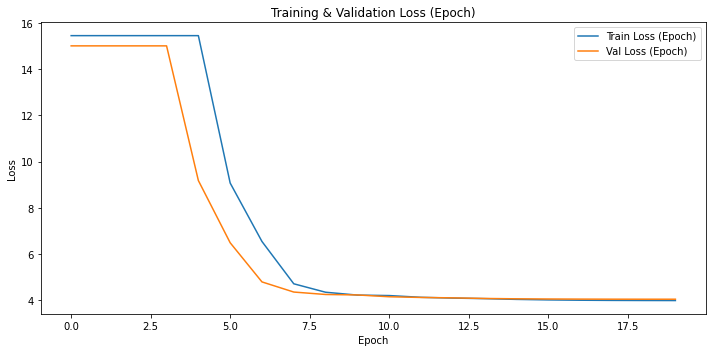

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('fsdam-s3/logs/metrics/one_shot/metrics.csv')

# Create a clean dataframe with epoch, train, val loss 
train = df[['epoch', 'train_loss_epoch']].dropna().rename(columns={'train_loss_epoch': 'train_loss'})
val = df[['epoch', 'val_loss_epoch']].dropna().rename(columns={'val_loss_epoch': 'val_loss'})

# Merge on epoch
merged = pd.merge(train, val, on='epoch', how='outer').sort_values('epoch')
print(merged.head(10))

plt.figure(figsize=(10,5))
plt.plot(merged['epoch'], merged['train_loss'], label='Train Loss (Epoch)')
plt.plot(merged['epoch'], merged['val_loss'], label='Val Loss (Epoch)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss (Epoch)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import zipfile
import os

def zip_folder(folder_path, output_zip):
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                # Add file with a relative path
                abs_file = os.path.join(root, file)
                rel_path = os.path.relpath(abs_file, start=folder_path)
                zipf.write(abs_file, arcname=rel_path)

# Usage
folder_to_zip = "fsdam-s3"        
output_zip = "fsdam-s3.zip"       

zip_folder(folder_to_zip, output_zip)
print(f"Zipped {folder_to_zip} to {output_zip}")


In [30]:
import torch
import os
import json
from PIL import Image
from transformers import AutoProcessor, BitsAndBytesConfig, LlavaNextForConditionalGeneration
from peft import PeftModel
from torchmetrics.text import ROUGEScore
import logging
import gc

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Define paths and constants
MODEL_ID = "llava-hf/llava-v1.6-vicuna-7b-hf"
CHECKPOINT_DIR = "fsdam-s3/logs"
LORA_CHECKPOINT_DIR = os.path.join(CHECKPOINT_DIR, "lora_weights_one_shot")
TEST_JSON = "fsdam/test_set/test_llava.json"
TEST_IMAGE_DIR = "fsdam/test_set/test"
OUTPUT_JSON = "fsdam-s3/logs/predictions_one_shot.json"
MAX_NEW_TOKENS = 512

# Load processor
try:
    processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
    processor.tokenizer.padding_side = "left"
    if processor.tokenizer.pad_token is None or processor.tokenizer.pad_token == "<unk>":
        processor.tokenizer.pad_token = processor.tokenizer.eos_token
        processor.tokenizer.pad_token_id = processor.tokenizer.eos_token_id
    logger.info("Pad token: %s", processor.tokenizer.pad_token)
except Exception as e:
    logger.error("Error loading processor: %s", e)
    raise e

# Load fine-tuned model
try:
    if not os.path.exists(LORA_CHECKPOINT_DIR):
        raise FileNotFoundError(f"LoRA checkpoint directory not found at {LORA_CHECKPOINT_DIR}")
    
    # Check if adapter files exist
    adapter_files = ["adapter_config.json", "adapter_model.safetensors"]
    for file in adapter_files:
        file_path = os.path.join(LORA_CHECKPOINT_DIR, file)
        if not os.path.exists(file_path):
            logger.warning("Adapter file not found: %s", file_path)
    
    bnb_cfg = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16
    )
    base_model = LlavaNextForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        quantization_config=bnb_cfg,
        trust_remote_code=True
    )
    
    # Load the PEFT model
    model = PeftModel.from_pretrained(
        base_model,
        LORA_CHECKPOINT_DIR,
        is_trainable=False,
        torch_dtype=torch.float16
    )
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    logger.info("Model loaded from %s and moved to %s", LORA_CHECKPOINT_DIR, device)
    
    # Debug: Print model info
    logger.info("Model type: %s", type(model))
    logger.info("Number of parameters: %d", sum(p.numel() for p in model.parameters()))
    
except Exception as e:
    logger.error("Error loading model: %s", e)
    logger.info("Attempting to load base model instead...")
    try:
        # Fallback to base model if LoRA loading fails
        bnb_cfg = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )
        model = LlavaNextForConditionalGeneration.from_pretrained(
            MODEL_ID,
            torch_dtype=torch.float16,
            quantization_config=bnb_cfg,
            trust_remote_code=True
        )
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        model.eval()
        logger.info("Base model loaded successfully")
    except Exception as e2:
        logger.error("Failed to load base model: %s", e2)
        raise e2

# Enhanced batch inference function
def predict_batch(image_paths, prompt=None, batch_size=2):
    logger.info("Processing batch of %d images", len(image_paths))
    try:
        prompt = prompt or "[INST] <image>\nDescribe the scene, the driver's current gaze, and where that gaze will likely shift next and why.[/INST]"
        predictions = []
        
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            batch_images = []
            
            # Process images with error handling
            for path in batch_paths:
                try:
                    if not os.path.exists(path):
                        logger.error("Image file not found: %s", path)
                        continue
                    img = Image.open(path).convert("RGB").resize((336, 336))
                    batch_images.append(img)
                except Exception as e:
                    logger.error("Error loading image %s: %s", path, e)
                    continue
            
            if not batch_images:
                logger.warning("No valid images in batch")
                predictions.extend([None] * len(batch_paths))
                continue
                
            batch_prompts = [prompt] * len(batch_images)
            
            try:
                inputs = processor(
                    text=batch_prompts,
                    images=batch_images,
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                    max_length=2048
                )
                inputs = {k: v.to(device) for k, v in inputs.items()}
                logger.info("Batch input shapes: input_ids=%s, pixel_values=%s", 
                            inputs['input_ids'].shape, inputs['pixel_values'].shape)
                
                with torch.no_grad():
                    outputs = model.generate(
                        **inputs,
                        max_new_tokens=MAX_NEW_TOKENS,
                        do_sample=False,
                        pad_token_id=processor.tokenizer.pad_token_id,
                        eos_token_id=processor.tokenizer.eos_token_id,
                        min_length=10,
                        repetition_penalty=1.1,
                        no_repeat_ngram_size=3
                    )
                
                batch_predictions = processor.batch_decode(outputs, skip_special_tokens=True)
                
                # Better post-processing
                processed_predictions = []
                for pred in batch_predictions:
                    if "[/INST]" in pred:
                        pred = pred.split("[/INST]")[-1].strip()
                    else:
                        # If no [/INST] found, try to extract meaningful content
                        pred = pred.strip()
                    
                    # Check if prediction is empty or too short
                    if len(pred.strip()) < 10:
                        logger.warning("Short or empty prediction: '%s'", pred)
                        pred = "Unable to generate meaningful description."
                    
                    processed_predictions.append(pred)
                
                predictions.extend(processed_predictions)
                
                # Log first prediction for debugging
                if processed_predictions:
                    logger.info("Sample prediction: %s...", processed_predictions[0][:100])
                
            except Exception as e:
                logger.error("Error in generation: %s", e)
                predictions.extend([None] * len(batch_images))
            
            torch.cuda.empty_cache()  # Clear memory after each batch
            
        return predictions
        
    except Exception as e:
        logger.error("Error in batch inference: %s", e)
        return [None] * len(image_paths)

# Enhanced batch inference on test dataset
def run_batch_inference(json_path, image_dir):
    try:
        with open(json_path, 'r') as f:
            test_data = json.load(f)
        logger.info("Loaded test JSON with %d entries", len(test_data))
    except Exception as e:
        logger.error("Error loading test JSON %s: %s", json_path, e)
        raise e

    # Build image paths with better error handling
    image_paths = []
    valid_items = []
    
    for item in test_data:
        image_path = os.path.join(image_dir, os.path.basename(item['image']))
        if not os.path.exists(image_path):
            # Try alternative path
            image_path = os.path.join(image_dir, item['image'])
            if not os.path.exists(image_path):
                logger.warning("Image not found for item %s: %s", item.get('id', 'unknown'), image_path)
                continue
        
        image_paths.append(image_path)
        valid_items.append(item)
    
    logger.info("Found %d valid images out of %d items", len(image_paths), len(test_data))
    
    predictions = predict_batch(image_paths, batch_size=2)
    results = []
    rouge = ROUGEScore()
    rouge_scores = []

    for item, prediction in zip(valid_items, predictions):
        ground_truth = None
        if 'conversations' in item:
            for conv in item['conversations']:
                if conv.get('from') == 'gpt':
                    ground_truth = conv['value']
                    break
        elif 'response' in item:
            ground_truth = item['response']
        elif 'answer' in item:
            ground_truth = item['answer']
            
        if ground_truth is None:
            logger.warning("No ground truth found for item %s", item.get('id', 'unknown'))
            
        if prediction is not None:
            results.append({
                "id": item.get('id', 'unknown'),
                "image": item['image'],
                "ground_truth": ground_truth,
                "prediction": prediction
            })
            
            if ground_truth and prediction.strip():
                try:
                    score = rouge([prediction], [ground_truth])['rougeL_fmeasure']
                    rouge_scores.append(score)
                except Exception as e:
                    logger.warning("Error computing ROUGE score: %s", e)
        else:
            logger.warning("Skipping item %s due to inference error", item.get('id', 'unknown'))

    # Save predictions
    os.makedirs(os.path.dirname(OUTPUT_JSON), exist_ok=True)
    with open(OUTPUT_JSON, 'w') as f:
        json.dump(results, f, indent=2)
    logger.info("Predictions saved to %s", OUTPUT_JSON)

    # Log ROUGE scores
    if rouge_scores:
        avg_rouge = sum(rouge_scores) / len(rouge_scores)
        logger.info("Average ROUGE-L: %f", avg_rouge)
        logger.info("Number of items with ROUGE scores: %d", len(rouge_scores))
    else:
        logger.info("No ROUGE scores computed (no ground truth available)")

    # Log prediction statistics
    non_empty_predictions = [p for p in predictions if p and p.strip()]
    logger.info("Generated %d non-empty predictions out of %d total", len(non_empty_predictions), len(predictions))
    
    # Clean up memory
    torch.cuda.empty_cache()
    gc.collect()
    return results

# Run inference
if __name__ == "__main__":
    predictions = run_batch_inference(TEST_JSON, TEST_IMAGE_DIR)
    logger.info("Inference completed. %d predictions generated.", len(predictions))

INFO:__main__:Pad token: </s>
Loading checkpoint shards: 100%|██████████| 3/3 [00:13<00:00,  4.37s/it]
INFO:__main__:Model loaded from fsdam-s3/logs/lora_weights_one_shot and moved to cuda
INFO:__main__:Model type: <class 'peft.peft_model.PeftModel'>
INFO:__main__:Number of parameters: 3673622528
INFO:__main__:Loaded test JSON with 81 entries
INFO:__main__:Found 81 valid images out of 81 items
INFO:__main__:Processing batch of 81 images
INFO:__main__:Batch input shapes: input_ids=torch.Size([2, 1210]), pixel_values=torch.Size([2, 3, 3, 336, 336])
INFO:__main__:Sample prediction: The scene depicts a bustling city street lined with various buildings. The driver' s current gaz e i...
INFO:__main__:Batch input shapes: input_ids=torch.Size([2, 1210]), pixel_values=torch.Size([2, 3, 3, 336, 336])
INFO:__main__:Sample prediction: A bustling city street is filled with a variety of vehicles, including cars and a truck. The traffic...
INFO:__main__:Batch input shapes: input_ids=torch.Size([2, 12

In [31]:
import json
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
from tqdm import tqdm
import nltk

# Download NLTK punkt tokenizer if not already installed
nltk.download('punkt')

# Path to your JSON file
PRED_PATH = 'fsdam-s3/logs/predictions_one_shot.json'

# Load predictions
with open(PRED_PATH, 'r') as f:
    data = json.load(f)

# Lists to store results
results = []

# Initialize scorer
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
smoothie = SmoothingFunction().method4

for entry in tqdm(data, desc="Scoring predictions"):
    gt = entry['ground_truth'].strip()
    pr = entry['prediction'].strip()

    # ROUGE-L
    rougeL = rouge.score(gt, pr)['rougeL'].fmeasure

    # BLEU-4
    bleu4 = sentence_bleu([word_tokenize(gt)], word_tokenize(pr), smoothing_function=smoothie)
    
    # METEOR
    meteor = meteor_score([word_tokenize(gt)], word_tokenize(pr))
    
    # Exact Match
    exact = int(gt == pr)

    results.append({
        "id": entry['id'],
        "image": entry['image'],
        "ground_truth": gt,
        "prediction": pr,
        "ROUGE-L": rougeL,
        "BLEU-4": bleu4,
        "METEOR": meteor,
        "Exact Match": exact
    })

# Convert to DataFrame
df = pd.DataFrame(results)

# Print mean scores
print("\n==== FSDAM Test Metrics ====\n")
print(df[["ROUGE-L", "BLEU-4", "METEOR", "Exact Match"]].mean())
print("\n==== Per-sample Results (first 5) ====\n")
print(df.head())

# Save detailed results as CSV if needed
df.to_csv('fsdam-s3/logs/test_metrics_one_shot.csv', index=False)


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
INFO:absl:Using default tokenizer.
Scoring predictions: 100%|██████████| 81/81 [00:00<00:00, 99.78it/s] 


==== FSDAM Test Metrics ====

ROUGE-L        0.335669
BLEU-4         0.081356
METEOR         0.396457
Exact Match    0.000000
dtype: float64

==== Per-sample Results (first 5) ====

           id                               image  \
0  1003_00057  fsdam/test_set/test/1003_00057.png   
1  1003_00195  fsdam/test_set/test/1003_00195.png   
2  1003_00385  fsdam/test_set/test/1003_00385.png   
3  1008_00038  fsdam/test_set/test/1008_00038.png   
4  1008_00226  fsdam/test_set/test/1008_00226.png   

                                        ground_truth  \
0  The scene shows a city street with cars and bu...   
1  The scene shows a city street with cars, build...   
2  The scene shows a city intersection with traff...   
3  A residential street with parked cars and buil...   
4  The scene shows a residential street with hous...   

                                          prediction   ROUGE-L    BLEU-4  \
0  The scene depicts a bustling city street lined...  0.413223  0.073151   
1  The sc

# Zero shot LLaVA

In [35]:
import torch
import os
import json
from PIL import Image
from transformers import AutoProcessor, BitsAndBytesConfig, LlavaNextForConditionalGeneration
from torchmetrics.text import ROUGEScore
import logging
import gc

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
file_handler = logging.FileHandler("fsdam-s3/logs/zero_shot_inference.log")
file_handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Define paths and constants
MODEL_ID = "llava-hf/llava-v1.6-vicuna-7b-hf"
TEST_JSON = "fsdam/test_set/test_llava.json"
TEST_IMAGE_DIR = "fsdam/test_set/test"
OUTPUT_JSON = "fsdam-s3/logs/predictions_zero_shot.json"
LOGS_DIR = "fsdam-s3/logs"
MAX_NEW_TOKENS = 512

# Create logs directory
os.makedirs(LOGS_DIR, exist_ok=True)

# Load processor
try:
    processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
    
    # Fix tokenizer padding configuration
    if processor.tokenizer.pad_token is None:
        processor.tokenizer.pad_token = processor.tokenizer.eos_token
        processor.tokenizer.pad_token_id = processor.tokenizer.eos_token_id
    
    # Set padding side to left for generation tasks
    processor.tokenizer.padding_side = "left"
    
    logger.info("Processor loaded successfully")
    logger.info("Pad token: %s (ID: %d)", processor.tokenizer.pad_token, processor.tokenizer.pad_token_id)
    logger.info("EOS token: %s (ID: %d)", processor.tokenizer.eos_token, processor.tokenizer.eos_token_id)
    
except Exception as e:
    logger.error("Error loading processor: %s", e)
    raise e

# Load base model (no fine-tuning)
try:
    logger.info("Loading base LLaVA model for zero-shot inference...")
    bnb_cfg = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
    )
    
    model = LlavaNextForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        quantization_config=bnb_cfg,
        trust_remote_code=True,
        device_map="auto"  # Let transformers handle device placement
    )
    
    model.eval()
    logger.info("Base model loaded successfully")
    logger.info("Model type: %s", type(model))
    logger.info("Number of parameters: %d", sum(p.numel() for p in model.parameters()))
    
except Exception as e:
    logger.error("Error loading base model: %s", e)
    raise e

def debug_single_inference(image_path, prompt):
    """
    Debug function to test single image inference
    """
    logger.info("=== DEBUGGING SINGLE INFERENCE ===")
    logger.info("Image path: %s", image_path)
    logger.info("Prompt: %s", prompt)
    
    try:
        # Load and process image
        image = Image.open(image_path).convert("RGB")
        logger.info("Original image size: %s", image.size)
        
        # Don't resize - let the processor handle it
        inputs = processor(
            text=prompt,
            images=image,
            return_tensors="pt",
            padding=True
        )
        
        # Move to device
        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        logger.info("Input shapes:")
        for k, v in inputs.items():
            logger.info("  %s: %s", k, v.shape)
        
        # Generate with detailed logging
        logger.info("Starting generation...")
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=MAX_NEW_TOKENS,
                do_sample=True,  # Try sampling instead of greedy
                temperature=0.7,
                top_p=0.9,
                pad_token_id=processor.tokenizer.pad_token_id,
                eos_token_id=processor.tokenizer.eos_token_id,
                use_cache=True
            )
        
        logger.info("Generation completed. Output shape: %s", outputs.shape)
        logger.info("Input length: %d, Output length: %d", 
                   inputs['input_ids'].shape[1], outputs.shape[1])
        
        # Decode full output
        full_output = processor.decode(outputs[0], skip_special_tokens=True)
        logger.info("Full decoded output: %s", full_output)
        
        # Decode only new tokens
        new_tokens = outputs[0][inputs['input_ids'].shape[1]:]
        new_output = processor.decode(new_tokens, skip_special_tokens=True)
        logger.info("New tokens only: %s", new_output)
        
        return new_output.strip()
        
    except Exception as e:
        logger.error("Error in debug inference: %s", e)
        import traceback
        logger.error("Traceback: %s", traceback.format_exc())
        return None

# Zero-shot batch inference function
def predict_batch_zero_shot(image_paths, prompt=None, batch_size=1):  # Reduced batch size
    """
    Zero-shot batch inference using the base LLaVA model
    """
    logger.info("Processing batch of %d images with zero-shot inference", len(image_paths))
    
   
    if prompt is None:
        prompt = "A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>\nDescribe what you see in this driving scene. Focus on the driver's gaze direction and where they might look next and why. ASSISTANT:"
    
    try:
        predictions = []
        
        for i, image_path in enumerate(image_paths):
            logger.info("Processing image %d/%d: %s", i+1, len(image_paths), image_path)
            
            # Debug first image in detail
            if i == 0:
                debug_result = debug_single_inference(image_path, prompt)
                if debug_result:
                    predictions.append(debug_result)
                    continue
            
            try:
                if not os.path.exists(image_path):
                    logger.error("Image file not found: %s", image_path)
                    predictions.append("Image file not found.")
                    continue
                
                # Load image
                image = Image.open(image_path).convert("RGB")
                logger.info("Loaded image: %s, size: %s", image_path, image.size)
                
                # Process inputs
                inputs = processor(
                    text=prompt,
                    images=image,
                    return_tensors="pt",
                    padding=True
                )
                
                # Move to device
                device = next(model.parameters()).device
                inputs = {k: v.to(device) for k, v in inputs.items()}
                
                # Generate
                with torch.no_grad():
                    outputs = model.generate(
                        **inputs,
                        max_new_tokens=MAX_NEW_TOKENS,
                        do_sample=True,
                        temperature=0.7,
                        top_p=0.9,
                        pad_token_id=processor.tokenizer.pad_token_id,
                        eos_token_id=processor.tokenizer.eos_token_id,
                        use_cache=True
                    )
                
                # Decode only the new tokens
                input_length = inputs['input_ids'].shape[1]
                new_tokens = outputs[0][input_length:]
                prediction = processor.decode(new_tokens, skip_special_tokens=True).strip()
                
                logger.info("Generated prediction: %s", prediction[:100])
                
                if len(prediction.strip()) < 5:
                    logger.warning("Short prediction, trying alternative decoding...")
                    # Try decoding the full output and extract after ASSISTANT:
                    full_output = processor.decode(outputs[0], skip_special_tokens=True)
                    if "ASSISTANT:" in full_output:
                        prediction = full_output.split("ASSISTANT:")[-1].strip()
                    elif "assistant" in full_output.lower():
                        parts = full_output.lower().split("assistant")
                        if len(parts) > 1:
                            prediction = full_output[full_output.lower().rfind("assistant") + len("assistant"):].strip()
                
                if len(prediction.strip()) < 5:
                    prediction = "Unable to generate description for this driving scene."
                
                predictions.append(prediction)
                
            except Exception as e:
                logger.error("Error processing image %s: %s", image_path, e)
                predictions.append("Error processing image.")
            

            torch.cuda.empty_cache()
        
        return predictions
        
    except Exception as e:
        logger.error("Error in zero-shot batch inference: %s", e)
        return ["Error in inference"] * len(image_paths)


def test_model_basic():
    """
    Test the model with a simple prompt to verify it's working
    """
    logger.info("=== TESTING MODEL BASIC FUNCTIONALITY ===")
    
    # Create a simple test
    test_prompt = "USER: Hello, can you help me? ASSISTANT:"
    
    try:
        inputs = processor(
            text=test_prompt,
            images=None,  
            return_tensors="pt"
        )
        
        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=50,
                do_sample=True,
                temperature=0.7,
                pad_token_id=processor.tokenizer.pad_token_id,
                eos_token_id=processor.tokenizer.eos_token_id
            )
        
        input_length = inputs['input_ids'].shape[1]
        new_tokens = outputs[0][input_length:]
        response = processor.decode(new_tokens, skip_special_tokens=True)
        
        logger.info("Basic test response: %s", response)
        return len(response.strip()) > 0
        
    except Exception as e:
        logger.error("Basic test failed: %s", e)
        return False

def run_zero_shot_evaluation(json_path, image_dir):
    """
    Run zero-shot evaluation on the test dataset
    """
    # First test basic model functionality
    if not test_model_basic():
        logger.error("Basic model test failed. Check model loading.")
        return []
    
    try:
        with open(json_path, 'r') as f:
            test_data = json.load(f)
        logger.info("Loaded test JSON with %d entries", len(test_data))
    except Exception as e:
        logger.error("Error loading test JSON %s: %s", json_path, e)
        raise e

    # Build image paths with error handling
    image_paths = []
    valid_items = []
    
    for item in test_data:
        image_path = os.path.join(image_dir, os.path.basename(item['image']))
        if not os.path.exists(image_path):
            # Try alternative path
            image_path = os.path.join(image_dir, item['image'])
            if not os.path.exists(image_path):
                logger.warning("Image not found for item %s: %s", item.get('id', 'unknown'), image_path)
                continue
        
        image_paths.append(image_path)
        valid_items.append(item)
    
    logger.info("Found %d valid images out of %d items", len(image_paths), len(test_data))
    
    # Process all images (remove debugging limitation)
    logger.info("Processing all %d images", len(image_paths))
    
    # Run zero-shot predictions
    logger.info("Starting zero-shot inference...")
    predictions = predict_batch_zero_shot(image_paths, batch_size=1)
    
    # Process results and calculate metrics
    results = []
    rouge = ROUGEScore()
    rouge_scores = []
    
    for item, prediction in zip(valid_items, predictions):
        # Extract ground truth
        ground_truth = None
        if 'conversations' in item:
            for conv in item['conversations']:
                if conv.get('from') == 'gpt':
                    ground_truth = conv['value']
                    break
        elif 'response' in item:
            ground_truth = item['response']
        elif 'answer' in item:
            ground_truth = item['answer']
        
        if ground_truth is None:
            logger.warning("No ground truth found for item %s", item.get('id', 'unknown'))
        
        if prediction is not None:
            results.append({
                "id": item.get('id', 'unknown'),
                "image": item['image'],
                "ground_truth": ground_truth,
                "prediction": prediction
            })
            
           
            if ground_truth and prediction.strip() and prediction != "Error processing image.":
                try:
                    score = rouge([prediction], [ground_truth])['rougeL_fmeasure']
                    # Convert tensor to float for JSON serialization
                    if hasattr(score, 'item'):
                        score = score.item()
                    else:
                        score = float(score)
                    rouge_scores.append(score)
                    logger.info("ROUGE score for %s: %.4f", item.get('id', 'unknown'), score)
                except Exception as e:
                    logger.warning("Error computing ROUGE score for %s: %s", item.get('id', 'unknown'), e)
        else:
            logger.warning("Skipping item %s due to inference error", item.get('id', 'unknown'))

    # Save predictions
    os.makedirs(os.path.dirname(OUTPUT_JSON), exist_ok=True)
    with open(OUTPUT_JSON, 'w') as f:
        json.dump(results, f, indent=2)
    logger.info("Zero-shot predictions saved to %s", OUTPUT_JSON)

    # Log evaluation metrics
    if rouge_scores:
        rouge_scores = [float(score) if hasattr(score, 'item') else score for score in rouge_scores]
        
        avg_rouge = sum(rouge_scores) / len(rouge_scores)
        max_rouge = max(rouge_scores)
        min_rouge = min(rouge_scores)
        logger.info("=== ZERO-SHOT EVALUATION RESULTS ===")
        logger.info("Average ROUGE-L: %.4f", avg_rouge)
        logger.info("Max ROUGE-L: %.4f", max_rouge)
        logger.info("Min ROUGE-L: %.4f", min_rouge)
        logger.info("Number of items with ROUGE scores: %d", len(rouge_scores))
        
        # Save summary statistics
        summary = {
            "method": "zero_shot",
            "avg_rouge": float(avg_rouge),
            "max_rouge": float(max_rouge),
            "min_rouge": float(min_rouge),
            "num_evaluated": len(rouge_scores),
            "total_predictions": len(results)
        }
        with open(os.path.join(LOGS_DIR, "zero_shot_summary.json"), 'w') as f:
            json.dump(summary, f, indent=2)
    else:
        logger.info("No ROUGE scores computed (no ground truth available)")

    # Log prediction statistics
    non_empty_predictions = [r['prediction'] for r in results if r['prediction'] and r['prediction'].strip()]
    logger.info("Generated %d non-empty predictions out of %d total", len(non_empty_predictions), len(results))
    
    logger.info("=== SAMPLE ZERO-SHOT PREDICTIONS ===")
    for i, result in enumerate(results[:3]):  
        logger.info("Sample %d:", i+1)
        logger.info(" Image: %s", result['image'])
        logger.info(" Prediction: %s", result['prediction'])
        if result['ground_truth']:
            logger.info(" Ground Truth: %s", result['ground_truth'][:200])
    
    # Clean up memory
    torch.cuda.empty_cache()
    gc.collect()
    return results

# Main execution
if __name__ == "__main__":
    logger.info("Starting zero-shot evaluation...")
    results = run_zero_shot_evaluation(TEST_JSON, TEST_IMAGE_DIR)
    logger.info("Zero-shot evaluation completed. %d predictions generated.", len(results))
    
    logger.info("Results saved to: %s", OUTPUT_JSON)
    logger.info("Check logs at: %s", "fsdam-s3/logs/zero_shot_inference.log")

INFO:__main__:Processor loaded successfully
INFO:__main__:Pad token: <unk> (ID: 0)
INFO:__main__:EOS token: </s> (ID: 2)
INFO:__main__:Loading base LLaVA model for zero-shot inference...
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 3/3 [00:12<00:00,  4.30s/it]
INFO:__main__:Base model loaded successfully
INFO:__main__:Model type: <class 'transformers.models.llava_next.modeling_llava_next.LlavaNextForConditionalGeneration'>
INFO:__main__:Number of parameters: 3663947776
INFO:__main__:Starting zero-shot evaluation...
INFO:__main__:=== TESTING MODEL BASIC FUNCTIONALITY ===
INFO:__main__:Basic test response: Hello! I'd be happy to try. références de la dernière réponse :
INFO:__main__:Loaded test JSON with 81 entries
INFO:__main__:Found 81 valid images out of 81 items
INFO:__m

In [36]:
PRED_PATH = 'fsdam-s3/logs/predictions_zero_shot.json'

# Load predictions
with open(PRED_PATH, 'r') as f:
    data = json.load(f)

# Lists to store results
results = []

# Initialize scorer
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
smoothie = SmoothingFunction().method4

for entry in tqdm(data, desc="Scoring predictions"):
    gt = entry['ground_truth'].strip()
    pr = entry['prediction'].strip()

    # ROUGE-L
    rougeL = rouge.score(gt, pr)['rougeL'].fmeasure

    # BLEU-4
    bleu4 = sentence_bleu([word_tokenize(gt)], word_tokenize(pr), smoothing_function=smoothie)
    
    # METEOR
    meteor = meteor_score([word_tokenize(gt)], word_tokenize(pr))
    
    # Exact Match
    exact = int(gt == pr)

    results.append({
        "id": entry['id'],
        "image": entry['image'],
        "ground_truth": gt,
        "prediction": pr,
        "ROUGE-L": rougeL,
        "BLEU-4": bleu4,
        "METEOR": meteor,
        "Exact Match": exact
    })

# Convert to DataFrame
df = pd.DataFrame(results)

# Print mean scores
print("\n==== FSDAM Test Metrics ====\n")
print(df[["ROUGE-L", "BLEU-4", "METEOR", "Exact Match"]].mean())
print("\n==== Per-sample Results (first 5) ====\n")
print(df.head())

# Save detailed results as CSV if needed
df.to_csv('fsdam-s3/logs/test_metrics_one_shot.csv', index=False)


INFO:absl:Using default tokenizer.
Scoring predictions: 100%|██████████| 81/81 [00:01<00:00, 58.11it/s]


==== FSDAM Test Metrics ====

ROUGE-L        0.170569
BLEU-4         0.020395
METEOR         0.301526
Exact Match    0.000000
dtype: float64

==== Per-sample Results (first 5) ====

           id                               image  \
0  1003_00057  fsdam/test_set/test/1003_00057.png   
1  1003_00195  fsdam/test_set/test/1003_00195.png   
2  1003_00385  fsdam/test_set/test/1003_00385.png   
3  1008_00038  fsdam/test_set/test/1008_00038.png   
4  1008_00226  fsdam/test_set/test/1008_00226.png   

                                        ground_truth  \
0  The scene shows a city street with cars and bu...   
1  The scene shows a city street with cars, build...   
2  The scene shows a city intersection with traff...   
3  A residential street with parked cars and buil...   
4  The scene shows a residential street with hous...   

                                          prediction   ROUGE-L    BLEU-4  \
0  In the image, the driver's gaze direction appe...  0.184332  0.018887   
1  In the

# Zero shot BLIP 2

In [37]:
import torch
import os
import json
import numpy as np
from PIL import Image
from transformers import AutoProcessor, Blip2ForConditionalGeneration, BitsAndBytesConfig
from torchmetrics.text import ROUGEScore
import logging
import gc

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
file_handler = logging.FileHandler("fsdam-s3/logs/blip2_zero_shot_inference.log")
file_handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Define paths and constants
MODEL_ID = "Salesforce/blip2-opt-2.7b"  # You can also try "Salesforce/blip2-flan-t5-xl"
TEST_JSON = "fsdam/test_set/test_llava.json"
TEST_IMAGE_DIR = "fsdam/test_set/test"
OUTPUT_JSON = "fsdam-s3/logs/blip2_predictions_zero_shot.json"
LOGS_DIR = "fsdam-s3/logs"
MAX_NEW_TOKENS = 512

# Create logs directory
os.makedirs(LOGS_DIR, exist_ok=True)

# Load processor and model
try:
    logger.info("Loading BLIP-2 processor...")
    processor = AutoProcessor.from_pretrained(MODEL_ID, use_fast=True)
    logger.info("Processor loaded successfully")
    
    logger.info("Loading BLIP-2 model...")
    
    # Configure quantization for memory efficiency
    bnb_cfg = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
    )
    
    model = Blip2ForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        quantization_config=bnb_cfg,
        device_map="auto"
    )
    
    model.eval()
    logger.info("BLIP-2 model loaded successfully")
    logger.info("Model type: %s", type(model))
    logger.info("Number of parameters: %d", sum(p.numel() for p in model.parameters()))
    
except Exception as e:
    logger.error("Error loading BLIP-2 model: %s", e)
    raise e

def debug_single_inference(image_path, prompt):
    """
    Debug function to test single image inference with BLIP-2
    """
    logger.info("=== DEBUGGING SINGLE BLIP-2 INFERENCE ===")
    logger.info("Image path: %s", image_path)
    logger.info("Prompt: %s", prompt)
    
    try:
        # Load and process image
        image = Image.open(image_path).convert("RGB")
        logger.info("Original image size: %s", image.size)
        
        # Try different prompt styles for BLIP-2
        prompts_to_try = [
            prompt,  # Use the same prompt as the main function
            "Question: What do you see in this driving scene? Answer:",
            "Describe the driving scene:",
            "What is happening in this image?",
            ""  # Empty prompt for unconditional generation
        ]
        
        for i, test_prompt in enumerate(prompts_to_try):
            logger.info("Trying prompt %d: '%s'", i+1, test_prompt)
            
            try:
                # Process inputs for BLIP-2
                if test_prompt:
                    inputs = processor(
                        images=image,
                        text=test_prompt,
                        return_tensors="pt"
                    )
                else:
                    # Unconditional generation (no text prompt)
                    inputs = processor(
                        images=image,
                        return_tensors="pt"
                    )
                
                # Move to device
                device = next(model.parameters()).device
                inputs = {k: v.to(device) for k, v in inputs.items()}
                
                logger.info("Input shapes:")
                for k, v in inputs.items():
                    if hasattr(v, 'shape'):
                        logger.info("  %s: %s", k, v.shape)
                
                # Generate with different strategies
                generation_configs = [
                    {
                        "max_new_tokens": MAX_NEW_TOKENS,
                        "do_sample": False,  # Greedy decoding
                        "repetition_penalty": 1.1,
                        "no_repeat_ngram_size": 3
                    },
                    {
                        "max_new_tokens": MAX_NEW_TOKENS,
                        "do_sample": True,
                        "temperature": 0.7,
                        "top_p": 0.9,
                        "repetition_penalty": 1.1
                    },
                    {
                        "max_new_tokens": 100,  # Shorter generation
                        "do_sample": True,
                        "temperature": 1.0,
                        "top_k": 50
                    }
                ]
                
                for j, gen_config in enumerate(generation_configs):
                    logger.info("Trying generation config %d: %s", j+1, gen_config)
                    
                    try:
                        with torch.no_grad():
                            outputs = model.generate(**inputs, **gen_config)
                        
                        logger.info("Generation completed. Output shape: %s", outputs.shape)
                        logger.info("Input token length: %s", inputs.get('input_ids', torch.tensor([[]])).shape[1] if 'input_ids' in inputs else 0)
                        
                        # Decode output
                        generated_text = processor.decode(outputs[0], skip_special_tokens=True)
                        logger.info("Full generated text: '%s'", generated_text)
                        
                        # Clean up the output
                        if test_prompt and test_prompt in generated_text:
                            cleaned_text = generated_text.replace(test_prompt, "").strip()
                        else:
                            cleaned_text = generated_text.strip()
                        
                        logger.info("Cleaned text: '%s'", cleaned_text)
                        
                        if len(cleaned_text.strip()) > 5:
                            logger.info("SUCCESS: Generated valid text with prompt %d, config %d", i+1, j+1)
                            return cleaned_text
                        
                    except Exception as e:
                        logger.warning("Generation config %d failed: %s", j+1, e)
                        continue
                
            except Exception as e:
                logger.warning("Prompt %d failed: %s", i+1, e)
                continue
        
        logger.warning("All prompt and generation strategies failed")
        return None
        
    except Exception as e:
        logger.error("Error in debug BLIP-2 inference: %s", e)
        import traceback
        logger.error("Traceback: %s", traceback.format_exc())
        return None

def predict_batch_zero_shot_blip2(image_paths, prompt=None, batch_size=1):
    """
    Zero-shot batch inference using BLIP-2
    """
    logger.info("Processing batch of %d images with BLIP-2 zero-shot inference", len(image_paths))
    
    # Use the same prompt as LLaVA for fair comparison
    if prompt is None:
        prompt = "Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why."
    
    # Fallback prompts to try if the main prompt fails
    fallback_prompts = [
        "Question: What do you see in this driving scene? Answer:",
        "Describe this driving scene:",
        "What is happening in this image?",
        ""  # Unconditional generation
    ]
    
    try:
        predictions = []
        
        for i, image_path in enumerate(image_paths):
            logger.info("Processing image %d/%d: %s", i+1, len(image_paths), image_path)
            
            # Debug first image in detail
            if i == 0:
                debug_result = debug_single_inference(image_path, prompt)
                if debug_result and len(debug_result.strip()) > 5:
                    predictions.append(debug_result)
                    continue
            
            try:
                if not os.path.exists(image_path):
                    logger.error("Image file not found: %s", image_path)
                    predictions.append("Image file not found.")
                    continue
                
                # Load image
                image = Image.open(image_path).convert("RGB")
                logger.info("Loaded image: %s, size: %s", image_path, image.size)
                
                prediction = None
                
                # First try the main prompt (same as LLaVA)
                prompts_to_try = [prompt] + fallback_prompts
                
                # Try different prompts until one works
                for prompt_idx, test_prompt in enumerate(prompts_to_try):
                    try:
                        logger.info("Trying prompt %d for image %d: '%s'", prompt_idx+1, i+1, test_prompt)
                        
                        # Process inputs for BLIP-2
                        if test_prompt:
                            inputs = processor(
                                images=image,
                                text=test_prompt,
                                return_tensors="pt"
                            )
                        else:
                            # Unconditional generation
                            inputs = processor(
                                images=image,
                                return_tensors="pt"
                            )
                        
                        # Move to device
                        device = next(model.parameters()).device
                        inputs = {k: v.to(device) for k, v in inputs.items()}
                        
                        # Try different generation strategies
                        generation_configs = [
                            {"max_new_tokens": 150, "do_sample": False, "repetition_penalty": 1.1},  # Greedy
                            {"max_new_tokens": 150, "do_sample": True, "temperature": 0.7, "top_p": 0.9},  # Sampling
                            {"max_new_tokens": 50, "do_sample": True, "temperature": 1.0, "top_k": 50}  # High temp, short
                        ]
                        
                        for gen_config in generation_configs:
                            try:
                                with torch.no_grad():
                                    outputs = model.generate(**inputs, **gen_config)
                                
                                # Decode output
                                generated_text = processor.decode(outputs[0], skip_special_tokens=True)
                                
                                # Clean up the output
                                if test_prompt and test_prompt in generated_text:
                                    cleaned_text = generated_text.replace(test_prompt, "").strip()
                                else:
                                    cleaned_text = generated_text.strip()
                                
                                if len(cleaned_text.strip()) > 5:
                                    prediction = cleaned_text
                                    if prompt_idx == 0:
                                        logger.info("SUCCESS with main prompt: %s", prediction[:100])
                                    else:
                                        logger.info("SUCCESS with fallback prompt %d: %s", prompt_idx, prediction[:100])
                                    break
                                    
                            except Exception as e:
                                logger.warning("Generation failed for prompt %d, config %s: %s", prompt_idx+1, gen_config, e)
                                continue
                        
                        if prediction:
                            break
                            
                    except Exception as e:
                        logger.warning("Prompt %d failed for image %d: %s", prompt_idx+1, i+1, e)
                        continue
                
                if not prediction or len(prediction.strip()) < 5:
                    prediction = "Unable to generate description for this driving scene."
                
                predictions.append(prediction)
                
            except Exception as e:
                logger.error("Error processing image %s: %s", image_path, e)
                predictions.append("Error processing image.")
            
            # Clear memory after each image
            torch.cuda.empty_cache()
        
        return predictions
        
    except Exception as e:
        logger.error("Error in BLIP-2 zero-shot batch inference: %s", e)
        return ["Error in inference"] * len(image_paths)

def test_blip2_basic():
    """
    Test BLIP-2 with a simple image to verify it's working
    """
    logger.info("=== TESTING BLIP-2 BASIC FUNCTIONALITY ===")
    
    try:
        # Create a simple test image (white square)
        from PIL import Image
        import numpy as np
        
        # Create a simple 224x224 white image for testing
        test_image = Image.fromarray(np.ones((224, 224, 3), dtype=np.uint8) * 255)
        test_prompt = "What do you see in this image?"
        
        inputs = processor(
            images=test_image,
            text=test_prompt,
            return_tensors="pt"
        )
        
        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=50,
                do_sample=True,
                temperature=0.7
            )
        
        response = processor.decode(outputs[0], skip_special_tokens=True)
        logger.info("Basic test response: %s", response)
        return True
        
    except Exception as e:
        logger.error("Basic BLIP-2 test failed: %s", e)
        return False

def run_blip2_zero_shot_evaluation(json_path, image_dir):
    """
    Run BLIP-2 zero-shot evaluation on the test dataset
    """
    # Test basic model functionality
    test_blip2_basic()
    
    try:
        with open(json_path, 'r') as f:
            test_data = json.load(f)
        logger.info("Loaded test JSON with %d entries", len(test_data))
    except Exception as e:
        logger.error("Error loading test JSON %s: %s", json_path, e)
        raise e

    # Build image paths with error handling
    image_paths = []
    valid_items = []
    
    for item in test_data:
        image_path = os.path.join(image_dir, os.path.basename(item['image']))
        if not os.path.exists(image_path):
            # Try alternative path
            image_path = os.path.join(image_dir, item['image'])
            if not os.path.exists(image_path):
                logger.warning("Image not found for item %s: %s", item.get('id', 'unknown'), image_path)
                continue
        
        image_paths.append(image_path)
        valid_items.append(item)
    
    logger.info("Found %d valid images out of %d items", len(image_paths), len(test_data))
    
    # Process all images
    logger.info("Processing all %d images", len(image_paths))
    
    # Run BLIP-2 zero-shot predictions
    logger.info("Starting BLIP-2 zero-shot inference...")
    predictions = predict_batch_zero_shot_blip2(image_paths, batch_size=1)
    
    # Process results and calculate metrics
    results = []
    rouge = ROUGEScore()
    rouge_scores = []
    
    for item, prediction in zip(valid_items, predictions):
        # Extract ground truth
        ground_truth = None
        if 'conversations' in item:
            for conv in item['conversations']:
                if conv.get('from') == 'gpt':
                    ground_truth = conv['value']
                    break
        elif 'response' in item:
            ground_truth = item['response']
        elif 'answer' in item:
            ground_truth = item['answer']
        
        if ground_truth is None:
            logger.warning("No ground truth found for item %s", item.get('id', 'unknown'))
        
        if prediction is not None:
            results.append({
                "id": item.get('id', 'unknown'),
                "image": item['image'],
                "ground_truth": ground_truth,
                "prediction": prediction
            })
            
            # Calculate ROUGE score if ground truth available
            if ground_truth and prediction.strip() and prediction != "Error processing image.":
                try:
                    score = rouge([prediction], [ground_truth])['rougeL_fmeasure']
                    # Convert tensor to float for JSON serialization
                    if hasattr(score, 'item'):
                        score = score.item()
                    else:
                        score = float(score)
                    rouge_scores.append(score)
                    logger.info("ROUGE score for %s: %.4f", item.get('id', 'unknown'), score)
                except Exception as e:
                    logger.warning("Error computing ROUGE score for %s: %s", item.get('id', 'unknown'), e)
        else:
            logger.warning("Skipping item %s due to inference error", item.get('id', 'unknown'))

    # Save predictions
    os.makedirs(os.path.dirname(OUTPUT_JSON), exist_ok=True)
    with open(OUTPUT_JSON, 'w') as f:
        json.dump(results, f, indent=2)
    logger.info("BLIP-2 zero-shot predictions saved to %s", OUTPUT_JSON)

    # Log evaluation metrics
    if rouge_scores:
        # Ensure all scores are Python floats for JSON serialization
        rouge_scores = [float(score) if hasattr(score, 'item') else score for score in rouge_scores]
        
        avg_rouge = sum(rouge_scores) / len(rouge_scores)
        max_rouge = max(rouge_scores)
        min_rouge = min(rouge_scores)
        logger.info("=== BLIP-2 ZERO-SHOT EVALUATION RESULTS ===")
        logger.info("Average ROUGE-L: %.4f", avg_rouge)
        logger.info("Max ROUGE-L: %.4f", max_rouge)
        logger.info("Min ROUGE-L: %.4f", min_rouge)
        logger.info("Number of items with ROUGE scores: %d", len(rouge_scores))
        
        # Save summary statistics
        summary = {
            "model": "blip2",
            "avg_rouge": float(avg_rouge),
            "max_rouge": float(max_rouge),
            "min_rouge": float(min_rouge),
            "num_evaluated": len(rouge_scores),
            "total_predictions": len(results)
        }
        with open(os.path.join(LOGS_DIR, "blip2_zero_shot_summary.json"), 'w') as f:
            json.dump(summary, f, indent=2)
    else:
        logger.info("No ROUGE scores computed (no ground truth available)")

    # Log prediction statistics
    non_empty_predictions = [r['prediction'] for r in results if r['prediction'] and r['prediction'].strip()]
    logger.info("Generated %d non-empty predictions out of %d total", len(non_empty_predictions), len(results))
    
    logger.info("=== SAMPLE BLIP-2 ZERO-SHOT PREDICTIONS ===")
    for i, result in enumerate(results[:3]):  # Show first 3 predictions
        logger.info("Sample %d:", i+1)
        logger.info(" Image: %s", result['image'])
        logger.info(" Prediction: %s", result['prediction'])
        if result['ground_truth']:
            logger.info(" Ground Truth: %s", result['ground_truth'][:200])
    
    # Clean up memory
    torch.cuda.empty_cache()
    gc.collect()
    return results

# Main execution
if __name__ == "__main__":
    logger.info("Starting BLIP-2 zero-shot evaluation...")
    results = run_blip2_zero_shot_evaluation(TEST_JSON, TEST_IMAGE_DIR)
    logger.info("BLIP-2 zero-shot evaluation completed. %d predictions generated.", len(results))
    
    logger.info("Results saved to: %s", OUTPUT_JSON)
    logger.info("Check logs at: %s", "fsdam-s3/logs/blip2_zero_shot_inference.log")

INFO:__main__:Loading BLIP-2 processor...
INFO:__main__:Processor loaded successfully
INFO:__main__:Loading BLIP-2 model...
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.69s/it]
INFO:__main__:BLIP-2 model loaded successfully
INFO:__main__:Model type: <class 'transformers.models.blip_2.modeling_blip_2.Blip2ForConditionalGeneration'>
INFO:__main__:Number of parameters: 1993476096
INFO:__main__:Starting BLIP-2 zero-shot evaluation...
INFO:__main__:=== TESTING BLIP-2 BASIC FUNCTIONALITY ===
INFO:__main__:Basic test response: What do you see in this image?

INFO:__main__:Loaded test JSON with 81 entries
INFO:__main__:Found 81 valid images out of 81 items
INFO:__main__:Processing all 81 images
INFO:__main__:Starting BLIP-2 zero-shot inference...
INFO:__main__

In [39]:
import torch
import os
import json
import numpy as np
from PIL import Image
from transformers import AutoProcessor, Blip2ForConditionalGeneration, BitsAndBytesConfig
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load model (simplified)
MODEL_ID = "Salesforce/blip2-opt-2.7b"
processor = AutoProcessor.from_pretrained(MODEL_ID, use_fast=True)
model = Blip2ForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16,
    device_map="auto",
    load_in_4bit=True
)
model.eval()

def test_blip2_prompts(image_path):
    """Test different prompt approaches with BLIP-2"""
    
    image = Image.open(image_path).convert("RGB")
    
    # Test different prompt styles
    prompts_to_test = [
        # Our main prompt
        "Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why.",
        
        # Simpler versions
        "Describe this driving scene.",
        "What do you see in this image?",
        "Describe the image.",
        
        # Question format
        "Question: What is happening in this driving scene? Answer:",
        "Question: Describe the scene, the driver's current gaze, and where that gaze will likely shift next and why. Answer:",
        
        # Direct instruction
        "Please describe this driving scene in detail.",
        
        # Empty prompt (unconditional)
        "",
    ]
    
    results = {}
    
    for i, prompt in enumerate(prompts_to_test):
        logger.info(f"\n=== Testing prompt {i+1}: '{prompt}' ===")
        
        try:
            # Process
            if prompt:
                inputs = processor(images=image, text=prompt, return_tensors="pt")
            else:
                inputs = processor(images=image, return_tensors="pt")
            
            device = next(model.parameters()).device
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            # Test different generation configs
            gen_configs = [
                {"max_new_tokens": 50, "do_sample": False},  # Short greedy
                {"max_new_tokens": 100, "do_sample": True, "temperature": 0.7},  # Medium sampling
                {"max_new_tokens": 200, "do_sample": True, "temperature": 1.0, "top_k": 50},  # Long high-temp
            ]
            
            for j, gen_config in enumerate(gen_configs):
                try:
                    with torch.no_grad():
                        outputs = model.generate(**inputs, **gen_config)
                    
                    # Decode
                    generated_text = processor.decode(outputs[0], skip_special_tokens=True)
                    
                    # Clean
                    if prompt and prompt in generated_text:
                        cleaned = generated_text.replace(prompt, "").strip()
                    else:
                        cleaned = generated_text.strip()
                    
                    logger.info(f"  Config {j+1}: '{cleaned}'")
                    
                    if len(cleaned) > 5:
                        results[f"prompt_{i+1}_config_{j+1}"] = {
                            "prompt": prompt,
                            "config": gen_config,
                            "output": cleaned,
                            "success": True
                        }
                        break  # Found working config for this prompt
                        
                except Exception as e:
                    logger.warning(f"  Config {j+1} failed: {e}")
                    continue
                    
        except Exception as e:
            logger.error(f"Prompt {i+1} failed completely: {e}")
            continue
    
    return results

def test_basic_blip2():
    """Test basic BLIP-2 functionality"""
    logger.info("=== TESTING BASIC BLIP-2 FUNCTIONALITY ===")
    
    # Create simple test image
    test_image = Image.fromarray(np.ones((224, 224, 3), dtype=np.uint8) * 255)
    
    # Test very simple prompt
    inputs = processor(images=test_image, text="What do you see?", return_tensors="pt")
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=20, do_sample=False)
    
    result = processor.decode(outputs[0], skip_special_tokens=True)
    logger.info(f"Basic test result: '{result}'")
    
    return "What do you see?" in result or len(result.replace("What do you see?", "").strip()) > 0

# Main diagnostic
if __name__ == "__main__":
    # Test basic functionality
    basic_works = test_basic_blip2()
    logger.info(f"Basic BLIP-2 test: {'PASSED' if basic_works else 'FAILED'}")
    
    # Test with a real driving image
    test_image_path = "fsdam/test_set/test/1003_00057.png"
    if os.path.exists(test_image_path):
        logger.info(f"\n=== TESTING WITH REAL IMAGE: {test_image_path} ===")
        results = test_blip2_prompts(test_image_path)
        
        logger.info(f"\n=== SUMMARY ===")
        logger.info(f"Working configurations: {len(results)}")
        
        for key, result in results.items():
            logger.info(f"{key}: '{result['output']}'")
            
        if results:
            logger.info("\n=== RECOMMENDATION ===")
            best_result = list(results.values())[0]
            logger.info(f"Best working prompt: '{best_result['prompt']}'")
            logger.info(f"Best config: {best_result['config']}")
            logger.info(f"Example output: '{best_result['output']}'")
        else:
            logger.error("NO WORKING CONFIGURATIONS FOUND!")
    else:
        logger.error(f"Test image not found: {test_image_path}")
        
    logger.info("Diagnostic complete!")

INFO:__main__:Loading BLIP-2 processor...
INFO:__main__:Processor loaded successfully
INFO:__main__:Loading BLIP-2 model...
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.78s/it]
INFO:__main__:BLIP-2 model loaded successfully
INFO:__main__:Model type: <class 'transformers.models.blip_2.modeling_blip_2.Blip2ForConditionalGeneration'>
INFO:__main__:Number of parameters: 1993476096
INFO:__main__:Starting BLIP-2 fair comparison zero-shot evaluation...
INFO:__main__:Loaded test JSON with 81 entries
INFO:__main__:Found 81 valid images out of 81 items
INFO:__main__:Processing all 81 images
INFO:__main__:Starting BLIP-2 zero-shot inference (fair comparison)...
INFO:__main__:Processing batch of 81 images with BLIP-2 zero-shot inference
INFO:__main__:Using ONLY th

In [38]:
import json
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
from tqdm import tqdm
import nltk


nltk.download('punkt')

# Path to your JSON file
PRED_PATH = 'fsdam-s3/logs/blip2_predictions_zero_shot.json'

# Load predictions
with open(PRED_PATH, 'r') as f:
    data = json.load(f)

# Lists to store results
results = []

# Initialize scorer
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
smoothie = SmoothingFunction().method4

for entry in tqdm(data, desc="Scoring predictions"):
    gt = entry['ground_truth'].strip()
    pr = entry['prediction'].strip()

    # ROUGE-L
    rougeL = rouge.score(gt, pr)['rougeL'].fmeasure

    # BLEU-4
    bleu4 = sentence_bleu([word_tokenize(gt)], word_tokenize(pr), smoothing_function=smoothie)
    
    # METEOR
    meteor = meteor_score([word_tokenize(gt)], word_tokenize(pr))
    
    # Exact Match
    exact = int(gt == pr)

    results.append({
        "id": entry['id'],
        "image": entry['image'],
        "ground_truth": gt,
        "prediction": pr,
        "ROUGE-L": rougeL,
        "BLEU-4": bleu4,
        "METEOR": meteor,
        "Exact Match": exact
    })

# Convert to DataFrame
df = pd.DataFrame(results)

# Print mean scores
print("\n==== FSDAM Test Metrics ====\n")
print(df[["ROUGE-L", "BLEU-4", "METEOR", "Exact Match"]].mean())
print("\n==== Per-sample Results (first 5) ====\n")
print(df.head())

# Save detailed results as CSV if needed
df.to_csv('fsdam-s3/logs/test_metrics_one_shot.csv', index=False)


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
INFO:absl:Using default tokenizer.
Scoring predictions: 100%|██████████| 81/81 [00:00<00:00, 269.93it/s]



==== FSDAM Test Metrics ====

ROUGE-L        0.115087
BLEU-4         0.001743
METEOR         0.051481
Exact Match    0.000000
dtype: float64

==== Per-sample Results (first 5) ====

           id                               image  \
0  1003_00057  fsdam/test_set/test/1003_00057.png   
1  1003_00195  fsdam/test_set/test/1003_00195.png   
2  1003_00385  fsdam/test_set/test/1003_00385.png   
3  1008_00038  fsdam/test_set/test/1008_00038.png   
4  1008_00226  fsdam/test_set/test/1008_00226.png   

                                        ground_truth  \
0  The scene shows a city street with cars and bu...   
1  The scene shows a city street with cars, build...   
2  The scene shows a city intersection with traff...   
3  A residential street with parked cars and buil...   
4  The scene shows a residential street with hous...   

                                prediction   ROUGE-L    BLEU-4    METEOR  \
0   A white car that is parked on the left  0.135593  0.000506  0.060606   
1        

In [112]:
torch.cuda.empty_cache()
gc.collect()

0